In [1]:
!pip install pycona
import pandas as pd
from pycona import *

### PyConA - Python-based open-source library for Constraint Acquisition
- Based on the well-known CPMpy Constraint Programming and Modeling library (https://github.com/CPMpy/cpmpy)
- Includes various algorithms and methods, and models several commonly used CA benchmarks
    - Currently only interactive CA methods
- Easy interface to run CA methods, also directed to be extendable for research purposes


# A first look at **PyConA**

- ProblemInstance class to encaptulate the information for CA instances
- Core the CA algorithms
    - Interactive CA algorithms subclassing the AlgorithmCAInteractive class
- CAEnv class: the environment of CA systems
    - Subclassed by ActiveCAEnv for interactive CA systems.
    - Include the configurable options of CA systems


### Preparing the problem instances

Vocubulary: Create any type of variable supported in CPMpy

In [2]:
import cpmpy as cp

# Define the variables
int_vars = cp.intvar(1, 4, shape=(4,4), name="var")  # lower bound, upper bound, shape, variable names
print(int_vars)

[[var[0,0] var[0,1] var[0,2] var[0,3]]
 [var[1,0] var[1,1] var[1,2] var[1,3]]
 [var[2,0] var[2,1] var[2,2] var[2,3]]
 [var[3,0] var[3,1] var[3,2] var[3,3]]]


Creating the language:
- need to define abstract relations, 
- **PyConA** defines abstract variables for that

In [3]:
AV = absvar(2)  # create abstract vars - as many as maximum arity

# create abstract relations using the abstract vars
language = [AV[0] == AV[1], 
            AV[0] != AV[1], 
            AV[0] < AV[1], 
            AV[0] > AV[1], 
            AV[0] >= AV[1], 
            AV[0] <= AV[1]]
print(language)

[(AV4) == (AV5), (AV4) != (AV5), (AV4) < (AV5), (AV4) > (AV5), (AV4) >= (AV5), (AV4) <= (AV5)]


#### Using the *ProblemInstance* class for modeling a problem: Example with nurse rostering:

In [4]:
import cpmpy as cp

def construct_nurse_rostering(shifts_per_day, num_days, num_nurses, nurses_per_shift):

    # Define the variables
    roster_matrix = cp.intvar(1, num_nurses, shape=(num_days, shifts_per_day, nurses_per_shift), 
                              name="shifts")


    # Create the language:
    AV = absvar(2)  # create abstract vars - as many as maximum arity
    # create abstract relations using the abstract vars
    lang = [AV[0] == AV[1], AV[0] != AV[1], AV[0] < AV[1], AV[0] > AV[1], AV[0] >= AV[1], AV[0] <= AV[1]]

    instance = ProblemInstance(variables=roster_matrix, language=lang)

    return instance

Constructing a small nurse rostering instance:

In [5]:
instance= construct_nurse_rostering(3, 2, 8, 2)
print(instance)

ProblemInstance: 

Variables: [[[shifts[0,0,0] shifts[0,0,1]]
  [shifts[0,1,0] shifts[0,1,1]]
  [shifts[0,2,0] shifts[0,2,1]]]

 [[shifts[1,0,0] shifts[1,0,1]]
  [shifts[1,1,0] shifts[1,1,1]]
  [shifts[1,2,0] shifts[1,2,1]]]].

Language: [(AV6) == (AV7), (AV6) != (AV7), (AV6) < (AV7), (AV6) > (AV7), (AV6) >= (AV7), (AV6) <= (AV7)].


##### Active CA: Simulating the oracle

- Default oracle: human user
- We can create our oracle to automate the process
- E.g.: ConstraintOracle for using the set of constraints to simulate the answers.

Lets adjust our `construct_nurse_rostering()` function to also return an oracle:

In [6]:
def construct_nurse_rostering_with_oracle(shifts_per_day, num_days, num_nurses, nurses_per_shift):
    
    inst = construct_nurse_rostering(shifts_per_day, num_days, num_nurses, nurses_per_shift)
    
    # Create an oracle for simulation, by defining the ground truth problem
    ## Define the variables
    roster_matrix = inst.variables
    
    ## Define the list of (fixed-arity/decomposed) constraints
    C_T = []

    ## Constraint: Each shift in a day must be assigned to a different nurse
    for day in range(num_days):
        C_T += cp.AllDifferent(roster_matrix[day, ...]).decompose()   # ... means all remaining dimensions
    ## Constraint: The last shift of a day cannot have the same nurse as the first shift of the next day
    for day in range(num_days - 1):
        C_T += cp.AllDifferent(roster_matrix[day, shifts_per_day - 1], roster_matrix[day + 1, 0]).decompose()

    oracle = ConstraintOracle(C_T)

    return inst, oracle

## Interactive Constraint Acquisition System 

Core: the AlgorithmCAInteractive class. Subclassed with different algorithms from the literature. 

CA environment to configure the exact settings of CA systems (and offer common functionality)

ActiveCAEnv for interactive CA systems, configuring the 3 main subcomponents of interactive CA systems:

- qgen: (for query generation) An instance of QGenBase, default is PQGen.
- find_scope: (for finding the scope) An instance of FindScopeBase, default is FindScope2.
- findc: (for finding the exact constraints) An instance of FindCBase, default is FindC.

For each of the subcomponents various methods are implemented from the litarature.

In [7]:
# Create the instance
instance, oracle = construct_nurse_rostering_with_oracle(3, 2, 8, 2)

# create the interactive CA system of choice with the default settings
qa = QuAcq()
learned_instance = qa.learn(instance, oracle=oracle, verbose=1)

............L..........L...L...L....L.....L...L.....L.....L....L......L.....L...L......L......L....L......L......L......L........L......L........L........L.....L........L.......L......L............L....L.......L.......L.........L......L.....L..
Learned 34 constraints in 210 queries.


In [8]:
# Creating a custom environment, change find_scope to basic FindScope
env = ActiveCAEnv(find_scope=FindScope())

# create the interactive CA system of choice
qa_fs1 = QuAcq(env)
learned_instance = qa_fs1.learn(instance, oracle=oracle, verbose=1)


........L.........L.........L..........L.........L.............L............L............L........L........L...........L.............L.........L.........L.............L...........L..............L..............L.........L...........L..........L...........L............L..........L.........L.............L.............L.......L..........L...........L...........L...........L...........L......L..
Learned 34 constraints in 359 queries.


In [9]:
# we can compare the detailed statistics:
pd.concat([qa.env.metrics.short_statistics, 
           qa_fs1.env.metrics.short_statistics], keys=["QuAcq findscope2", "QuAcq findscope"])

CL  tot_q  top_lvl_q  tfs_q  tfc_q  avg_q_size  \
QuAcq findscope2 0  34    210         37    156     17      6.5619   
QuAcq findscope  0  34    359         38    290     31      5.3036   

                    avg_gen_time   avg_t   max_t    tot_t  conv  
QuAcq findscope2 0        0.8533  0.1578  1.3653  33.1333     1  
QuAcq findscope  0        1.0493  0.1204  1.8469  43.2310     1

In [10]:
# increase verbosity for closer look of the learning process
learned_instance = qa.learn(instance, oracle=oracle, verbose=3)

Size of CL:  0
Size of B:  396
Number of Queries:  0
Query0: is this a solution?
[[[1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 1]]]
Answer:  No
Query1: is this a solution?
[[[0 0]
  [1 1]
  [1 0]]

 [[1 1]
  [0 0]
  [1 0]]]
Answer:  No
Query2: is this a solution?
[[[0 0]
  [0 0]
  [1 0]]

 [[1 1]
  [0 0]
  [0 0]]]
Answer:  No
Query3: is this a solution?
[[[0 0]
  [0 0]
  [1 0]]

 [[0 1]
  [0 0]
  [0 0]]]
Answer:  No
Query4: is this a solution?
[[[0 0]
  [0 0]
  [1 0]]

 [[0 2]
  [0 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) > (shifts[1,0,1])]
Query5: is this a solution?
[[[0 0]
  [0 0]
  [3 0]]

 [[0 1]
  [0 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) < (shifts[1,0,1])]
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[1,0,1])]
Size of CL:  1
Size of B:  393
Number of Queries:  6
Query6: is this a solution?
[[[1 1]
  [1 1]
  [2 1]]

 [[1 1]
  [1 1]
  [1 1]]]
Answer:  No
Query7

Query57: is this a solution?
[[[1 4]
  [5 2]
  [1 5]]

 [[5 2]
  [1 2]
  [1 4]]]
Answer:  No
Query58: is this a solution?
[[[0 0]
  [5 2]
  [1 0]]

 [[5 2]
  [0 0]
  [1 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) < (shifts[1,0,1]), (shifts[0,1,1]) < (shifts[1,2,0]), (shifts[0,2,0]) != (shifts[1,2,0]), (shifts[0,1,1]) != (shifts[1,0,1]), (shifts[0,1,1]) > (shifts[1,0,0]), (shifts[0,1,0]) < (shifts[1,2,0]), (shifts[1,0,0]) <= (shifts[1,2,0]), (shifts[0,1,1]) <= (shifts[1,2,0]), (shifts[0,1,0]) < (shifts[0,1,1]), (shifts[0,1,0]) <= (shifts[0,1,1]), (shifts[0,1,1]) >= (shifts[1,0,0]), (shifts[0,1,1]) == (shifts[1,0,0]), (shifts[0,1,1]) == (shifts[0,2,0]), (shifts[0,1,0]) == (shifts[0,1,1]), (shifts[0,1,0]) <= (shifts[1,2,0]), (shifts[0,1,1]) <= (shifts[0,2,0]), (shifts[0,1,1]) == (shifts[1,2,0])]
Query59: is this a solution?
[[[0 4]
  [5 2]
  [1 0]]

 [[5 2]
  [0 2]
  [1 4]]]
Answer:  No
Query60: is this a solution?
[[[0 4]
  [5 2]
  [1 0]]

 [[5 2]
  [

Query106: is this a solution?
[[[2 8]
  [1 5]
  [2 1]]

 [[1 5]
  [2 3]
  [2 2]]]
Answer:  No
Query107: is this a solution?
[[[0 8]
  [1 5]
  [2 0]]

 [[1 5]
  [0 3]
  [2 2]]]
Answer:  No
Query108: is this a solution?
[[[0 8]
  [1 5]
  [2 0]]

 [[1 5]
  [0 0]
  [2 2]]]
Answer:  No
Query109: is this a solution?
[[[0 0]
  [1 5]
  [2 0]]

 [[1 5]
  [0 0]
  [2 2]]]
Answer:  No
Query110: is this a solution?
[[[0 0]
  [0 0]
  [2 0]]

 [[1 5]
  [0 0]
  [0 2]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) != (shifts[1,2,1]), (shifts[1,0,0]) >= (shifts[1,2,1])]
Query111: is this a solution?
[[[0 0]
  [1 0]
  [2 0]]

 [[1 5]
  [0 0]
  [0 2]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) > (shifts[1,2,1]), (shifts[0,1,0]) >= (shifts[1,2,1])]
Query112: is this a solution?
[[[0 0]
  [1 0]
  [2 0]]

 [[1 5]
  [0 0]
  [2 2]]]
Answer:  No
Query113: is this a solution?
[[[0 0]
  [0 0]
  [2 0]]

 [[1 5]
  [0 0]
  [2 2]]]
Answer:  No
Query114:

Query155: is this a solution?
[[[1 3]
  [4 1]
  [2 1]]

 [[4 1]
  [2 3]
  [7 3]]]
Answer:  No
Query156: is this a solution?
[[[0 3]
  [4 1]
  [2 0]]

 [[4 1]
  [0 3]
  [7 3]]]
Answer:  No
Query157: is this a solution?
[[[0 3]
  [4 1]
  [2 0]]

 [[4 1]
  [0 3]
  [7 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) != (shifts[1,1,1])]
Query158: is this a solution?
[[[0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 3]
  [0 3]]]
Answer:  No
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,2,1])]
Size of CL:  20
Size of B:  152
Number of Queries:  159
Query159: is this a solution?
[[[4 2]
  [5 3]
  [4 4]]

 [[1 2]
  [4 3]
  [5 4]]]
Answer:  No
Query160: is this a solution?
[[[0 2]
  [5 3]
  [4 0]]

 [[1 2]
  [0 3]
  [5 4]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) != (shifts[1,1,1])]
Query161: is this a solution?
[[[4 2]
  [5 3]
  [4 0]]

 [[1 2]
  [0 3]
  [5 4]]]
Answer:  No
Query162: is this a solution?
[[[4 0]
  

Query203: is this a solution?
[[[2 3]
  [4 6]
  [1 4]]

 [[3 4]
  [2 5]
  [6 2]]]
Answer:  No
Query204: is this a solution?
[[[2 3]
  [4 6]
  [1 0]]

 [[3 4]
  [0 5]
  [6 2]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) != (shifts[1,2,1])]
Query205: is this a solution?
[[[2 3]
  [4 6]
  [1 0]]

 [[3 4]
  [2 5]
  [6 2]]]
Answer:  No
Query206: is this a solution?
[[[0 3]
  [4 6]
  [1 0]]

 [[3 4]
  [2 5]
  [6 2]]]
Answer:  No
Query207: is this a solution?
[[[0 0]
  [4 6]
  [1 0]]

 [[3 4]
  [2 0]
  [6 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) == (shifts[1,1,0]), (shifts[0,1,1]) < (shifts[1,1,0]), (shifts[1,1,0]) >= (shifts[1,2,0]), (shifts[0,2,0]) > (shifts[1,1,0]), (shifts[0,2,0]) >= (shifts[1,1,0]), (shifts[1,1,0]) > (shifts[1,2,0]), (shifts[0,1,0]) < (shifts[1,1,0]), (shifts[1,1,0]) == (shifts[1,2,0]), (shifts[1,0,0]) == (shifts[1,1,0]), (shifts[0,1,0]) == (shifts[1,1,0]), (shifts[0,1,1]) <= (shifts[1,1,0]), (shift

Query253: is this a solution?
[[[6 0]
  [0 0]
  [0 8]]

 [[0 0]
  [0 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) > (shifts[0,2,1])]
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,2,1])]
Size of CL:  34
Size of B:  8
Number of Queries:  254
Query254: is this a solution?
[[[2 1]
  [0 0]
  [0 6]]

 [[0 0]
  [1 6]
  [0 5]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) <= (shifts[1,1,0]), (shifts[0,0,0]) < (shifts[1,1,0]), (shifts[0,0,0]) >= (shifts[0,2,1]), (shifts[0,2,1]) != (shifts[1,1,1]), (shifts[0,2,1]) <= (shifts[1,2,1]), (shifts[0,0,1]) != (shifts[1,1,0])]
Size of CL:  34
Size of B:  2
Number of Queries:  255
Query255: is this a solution?
[[[2 0]
  [0 0]
  [0 1]]

 [[0 0]
  [1 0]
  [0 0]]]
Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) != (shifts[1,1,0])]
Size of CL:  34
Size of B:  1
Number of Queries:  256
Query256: is this a solution?
[[[1 0]
  [0 0]
  

### Learned instance

In [11]:
print(learned_instance) # see the instance with the learned constraints :

ProblemInstance: 

Variables: [[[shifts[0,0,0] shifts[0,0,1]]
  [shifts[0,1,0] shifts[0,1,1]]
  [shifts[0,2,0] shifts[0,2,1]]]

 [[shifts[1,0,0] shifts[1,0,1]]
  [shifts[1,1,0] shifts[1,1,1]]
  [shifts[1,2,0] shifts[1,2,1]]]].

Constraints: [(shifts[0,2,0]) != (shifts[1,0,1]), (shifts[1,0,0]) != (shifts[1,0,1]), (shifts[0,2,0]) != (shifts[1,0,0]), (shifts[0,1,0]) != (shifts[0,2,0]), (shifts[1,0,0]) != (shifts[1,2,0]), (shifts[1,0,1]) != (shifts[1,2,0]), (shifts[0,1,1]) != (shifts[0,2,0]), (shifts[1,0,1]) != (shifts[1,1,1]), (shifts[1,0,1]) != (shifts[1,2,1]), (shifts[0,1,0]) != (shifts[0,1,1]), (shifts[0,0,1]) != (shifts[0,2,0]), (shifts[0,0,1]) != (shifts[0,1,1]), (shifts[0,0,1]) != (shifts[0,1,0]), (shifts[1,0,0]) != (shifts[1,2,1]), (shifts[1,2,0]) != (shifts[1,2,1]), (shifts[1,0,0]) != (shifts[1,1,1]), (shifts[1,1,1]) != (shifts[1,2,0]), (shifts[0,0,0]) != (shifts[0,1,0]), (shifts[0,0,0]) != (shifts[0,0,1]), (shifts[1,1,1]) != (shifts[1,2,1]), (shifts[0,0,0]) != (shifts[0,2,0]), (s

### Solving the learned model

In [12]:
m = learned_instance.get_cpmpy_model() # get the cpmpy model
m.solve()

print(learned_instance.variables.value()) # see the solution

[[[2 3]
  [5 4]
  [6 1]]

 [[5 7]
  [1 3]
  [4 2]]]


### Visualizing the solutions and queries

In [13]:

import matplotlib.pyplot as plt


def visualize_nurse_rostering(shifts):
    num_days, shifts_per_day, nurses_per_shift = shifts.shape
    num_nurses = shifts.max()  # Assuming nurse IDs are from 1 to num_nurses

    # Create an empty DataFrame with nurses as rows and days as columns
    columns = [f'Day {j} Shift {k}' for j in range(num_days) for k in range(shifts_per_day)]
    df = pd.DataFrame(index=[f'Nurse {i+1}' for i in range(num_nurses)], columns=columns)

    # Fill the DataFrame with shift information
    for day in range(num_days):
        for shift in range(shifts_per_day):
            for nurse in range(nurses_per_shift):
                nurse_id = shifts[day, shift, nurse]
                df.at[f'Nurse {nurse_id}', f'Day {day} Shift {shift}'] = 'Assigned'

    # Fill 'Not Assigned' for nurses who are not assigned to a shift
    df = df.fillna('Not Assigned')

    # Create a color map to highlight assigned shifts
    cmap = {'Assigned': 'lightgreen', 'Not Assigned': 'white'}

    # Create a new DataFrame to store colors
    df_colors = df.applymap(lambda x: cmap[x])

    # Calculate figure size dynamically
    fig_width = max(12, num_days * shifts_per_day * 1.5)  # Adjust width scaling factor as needed
    fig_height = max(2, num_nurses * 0.2)  # Adjust height scaling factor as needed

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Create a table plot
    table = ax.table(cellText=df.values, cellColours=df_colors.values, colLabels=df.columns, rowLabels=df.index,
                     cellLoc='center', loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    ax.axis('off')
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)  # Adjust the subplot parameters

    plt.show()


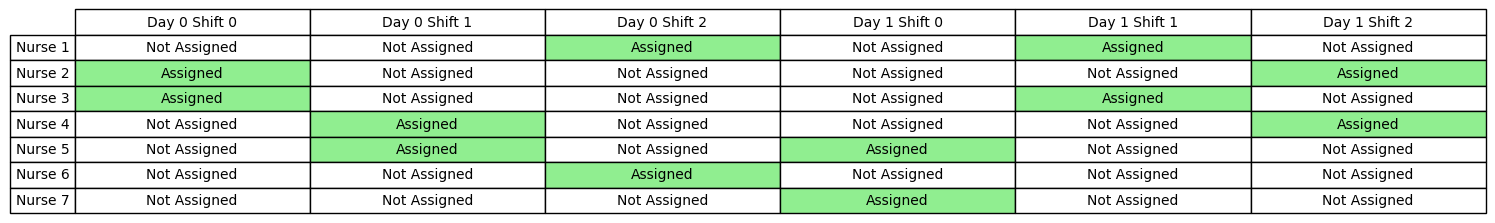

In [14]:
visualize_nurse_rostering(instance.variables.value())

### Using the visualization in the queries

In [15]:
instance.visualize = visualize_nurse_rostering

Size of CL:  0
Size of B:  396
Number of Queries:  0
Query0: is this a solution?


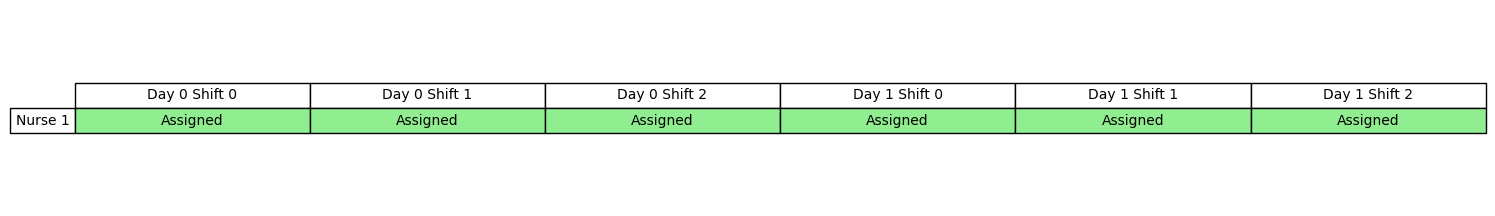

Answer:  No
Query1: is this a solution?


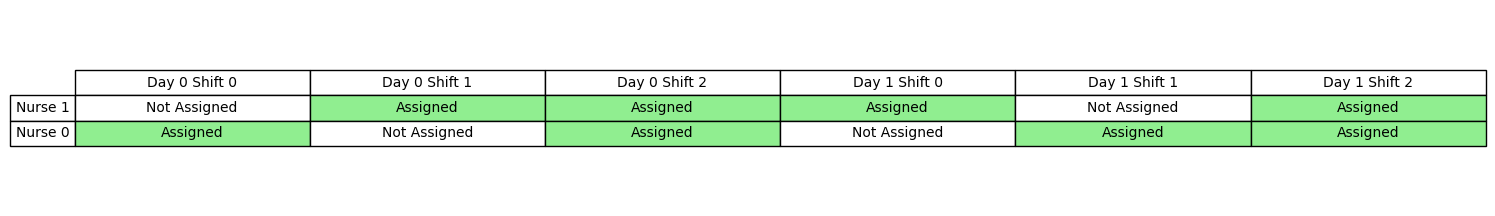

Answer:  No
Query2: is this a solution?


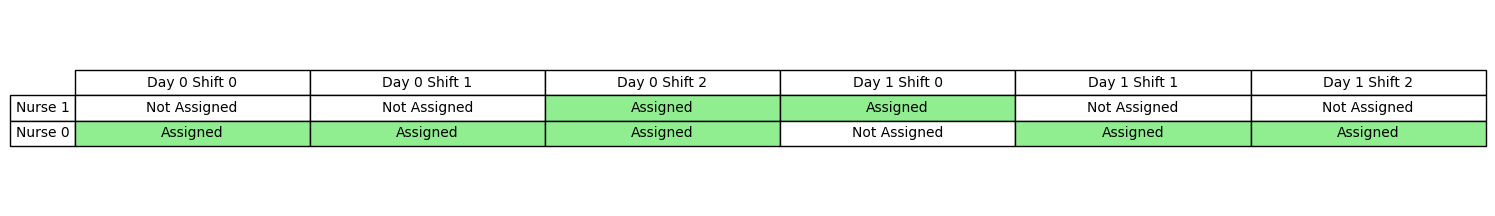

Answer:  No
Query3: is this a solution?


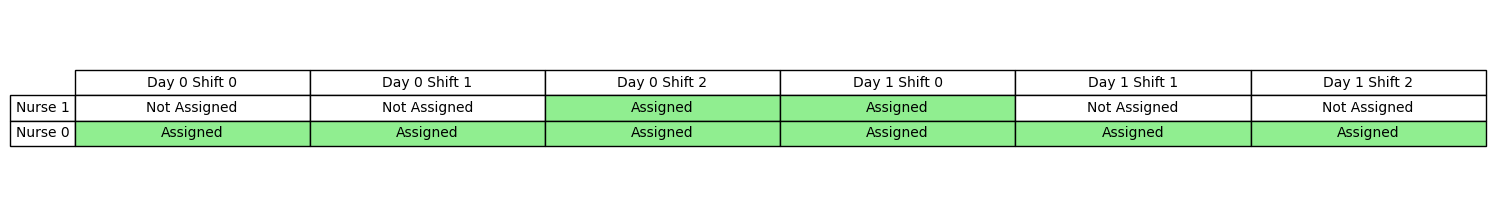

Answer:  No
Query4: is this a solution?


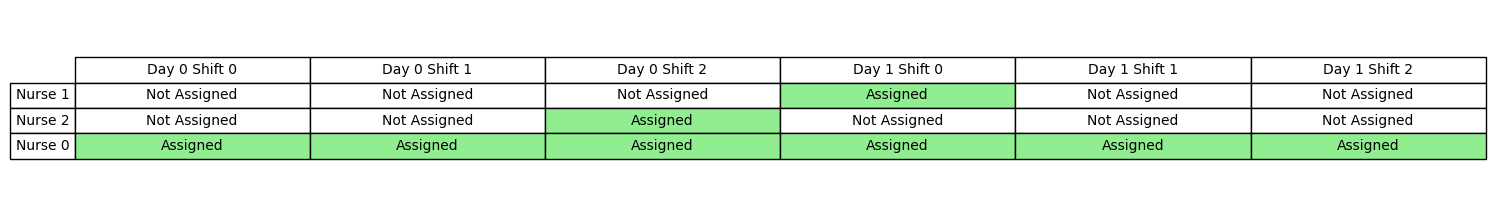

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) < (shifts[1,0,1])]
Query5: is this a solution?


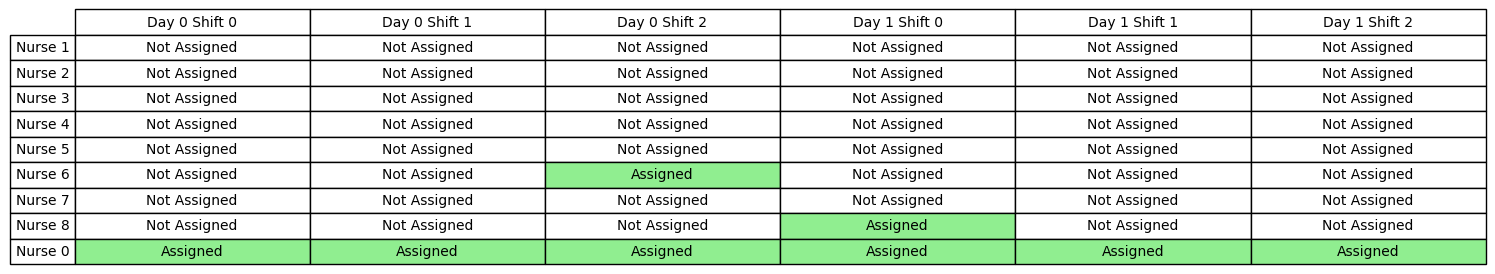

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) > (shifts[1,0,1])]
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[1,0,1])]
Size of CL:  1
Size of B:  393
Number of Queries:  6
Query6: is this a solution?


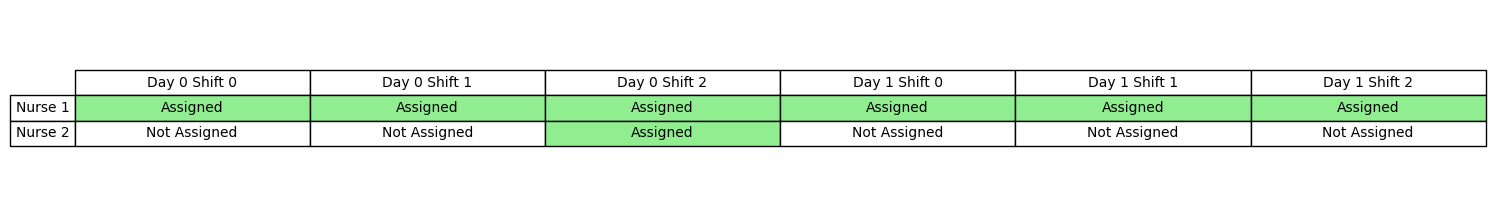

Answer:  No
Query7: is this a solution?


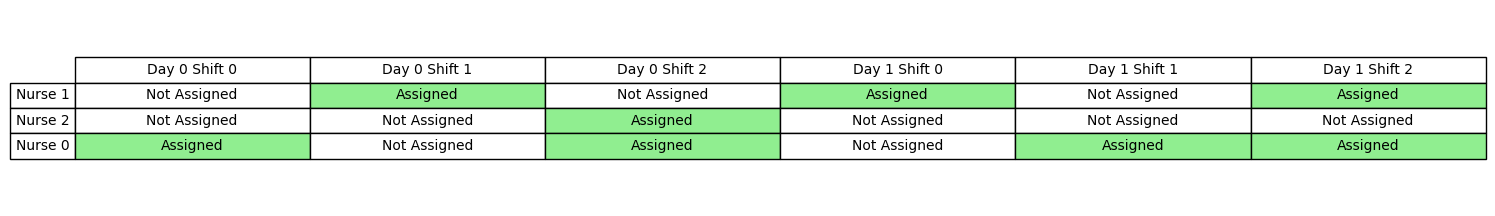

Answer:  No
Query8: is this a solution?


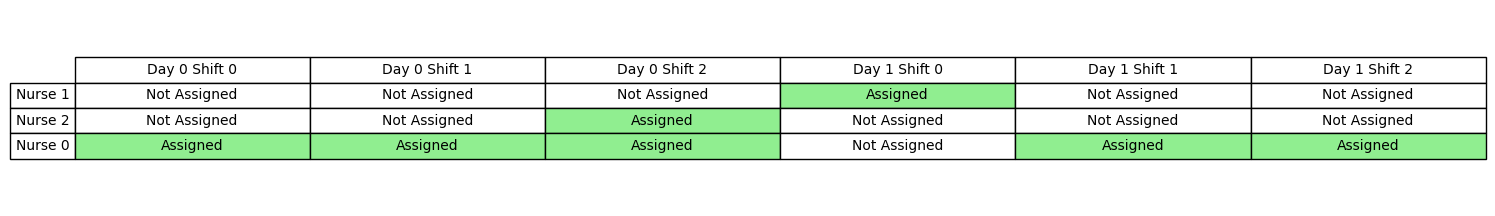

Answer:  No
Query9: is this a solution?


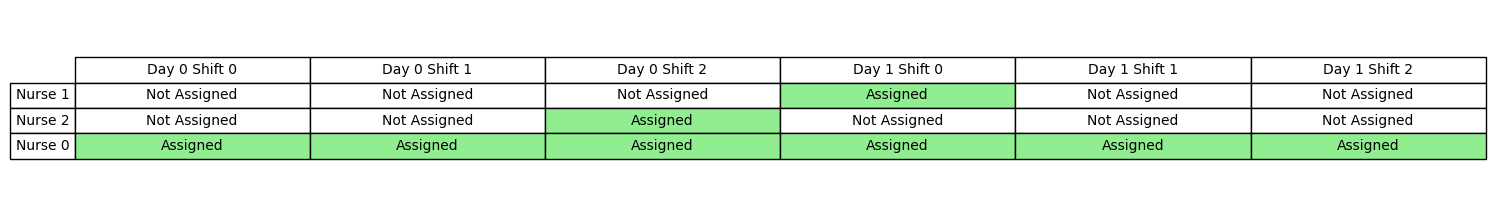

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) == (shifts[1,0,1]), (shifts[0,2,0]) <= (shifts[1,0,1])]
Query10: is this a solution?


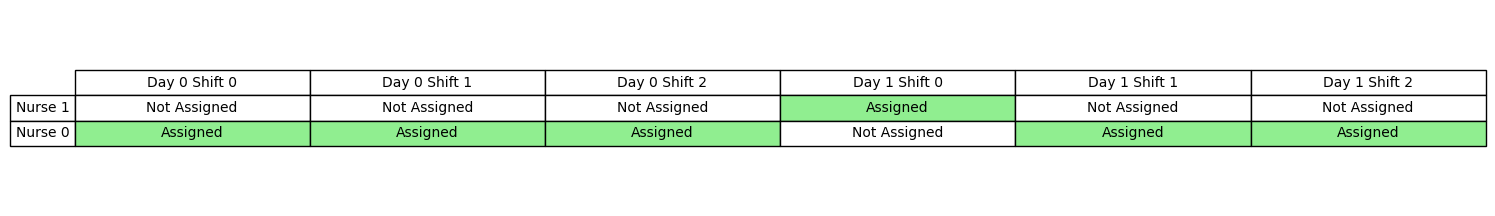

Answer:  No
Query11: is this a solution?


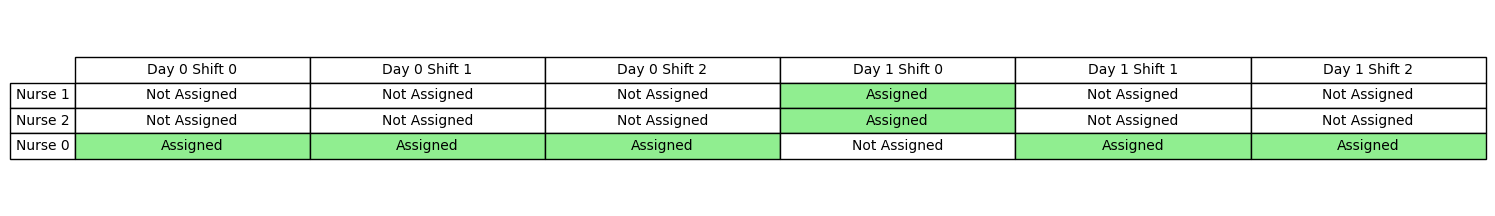

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) < (shifts[1,0,1])]
Query12: is this a solution?


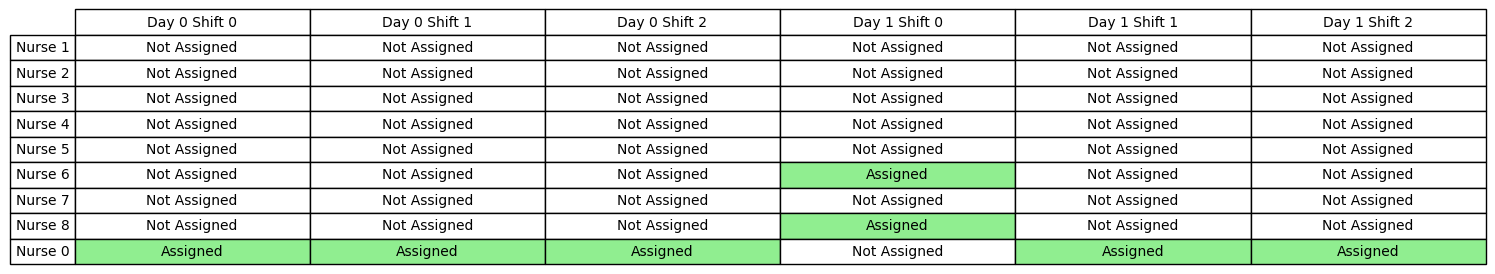

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) > (shifts[1,0,1])]
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[1,0,1])]
Size of CL:  2
Size of B:  388
Number of Queries:  13
Query13: is this a solution?


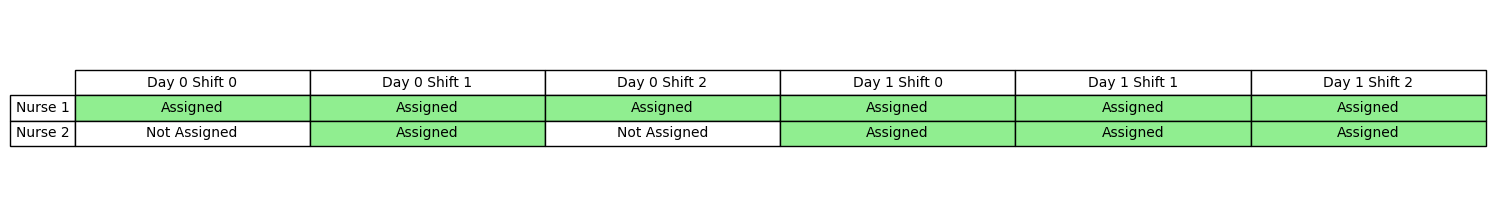

Answer:  No
Query14: is this a solution?


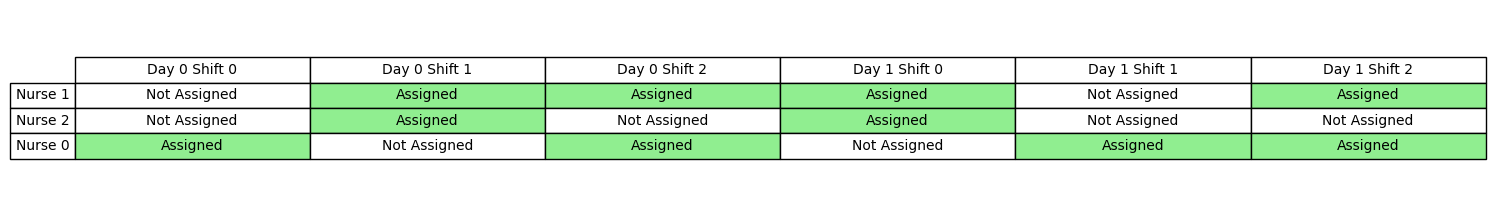

Answer:  No
Query15: is this a solution?


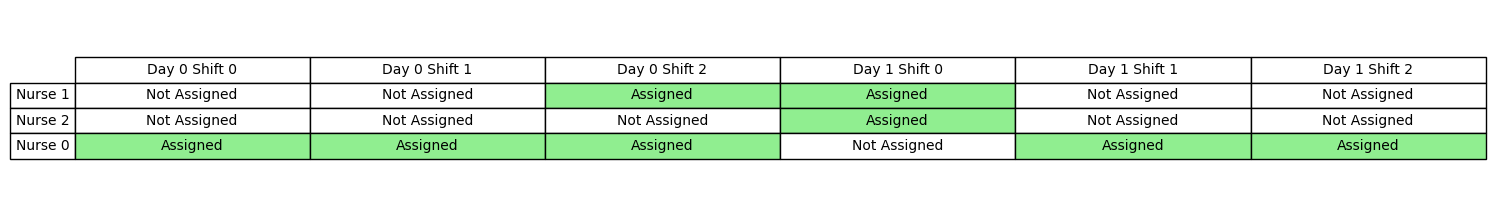

Answer:  No
Query16: is this a solution?


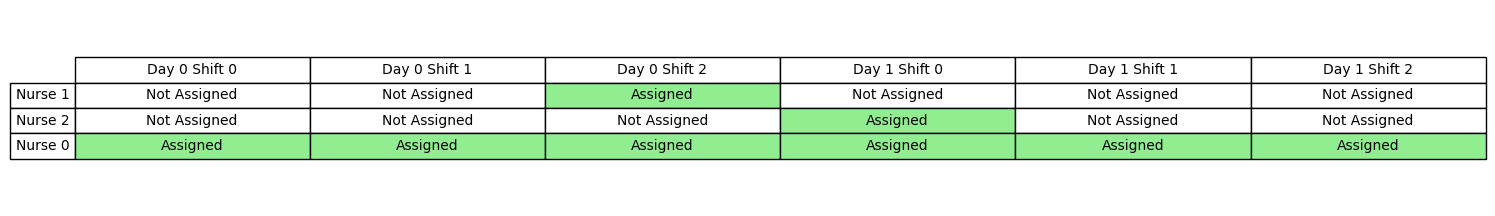

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) >= (shifts[1,0,1])]
Query17: is this a solution?


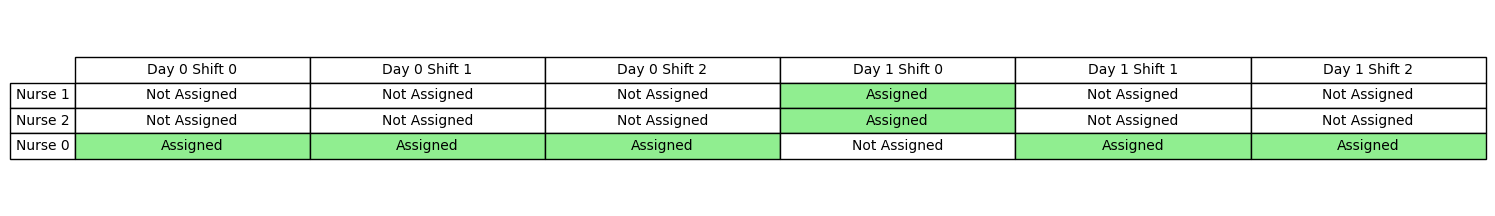

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) == (shifts[1,0,1]), (shifts[1,0,0]) >= (shifts[1,0,1])]
Query18: is this a solution?


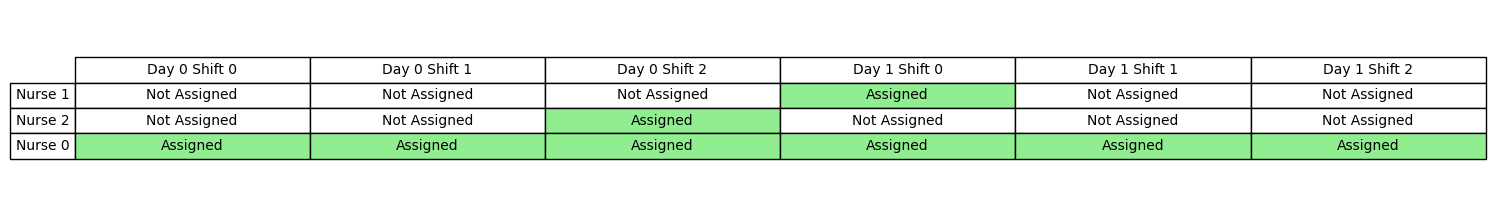

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) < (shifts[1,0,0])]
Query19: is this a solution?


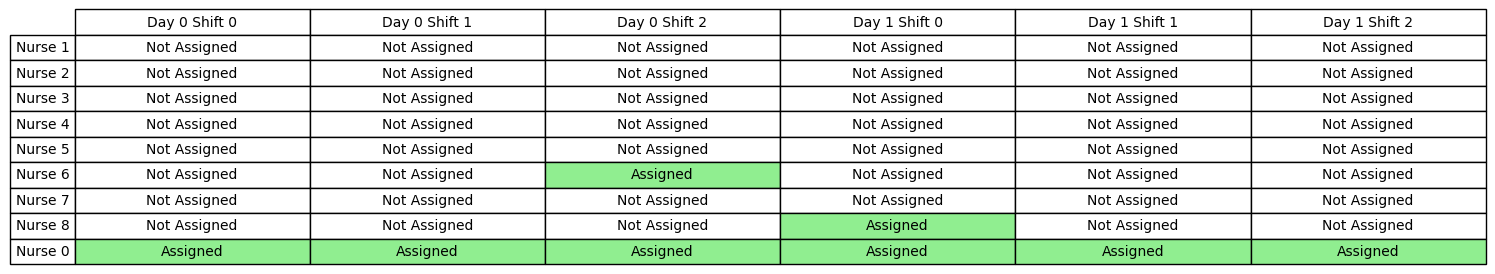

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) > (shifts[1,0,0])]
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[1,0,0])]
Size of CL:  3
Size of B:  382
Number of Queries:  20
Query20: is this a solution?


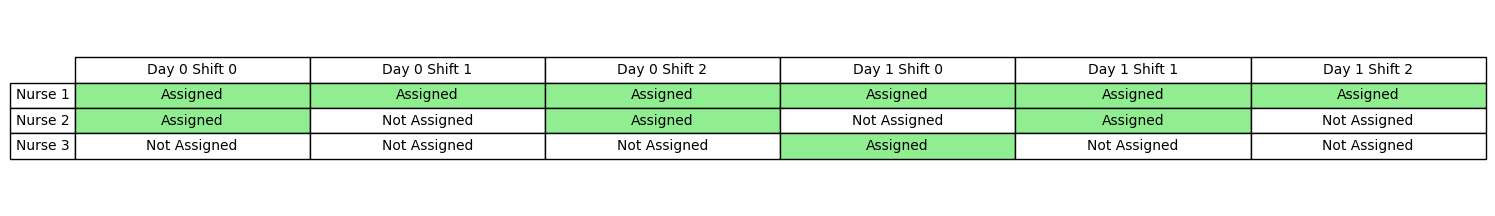

Answer:  No
Query21: is this a solution?


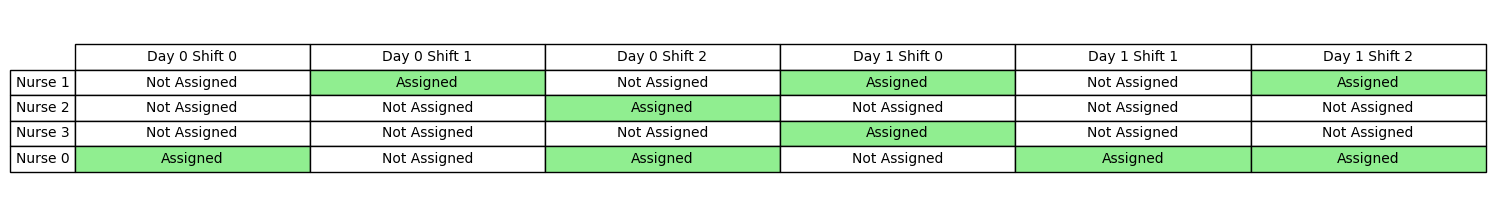

Answer:  No
Query22: is this a solution?


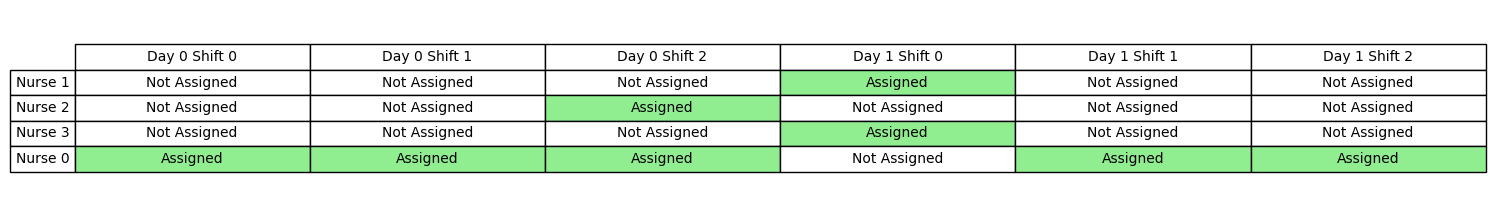

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) >= (shifts[1,0,0]), (shifts[0,2,0]) == (shifts[1,0,0]), (shifts[1,0,0]) <= (shifts[1,0,1])]
Query23: is this a solution?


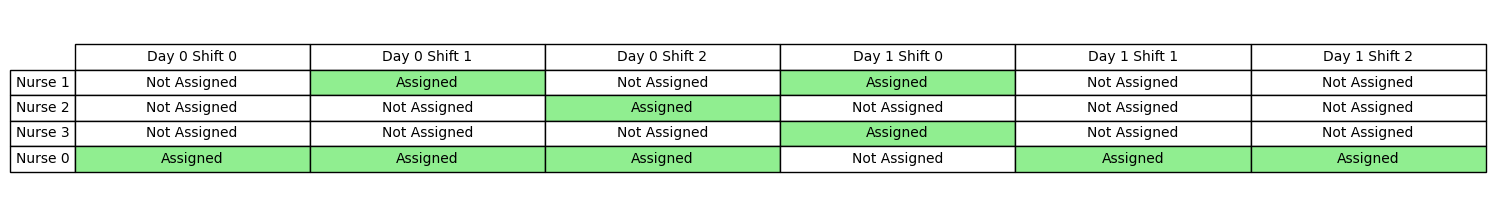

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) > (shifts[0,2,0]), (shifts[0,1,0]) == (shifts[1,0,0]), (shifts[0,1,0]) == (shifts[0,2,0]), (shifts[0,1,0]) != (shifts[1,0,1]), (shifts[0,1,0]) >= (shifts[0,2,0]), (shifts[0,1,0]) > (shifts[1,0,1]), (shifts[0,1,0]) >= (shifts[1,0,0]), (shifts[0,1,0]) > (shifts[1,0,0]), (shifts[0,1,0]) < (shifts[1,0,1])]
Query24: is this a solution?


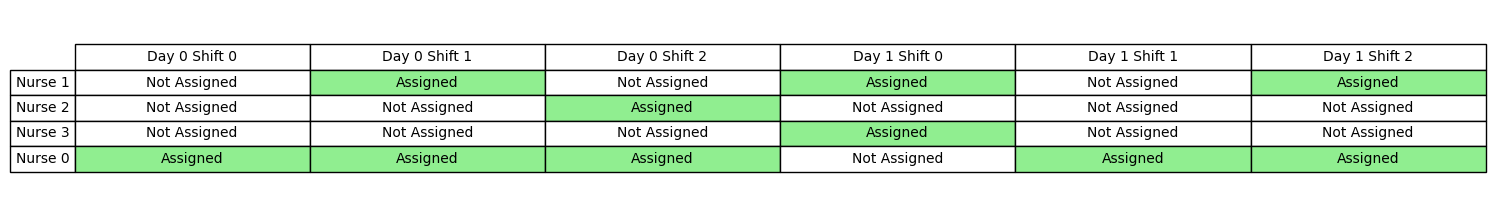

Answer:  No
Query25: is this a solution?


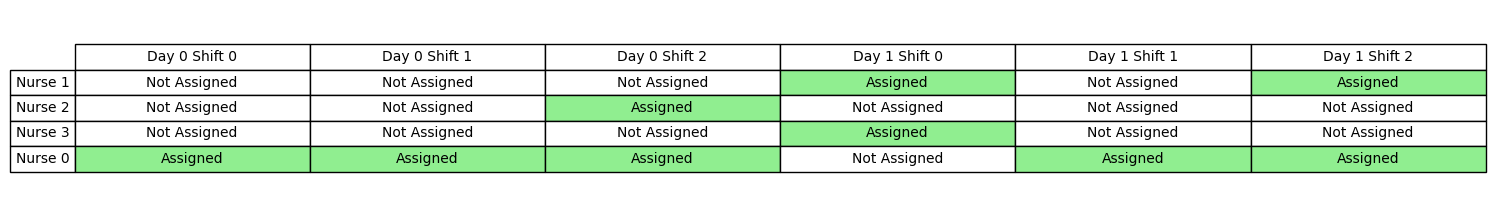

Answer:  No
Query26: is this a solution?


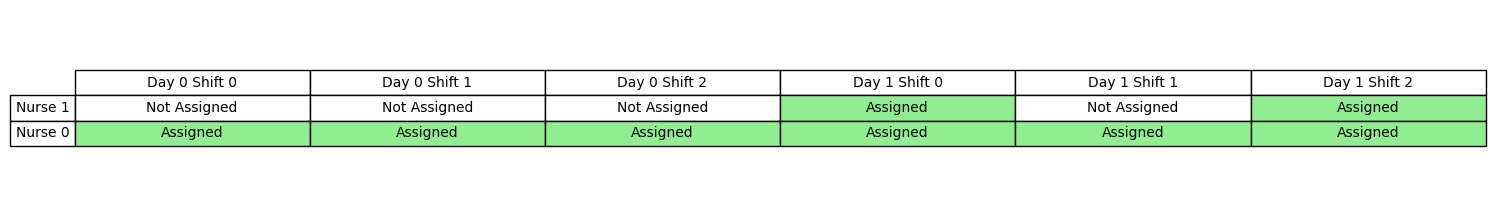

Answer:  No
Query27: is this a solution?


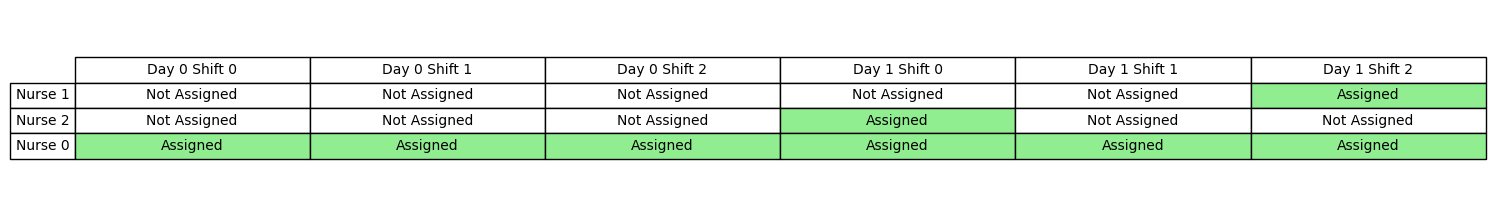

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) < (shifts[1,2,0])]
Query28: is this a solution?


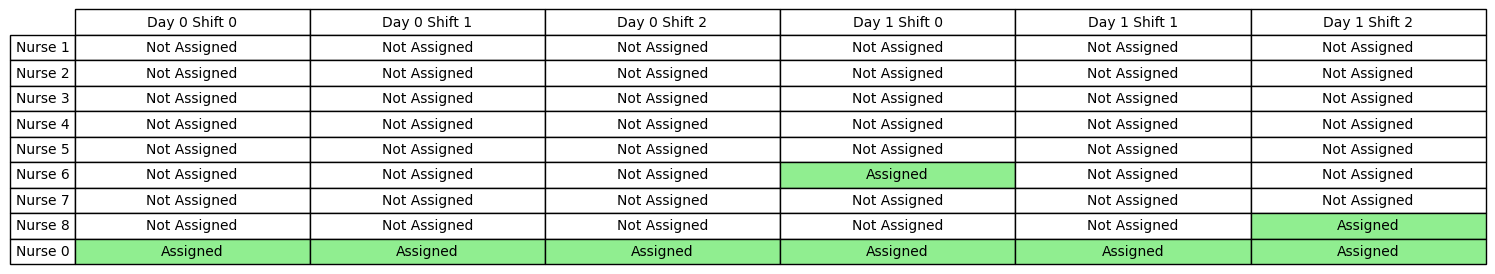

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) > (shifts[1,2,0])]
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[1,2,0])]
Size of CL:  4
Size of B:  367
Number of Queries:  29
Query29: is this a solution?


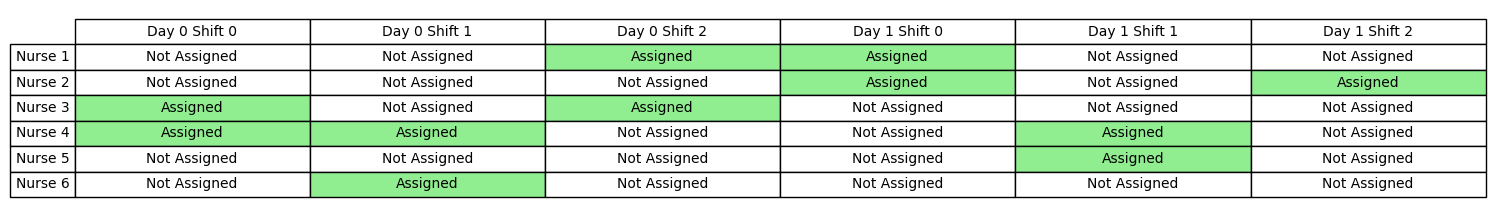

Answer:  No
Query30: is this a solution?


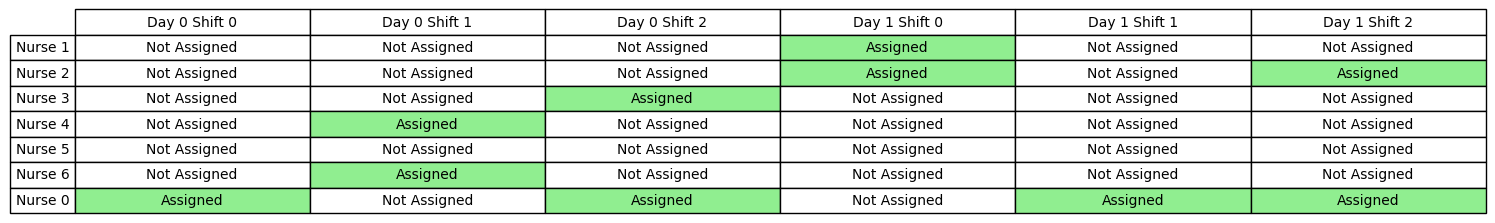

Answer:  No
Query31: is this a solution?


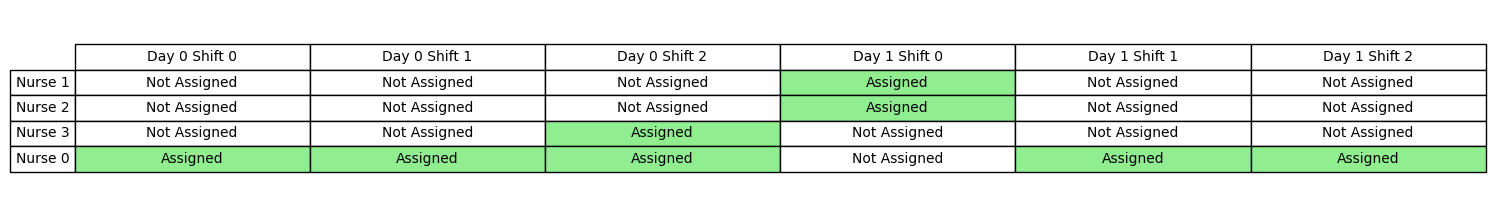

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) <= (shifts[1,0,0])]
Query32: is this a solution?


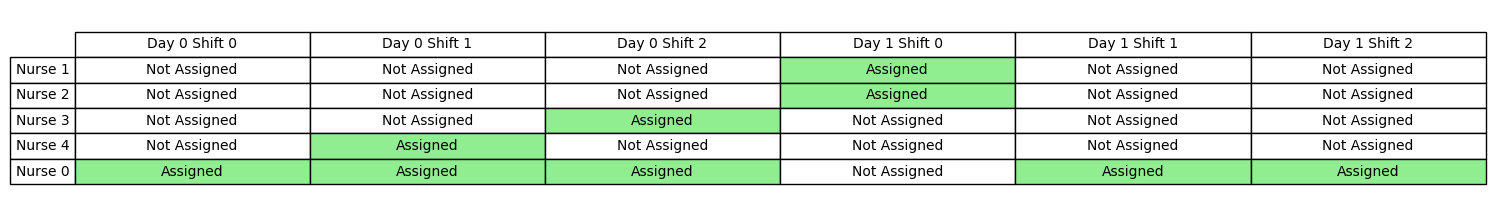

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) < (shifts[1,0,0]), (shifts[0,1,0]) < (shifts[0,2,0]), (shifts[0,1,0]) <= (shifts[0,2,0]), (shifts[0,1,0]) <= (shifts[1,0,0]), (shifts[0,1,0]) <= (shifts[1,0,1]), (shifts[0,1,0]) == (shifts[1,0,1])]
Query33: is this a solution?


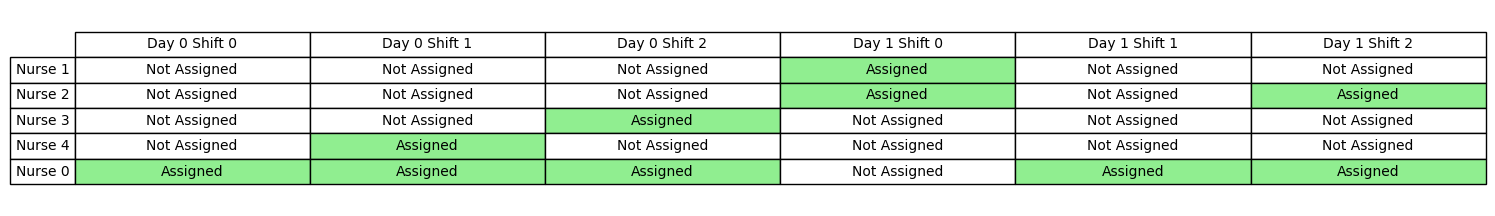

Answer:  No
Query34: is this a solution?


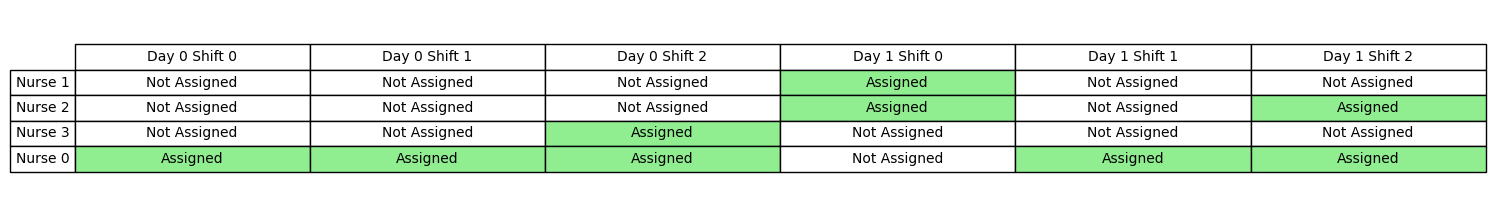

Answer:  No
Query35: is this a solution?


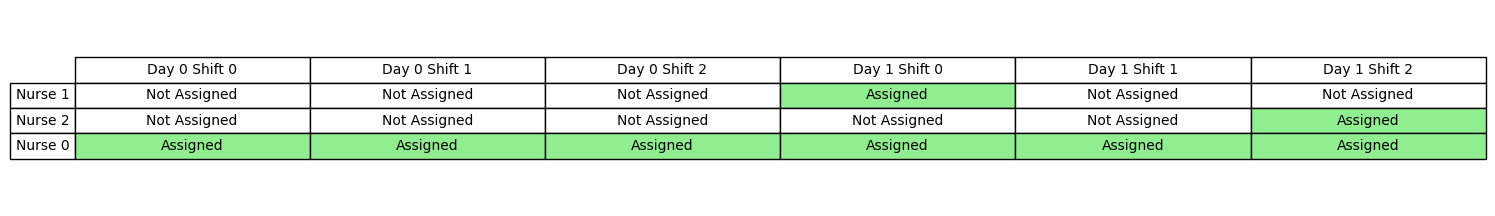

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) >= (shifts[1,2,0]), (shifts[1,0,1]) == (shifts[1,2,0])]
Query36: is this a solution?


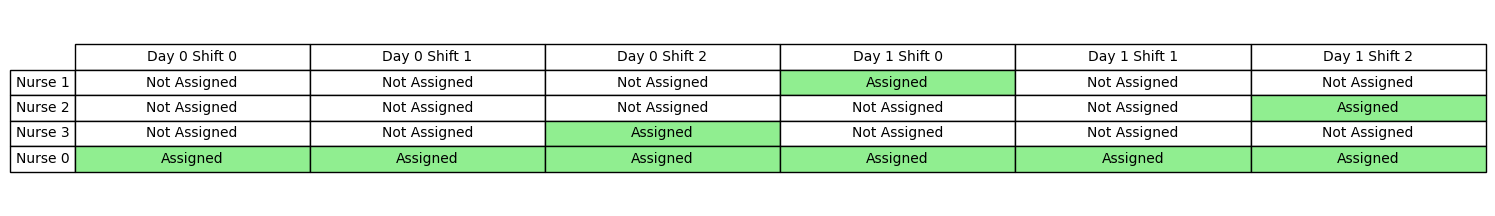

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) == (shifts[1,2,0]), (shifts[0,2,0]) <= (shifts[1,2,0]), (shifts[0,2,0]) < (shifts[1,2,0])]
Query37: is this a solution?


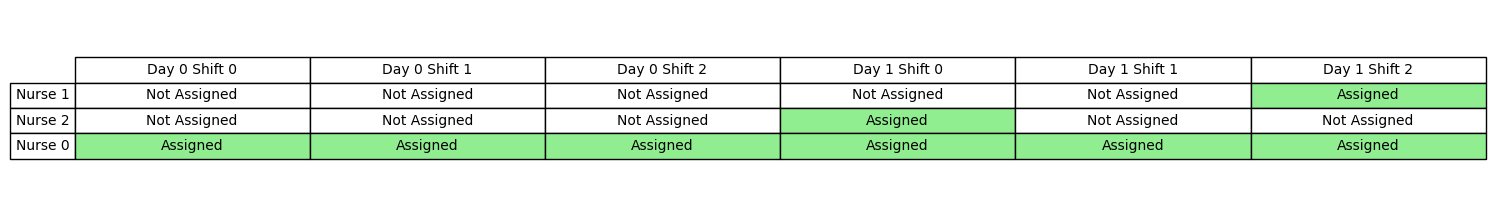

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) < (shifts[1,2,0])]
Query38: is this a solution?


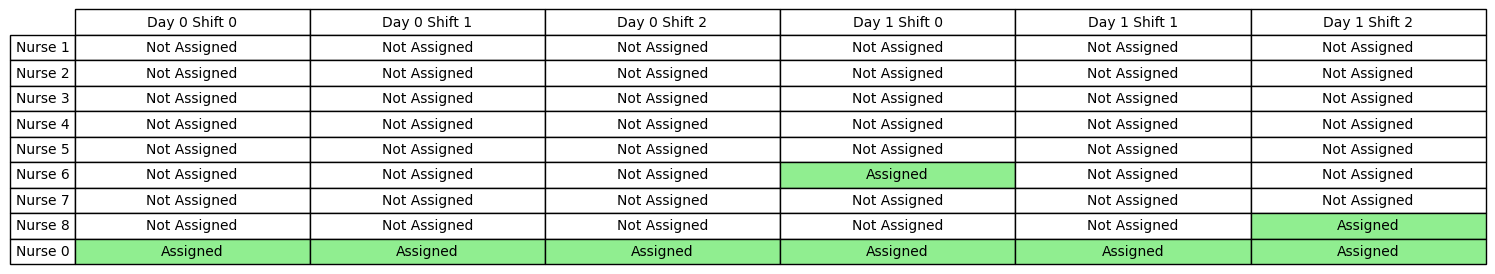

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) > (shifts[1,2,0])]
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[1,2,0])]
Size of CL:  5
Size of B:  352
Number of Queries:  39
Query39: is this a solution?


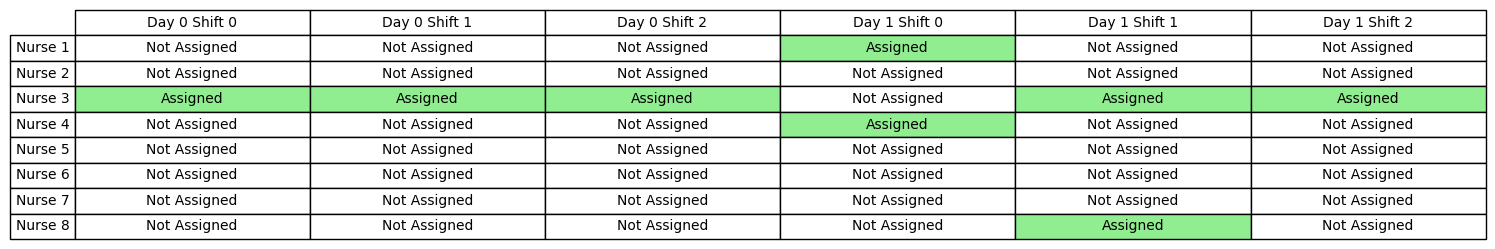

Answer:  No
Query40: is this a solution?


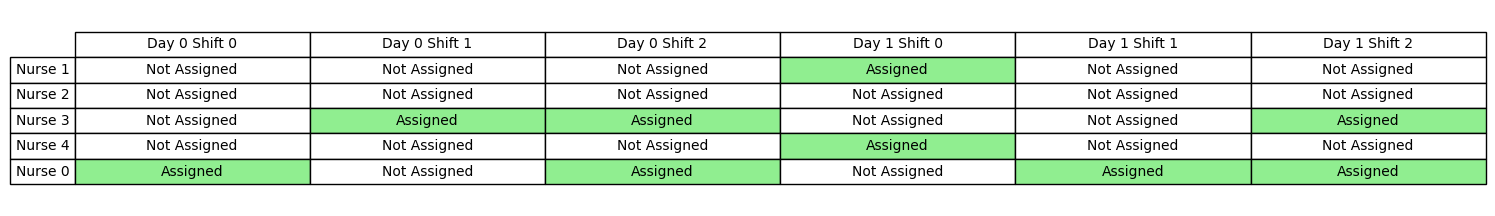

Answer:  No
Query41: is this a solution?


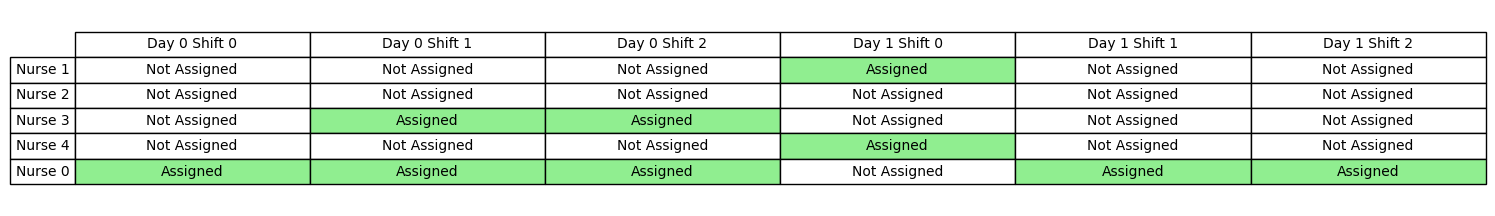

Answer:  No
Query42: is this a solution?


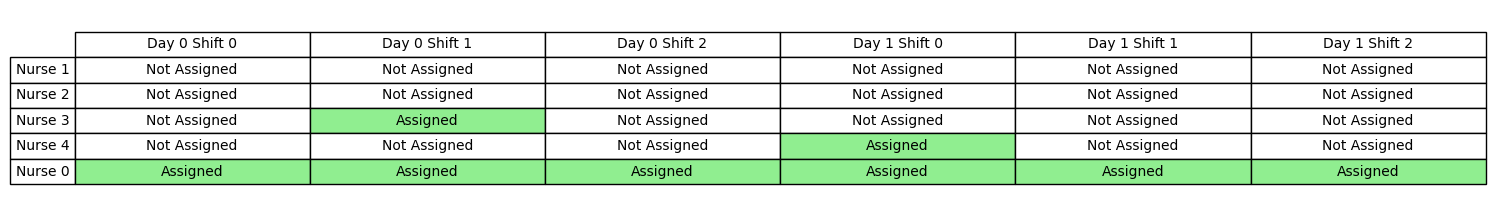

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) >= (shifts[1,0,1])]
adding the following constraints to C_L: [(shifts[0,1,0]) != (shifts[0,2,0])]
Size of CL:  6
Size of B:  350
Number of Queries:  43
Query43: is this a solution?


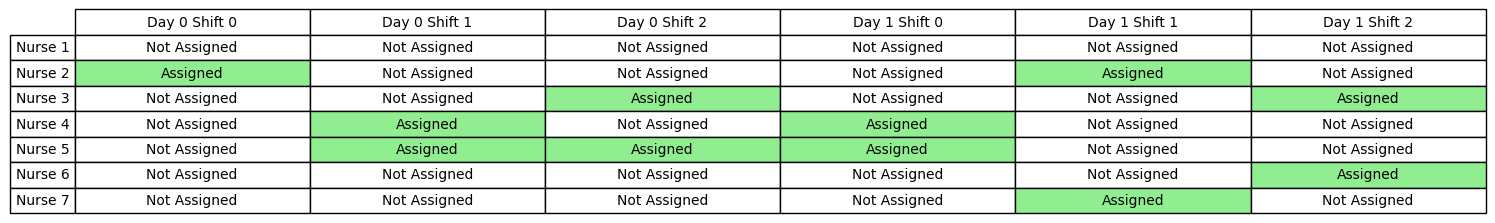

Answer:  No
Query44: is this a solution?


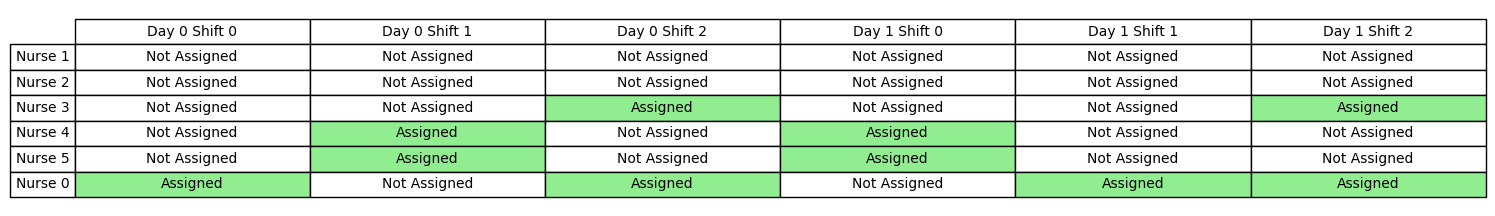

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) < (shifts[1,0,1]), (shifts[0,1,1]) < (shifts[1,2,0]), (shifts[0,2,0]) > (shifts[1,2,0]), (shifts[0,1,0]) > (shifts[0,1,1]), (shifts[0,1,0]) != (shifts[1,0,0]), (shifts[0,2,0]) != (shifts[1,2,0]), (shifts[0,1,1]) != (shifts[1,0,1]), (shifts[0,1,0]) < (shifts[1,2,0]), (shifts[0,1,1]) < (shifts[0,2,0]), (shifts[0,1,0]) == (shifts[1,2,0]), (shifts[1,0,0]) <= (shifts[1,2,0]), (shifts[0,1,1]) > (shifts[1,0,1]), (shifts[0,1,1]) <= (shifts[1,2,0]), (shifts[1,0,0]) == (shifts[1,2,0]), (shifts[0,1,1]) < (shifts[1,0,0]), (shifts[0,1,1]) <= (shifts[1,0,0]), (shifts[0,1,1]) == (shifts[1,0,0]), (shifts[0,1,0]) >= (shifts[0,1,1]), (shifts[0,1,1]) == (shifts[0,2,0]), (shifts[0,1,0]) == (shifts[0,1,1]), (shifts[0,1,0]) <= (shifts[1,2,0]), (shifts[0,1,1]) <= (shifts[0,2,0]), (shifts[0,1,1]) == (shifts[1,2,0]), (shifts[1,0,1]) <= (shifts[1,2,0])]
Query45: is this a solution?


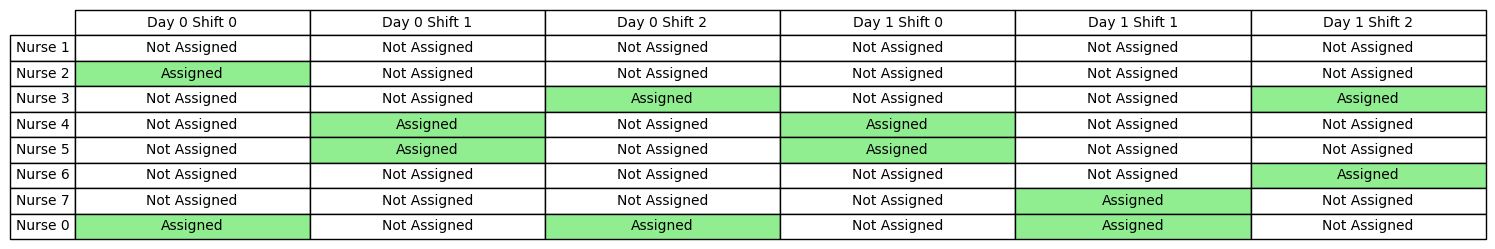

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) > (shifts[1,1,1]), (shifts[1,0,1]) > (shifts[1,2,1]), (shifts[0,2,0]) == (shifts[1,2,1]), (shifts[1,1,1]) < (shifts[1,2,0]), (shifts[0,0,1]) > (shifts[0,2,0]), (shifts[0,0,1]) == (shifts[1,2,0]), (shifts[0,0,1]) > (shifts[0,1,0]), (shifts[0,1,1]) >= (shifts[1,1,1]), (shifts[0,0,1]) > (shifts[1,2,1]), (shifts[0,0,1]) == (shifts[1,0,1]), (shifts[1,0,0]) > (shifts[1,2,1]), (shifts[0,1,0]) > (shifts[1,1,1]), (shifts[0,1,1]) > (shifts[1,2,1]), (shifts[0,2,0]) >= (shifts[1,2,1]), (shifts[0,0,1]) >= (shifts[1,2,0]), (shifts[1,0,1]) > (shifts[1,1,1]), (shifts[0,1,1]) == (shifts[1,2,1]), (shifts[0,0,1]) >= (shifts[0,2,0]), (shifts[1,0,1]) == (shifts[1,2,1]), (shifts[0,0,1]) == (shifts[0,1,0]), (shifts[1,1,1]) < (shifts[1,2,1]), (shifts[0,2,0]) == (shifts[1,1,1]), (shifts[0,0,1]) == (shifts[1,0,0]), (shifts[1,1,1]) <= (shifts[1,2,0]), (shifts[1,1,1]) <= (shifts[1,2,1]), (shifts[0,0,1]) == (shifts[0,2,0]), (shifts[0,0,1])

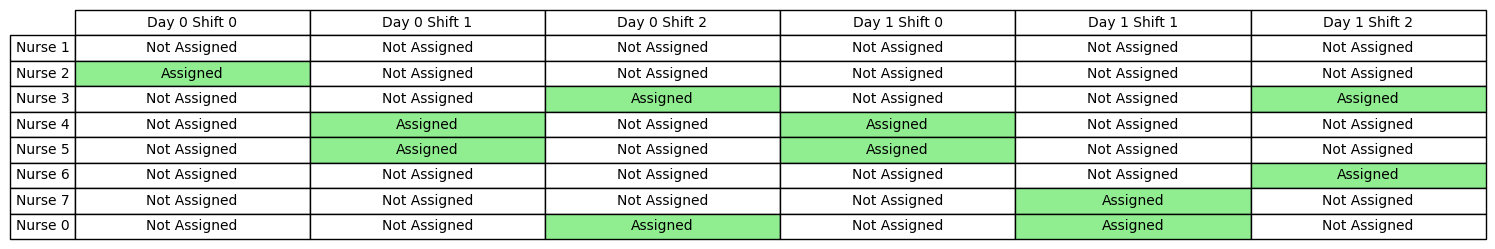

Answer:  No
Query47: is this a solution?


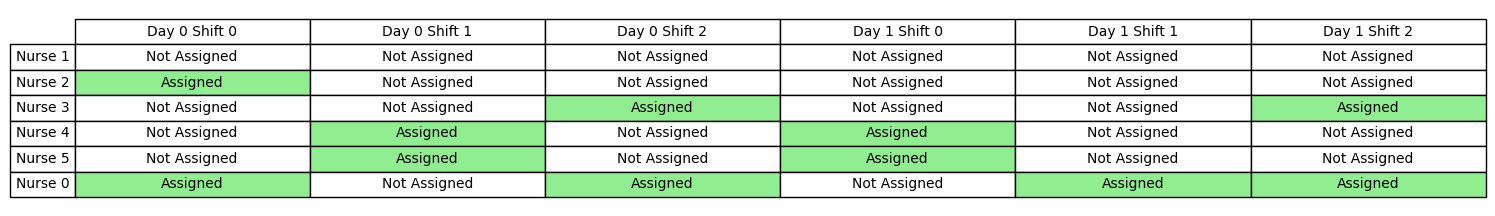

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) == (shifts[1,0,0]), (shifts[0,0,0]) > (shifts[0,1,0]), (shifts[0,0,0]) == (shifts[0,1,0]), (shifts[0,0,0]) > (shifts[1,2,0]), (shifts[0,0,0]) >= (shifts[0,1,1]), (shifts[0,0,0]) > (shifts[0,1,1]), (shifts[0,0,0]) == (shifts[0,2,0]), (shifts[0,0,0]) >= (shifts[0,1,0]), (shifts[0,0,0]) == (shifts[0,1,1]), (shifts[0,0,0]) >= (shifts[1,0,1]), (shifts[0,0,0]) == (shifts[1,0,1]), (shifts[0,0,0]) > (shifts[1,0,1]), (shifts[0,0,0]) >= (shifts[1,0,0]), (shifts[0,0,0]) >= (shifts[0,2,0]), (shifts[0,0,0]) > (shifts[0,2,0]), (shifts[0,0,0]) == (shifts[1,2,0]), (shifts[0,0,0]) >= (shifts[1,2,0]), (shifts[0,0,0]) > (shifts[1,0,0])]
Query48: is this a solution?


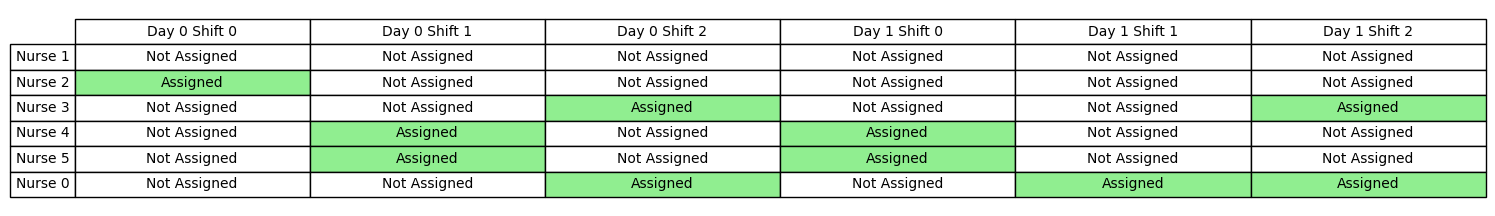

Answer:  No
Query49: is this a solution?


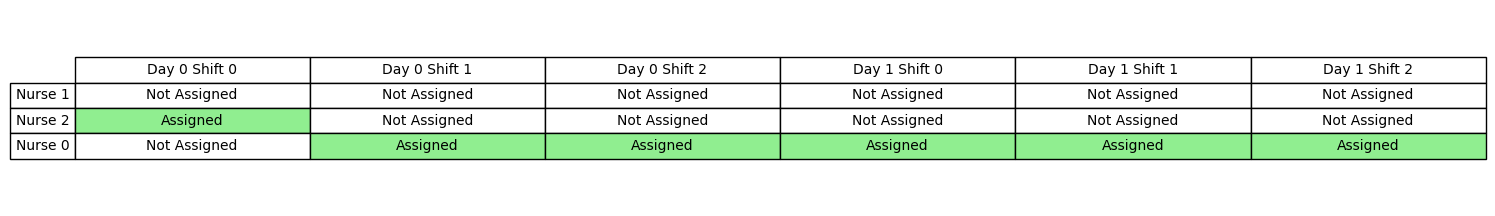

Answer:  No
Query50: is this a solution?


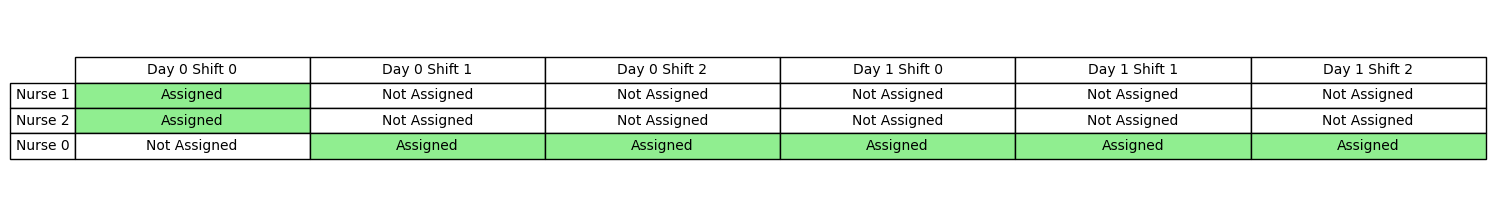

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) > (shifts[0,0,1])]
Query51: is this a solution?


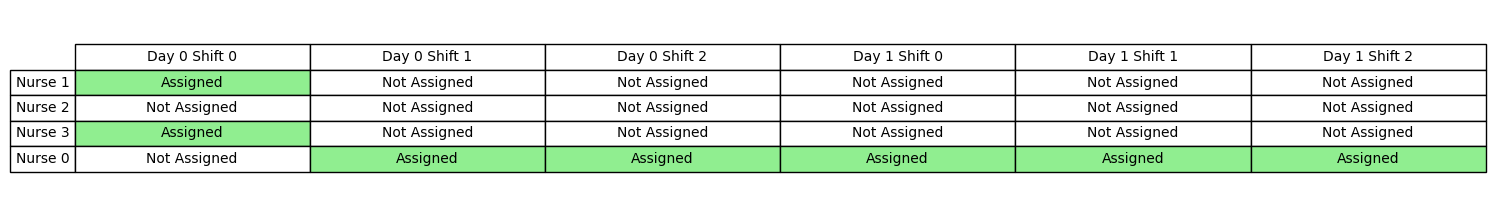

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) < (shifts[0,0,1])]
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,0,1])]
Size of CL:  7
Size of B:  242
Number of Queries:  52
Query52: is this a solution?


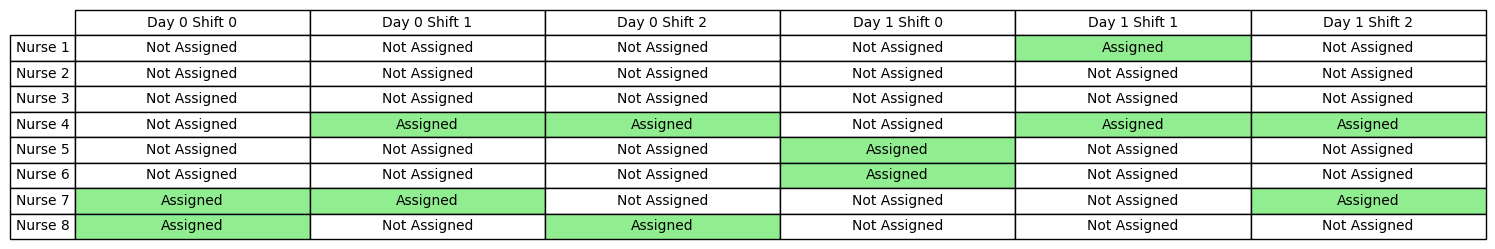

Answer:  No
Query53: is this a solution?


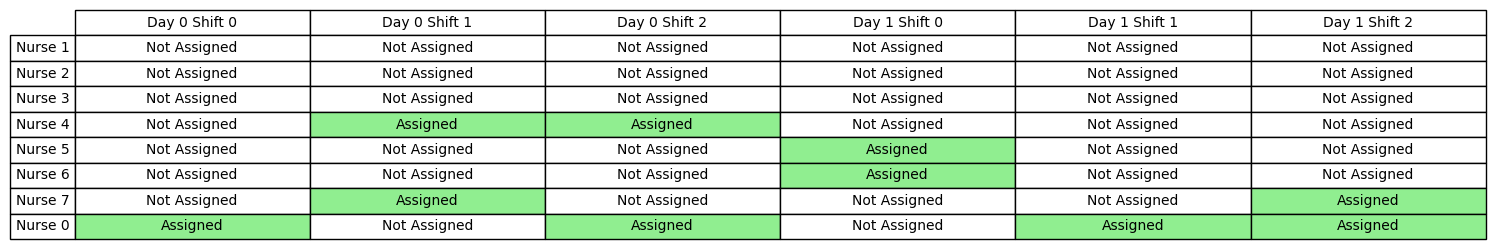

Answer:  No
Query54: is this a solution?


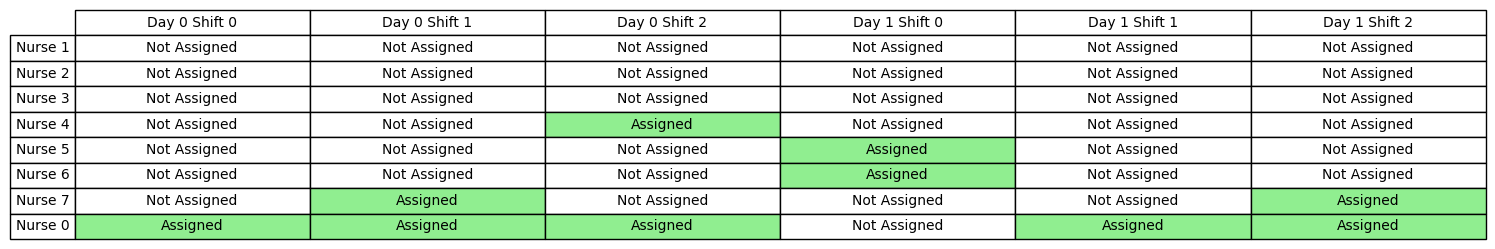

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) >= (shifts[1,2,0]), (shifts[0,1,0]) != (shifts[1,2,0]), (shifts[0,1,0]) > (shifts[1,2,0]), (shifts[1,0,0]) >= (shifts[1,2,0])]
Query55: is this a solution?


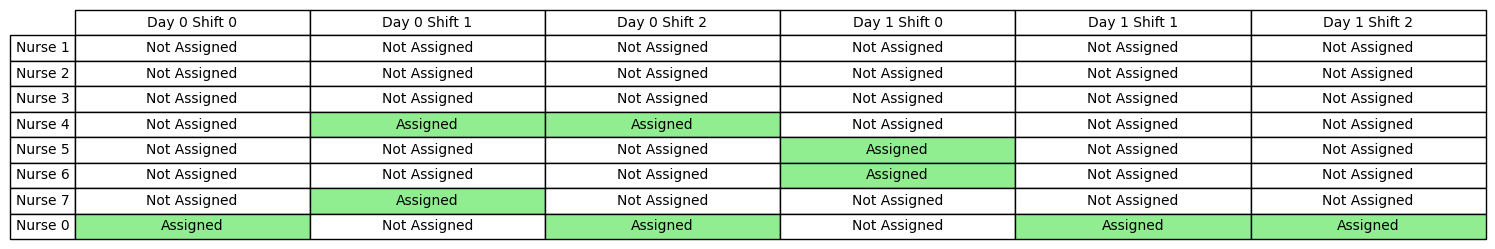

Answer:  No
Query56: is this a solution?


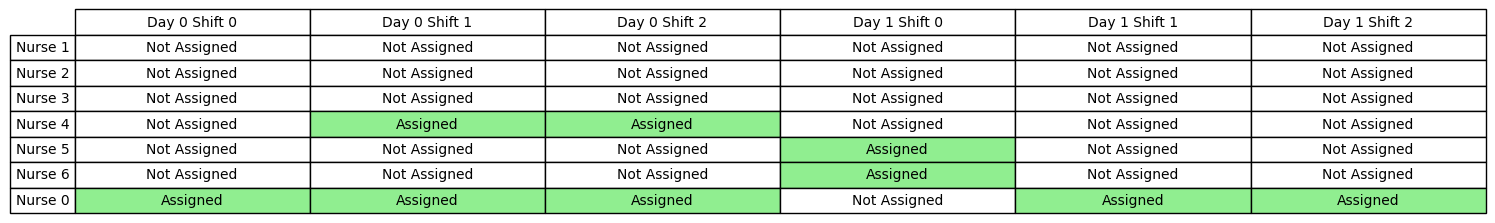

Answer:  No
Query57: is this a solution?


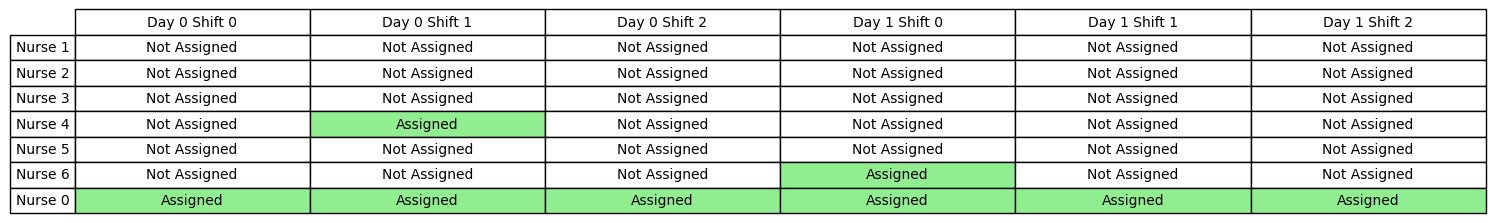

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) == (shifts[1,0,1]), (shifts[0,1,1]) >= (shifts[1,0,1])]
Query58: is this a solution?


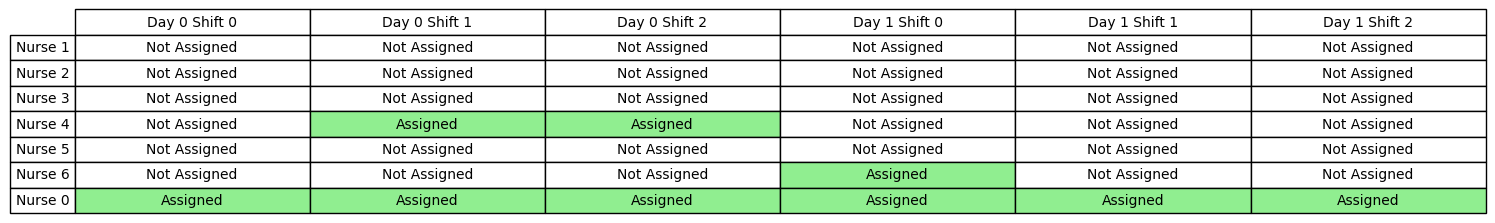

Answer:  No
Query59: is this a solution?


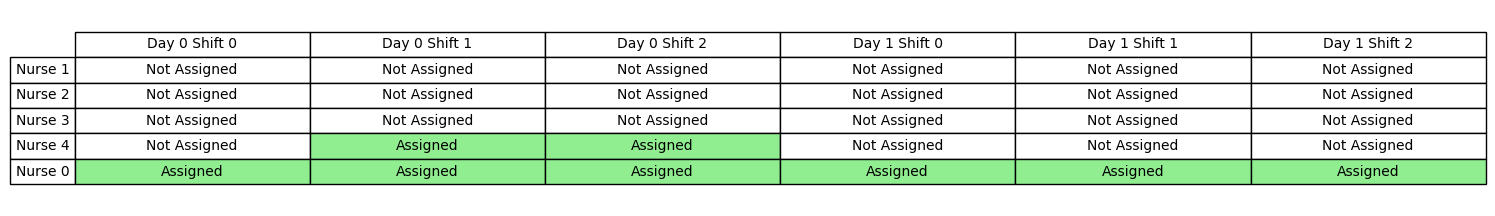

Answer:  No
Query60: is this a solution?


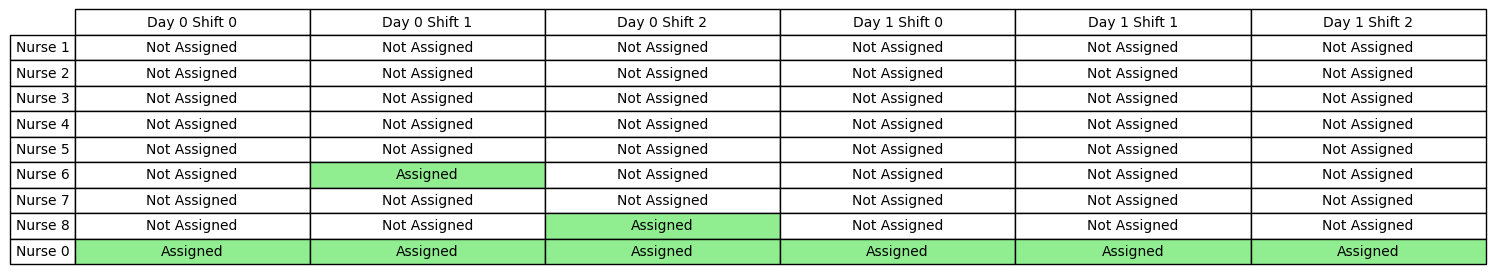

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) > (shifts[0,2,0])]
adding the following constraints to C_L: [(shifts[0,1,1]) != (shifts[0,2,0])]
Size of CL:  8
Size of B:  234
Number of Queries:  61
Query61: is this a solution?


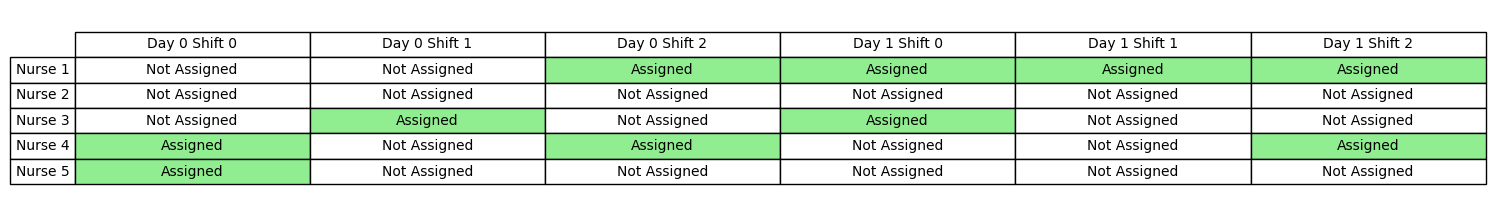

Answer:  No
Query62: is this a solution?


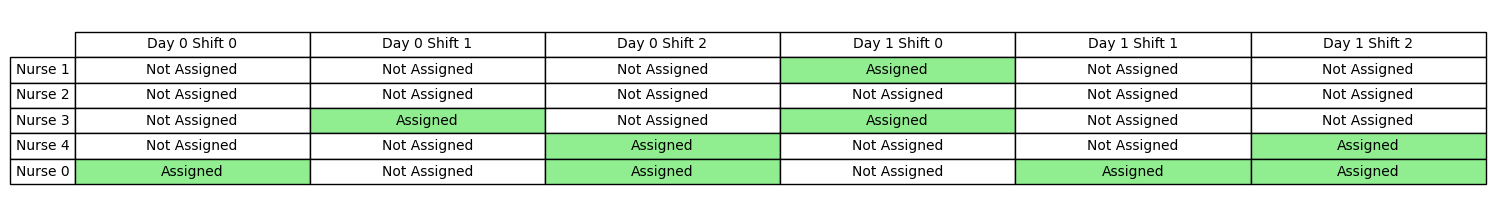

Answer:  No
Query63: is this a solution?


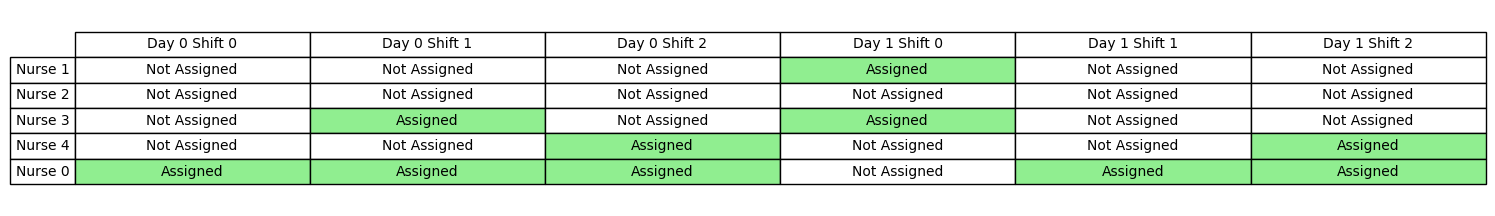

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) >= (shifts[1,2,0])]
Query64: is this a solution?


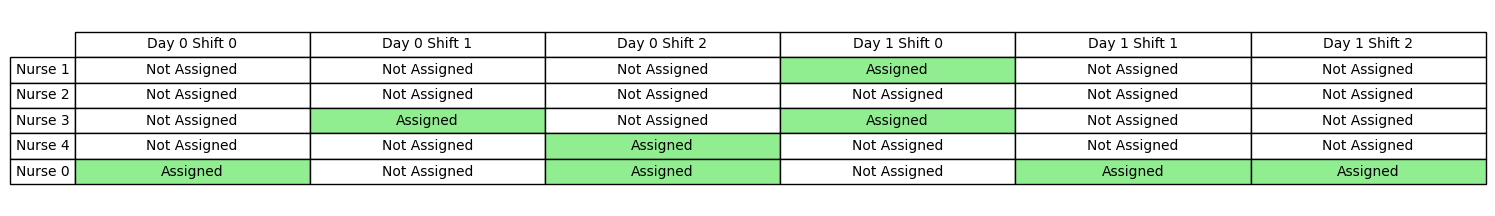

Answer:  No
Query65: is this a solution?


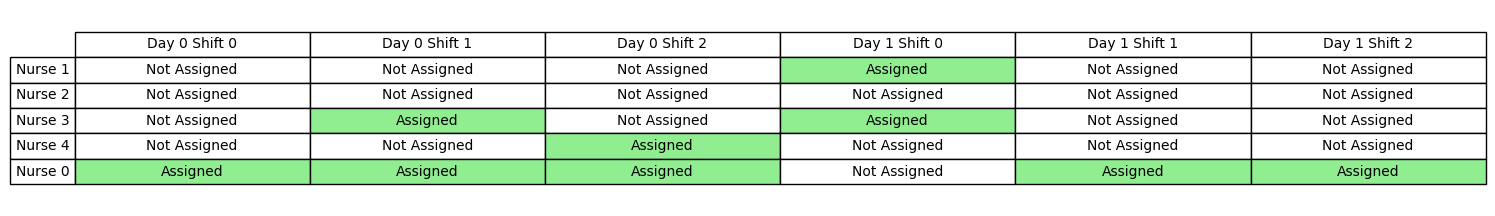

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) <= (shifts[1,0,1]), (shifts[0,1,1]) != (shifts[1,0,0]), (shifts[0,1,1]) > (shifts[1,0,0]), (shifts[0,1,1]) >= (shifts[0,2,0])]
Query66: is this a solution?


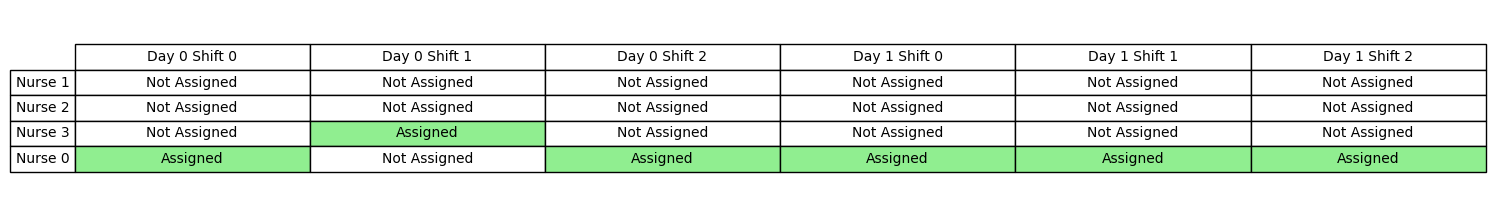

Answer:  No
Query67: is this a solution?


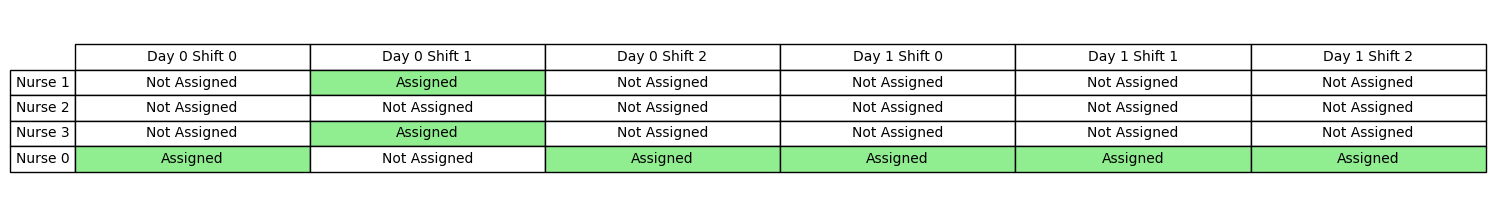

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) < (shifts[0,1,1])]
adding the following constraints to C_L: [(shifts[0,1,0]) != (shifts[0,1,1])]
Size of CL:  9
Size of B:  227
Number of Queries:  68
Query68: is this a solution?


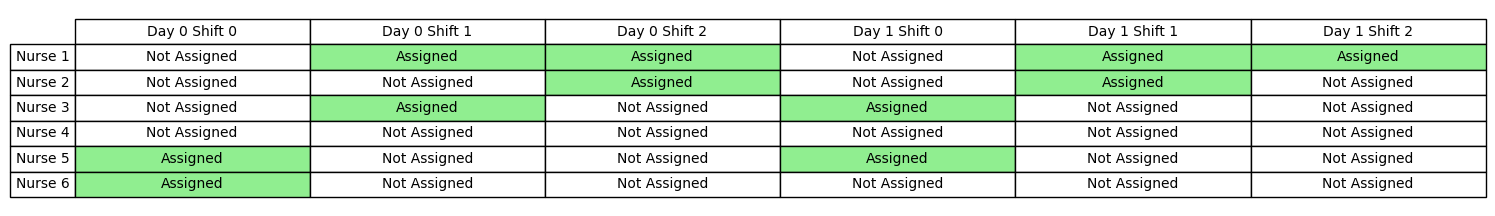

Answer:  No
Query69: is this a solution?


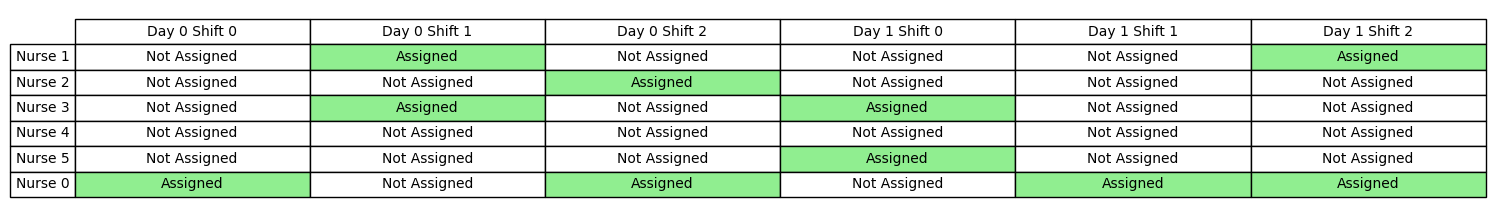

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) <= (shifts[0,1,1]), (shifts[0,1,1]) >= (shifts[1,0,0]), (shifts[0,1,1]) != (shifts[1,2,0]), (shifts[0,1,1]) > (shifts[1,2,0])]
Query70: is this a solution?


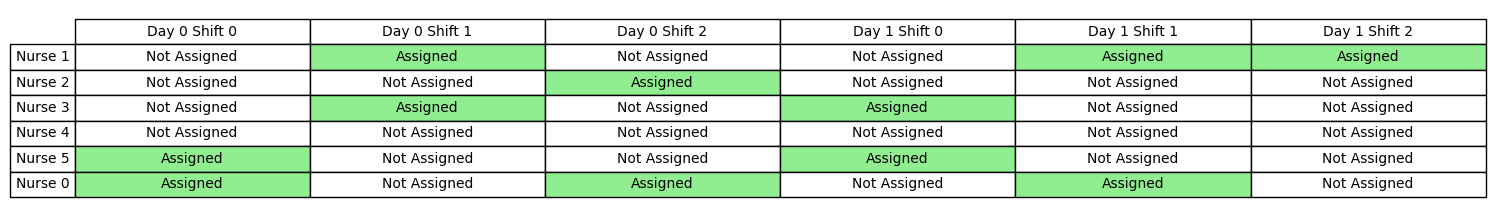

Answer:  No
Query71: is this a solution?


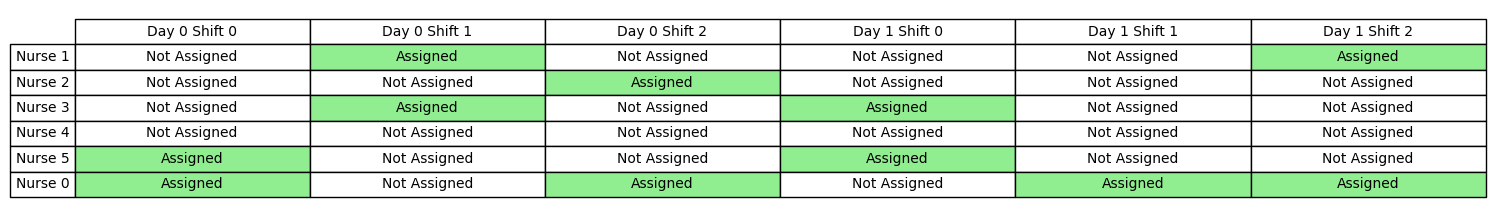

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) <= (shifts[0,1,0]), (shifts[0,0,1]) < (shifts[1,0,0]), (shifts[0,0,1]) <= (shifts[0,1,1]), (shifts[0,0,1]) <= (shifts[0,2,0]), (shifts[0,0,1]) < (shifts[0,1,0]), (shifts[0,0,1]) < (shifts[1,2,0]), (shifts[0,0,1]) < (shifts[1,0,1]), (shifts[0,0,1]) != (shifts[1,0,0]), (shifts[0,0,1]) < (shifts[0,2,0]), (shifts[0,0,1]) < (shifts[0,1,1]), (shifts[0,0,1]) <= (shifts[1,2,0]), (shifts[0,0,1]) <= (shifts[1,0,1])]
Query72: is this a solution?


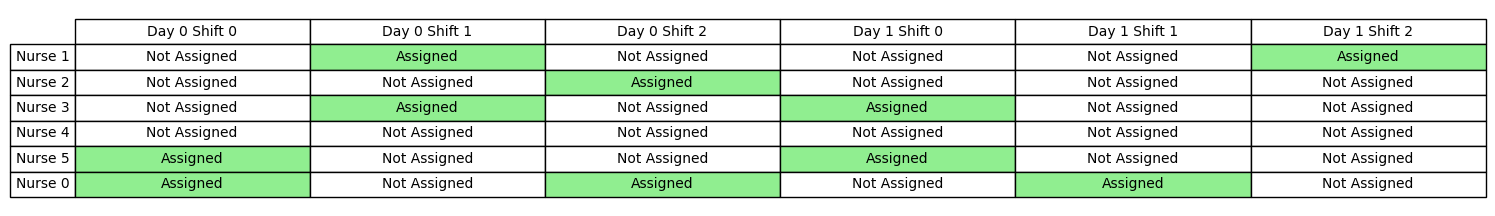

Answer:  No
Query73: is this a solution?


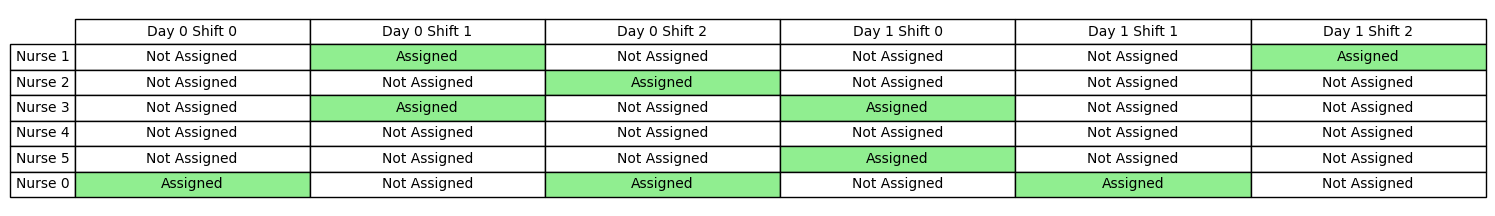

Answer:  No
Query74: is this a solution?


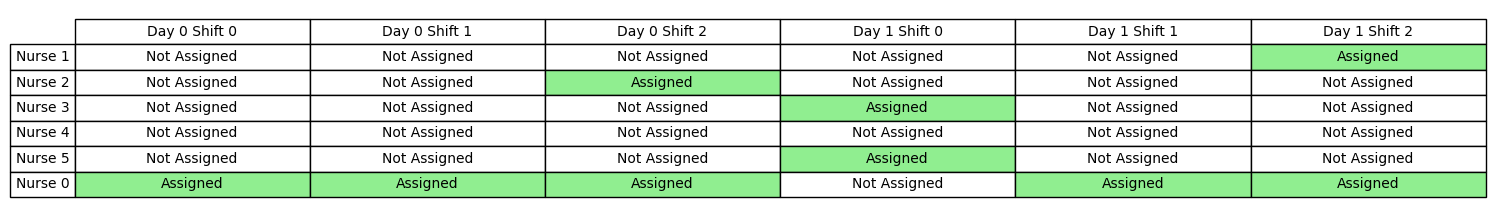

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) <= (shifts[1,2,1]), (shifts[0,2,0]) < (shifts[1,2,1]), (shifts[0,2,0]) <= (shifts[1,2,1]), (shifts[1,0,0]) < (shifts[1,2,1]), (shifts[1,0,1]) < (shifts[1,2,1]), (shifts[1,0,1]) <= (shifts[1,2,1])]
Query75: is this a solution?


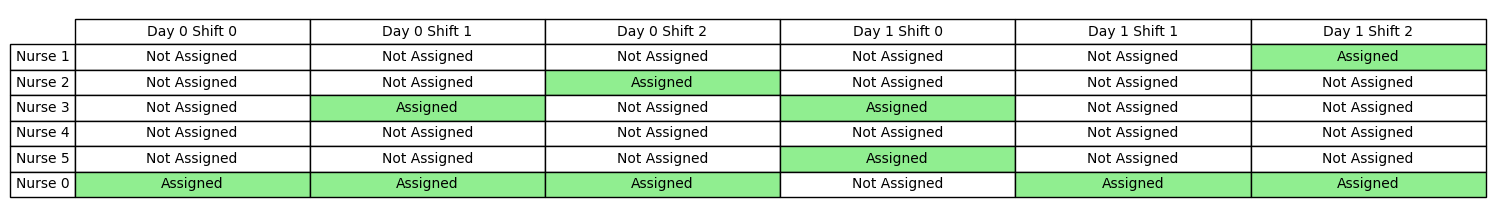

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) <= (shifts[1,2,1]), (shifts[0,1,0]) < (shifts[1,2,1])]
Query76: is this a solution?


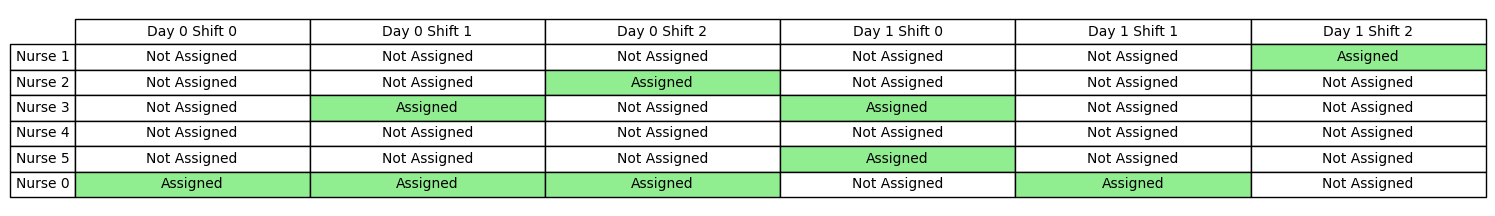

Answer:  No
Query77: is this a solution?


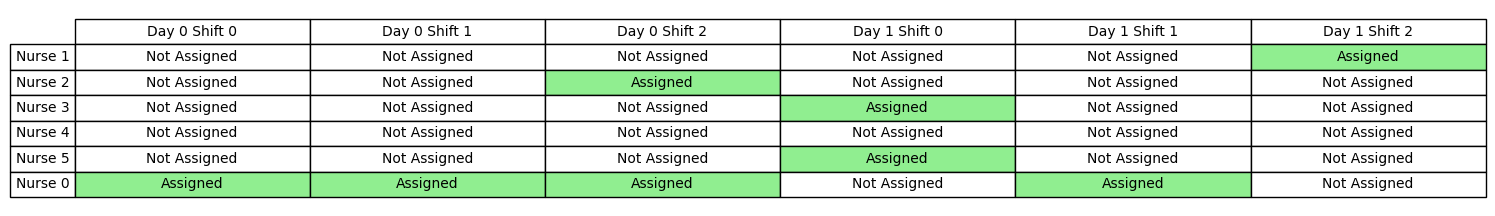

Answer:  No
Query78: is this a solution?


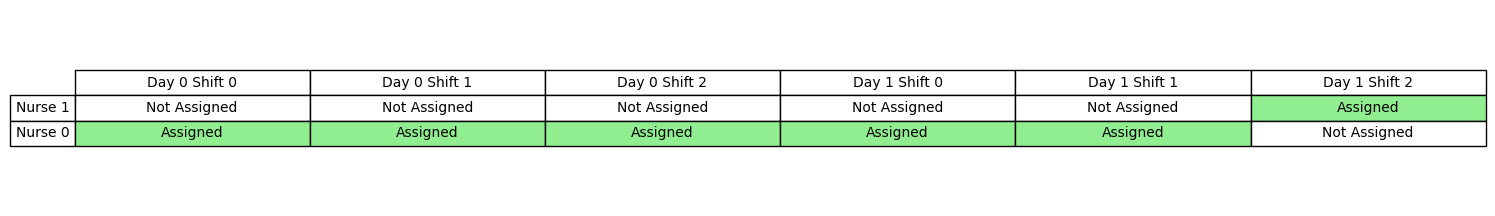

Answer:  No
Query79: is this a solution?


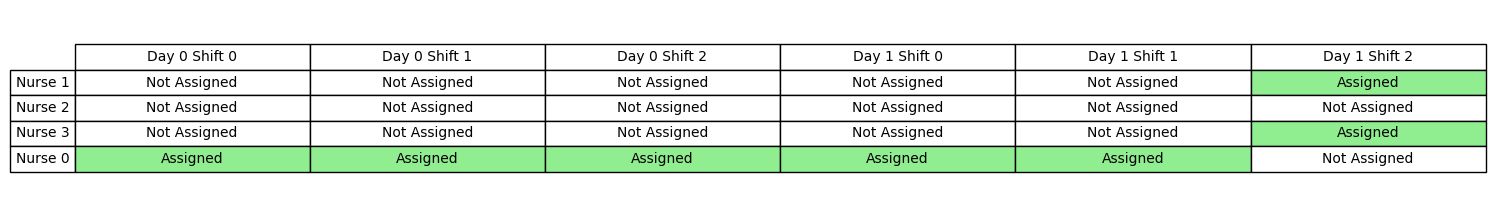

Answer:  Yes
removing the following constraints from bias: [(shifts[1,2,0]) < (shifts[1,2,1])]
adding the following constraints to C_L: [(shifts[1,2,0]) != (shifts[1,2,1])]
Size of CL:  10
Size of B:  201
Number of Queries:  80
Query80: is this a solution?


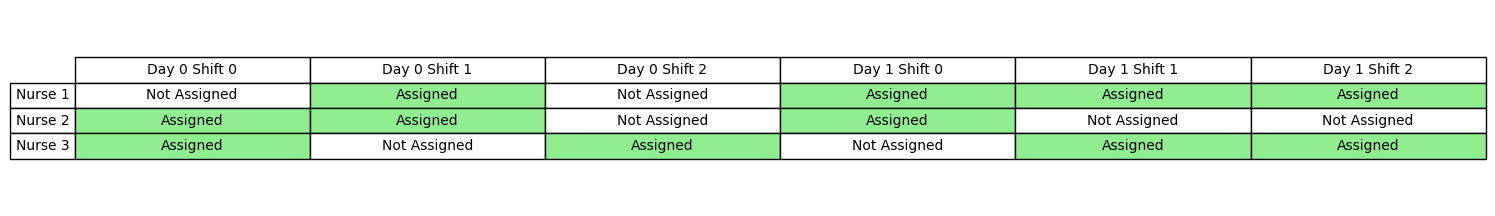

Answer:  No
Query81: is this a solution?


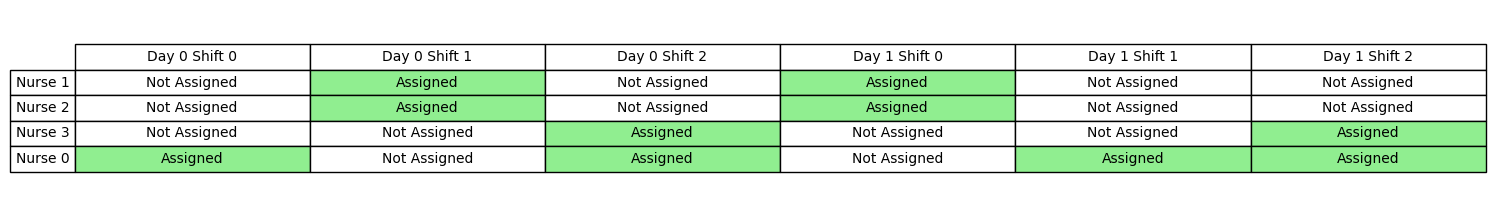

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) >= (shifts[1,2,0])]
Query82: is this a solution?


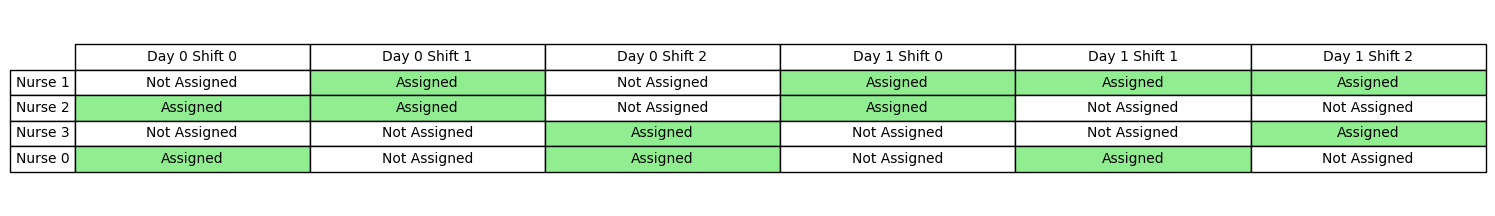

Answer:  No
Query83: is this a solution?


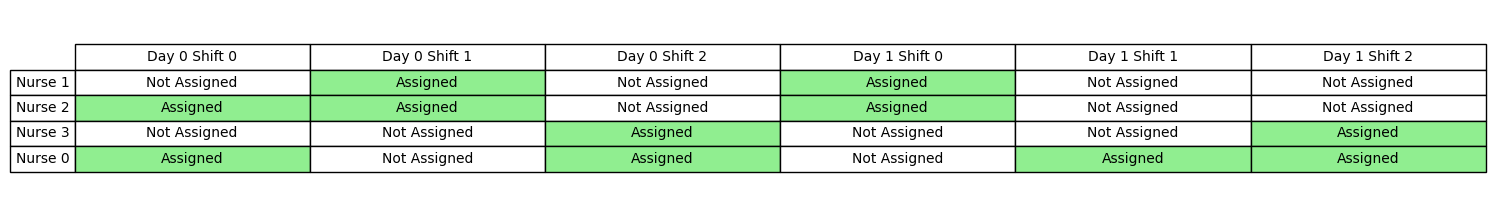

Answer:  No
Query84: is this a solution?


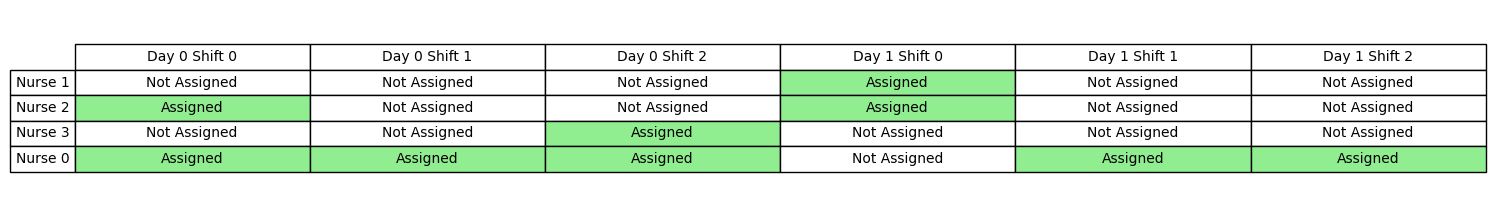

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) != (shifts[1,0,1]), (shifts[0,0,1]) <= (shifts[1,0,0])]
adding the following constraints to C_L: [(shifts[0,0,1]) != (shifts[0,1,1])]
Size of CL:  11
Size of B:  197
Number of Queries:  85
Query85: is this a solution?


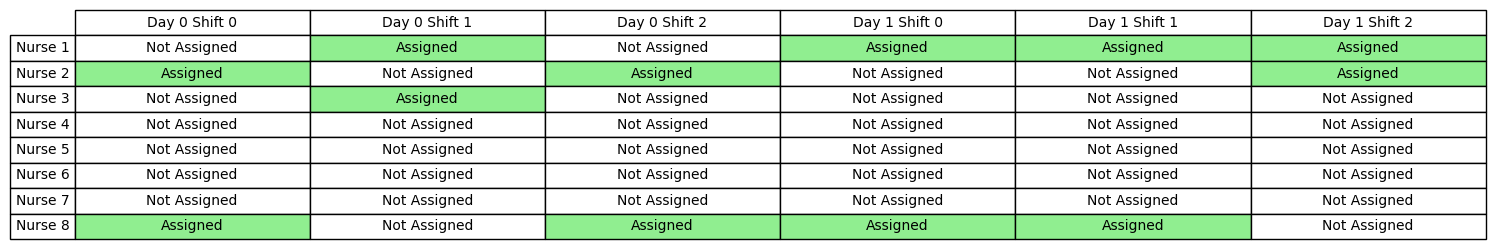

Answer:  No
Query86: is this a solution?


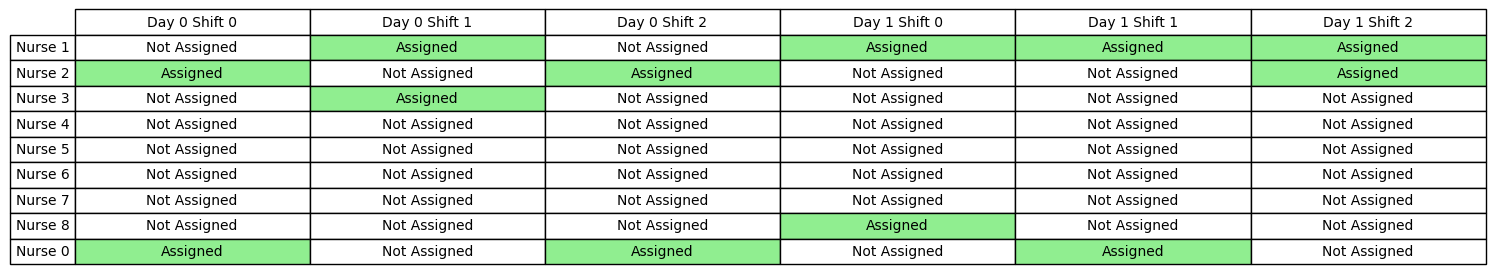

Answer:  No
Query87: is this a solution?


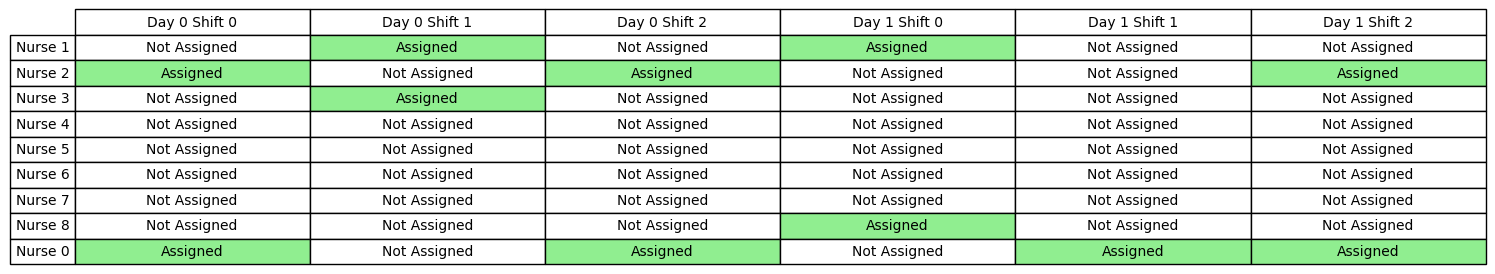

Answer:  No
Query88: is this a solution?


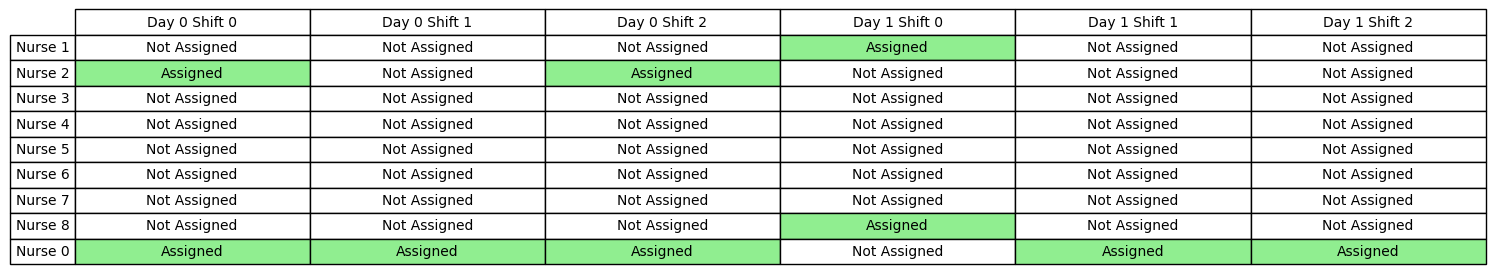

Answer:  No
adding the following constraints to C_L: [(shifts[0,0,1]) != (shifts[0,2,0])]
Size of CL:  12
Size of B:  196
Number of Queries:  89
Query89: is this a solution?


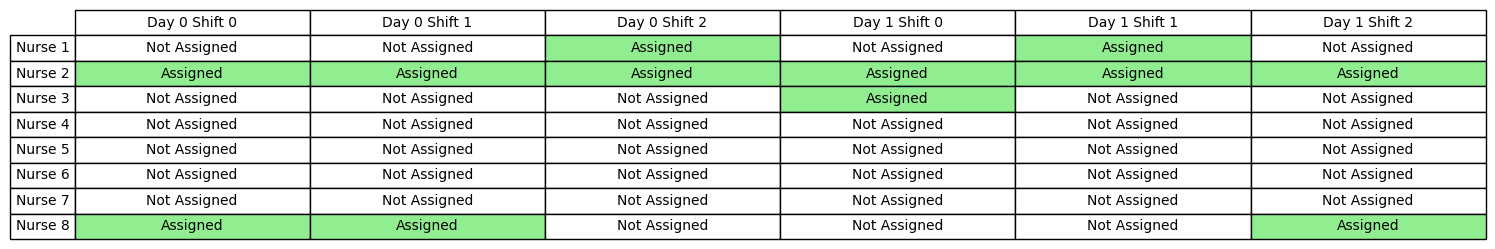

Answer:  No
Query90: is this a solution?


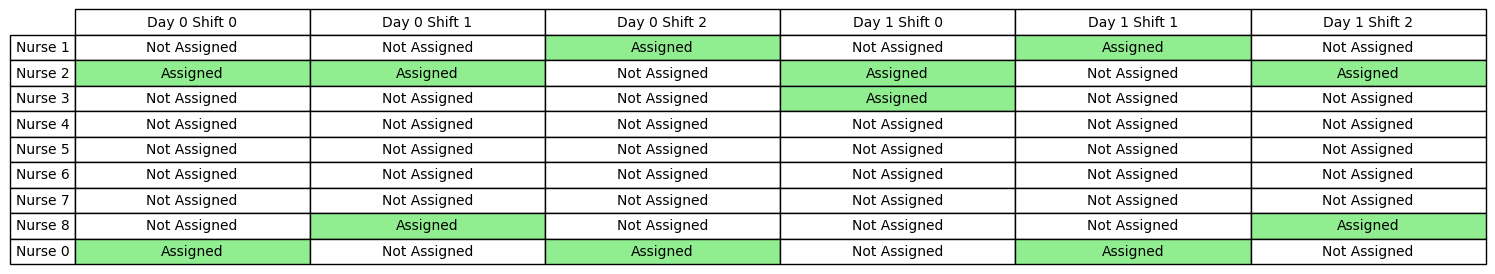

Answer:  No
Query91: is this a solution?


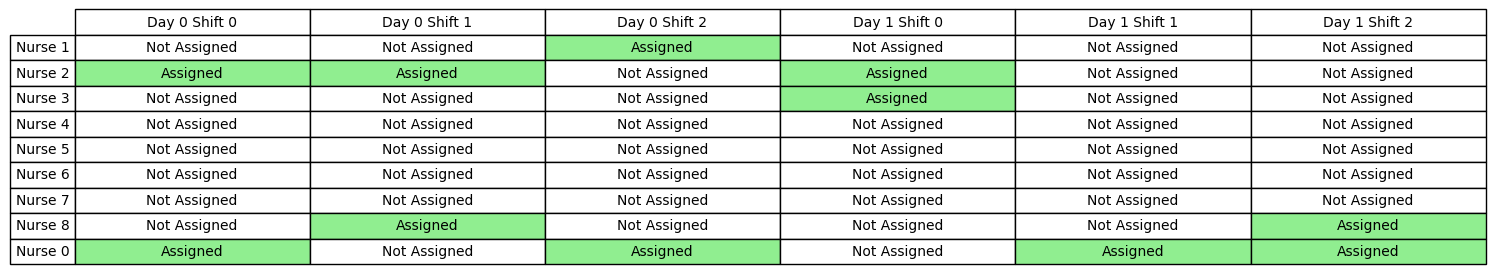

Answer:  No
adding the following constraints to C_L: [(shifts[0,0,1]) != (shifts[0,1,0])]
Size of CL:  13
Size of B:  195
Number of Queries:  92
Query92: is this a solution?


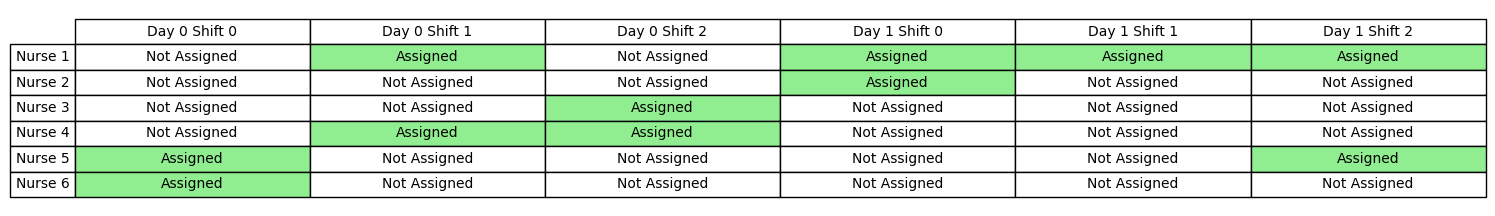

Answer:  No
Query93: is this a solution?


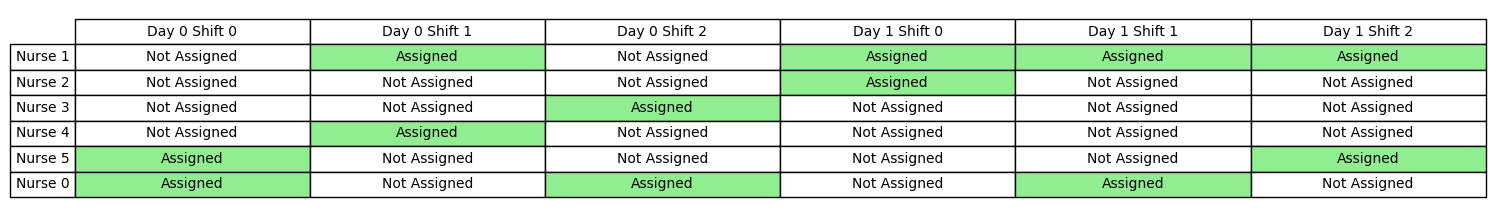

Answer:  No
Query94: is this a solution?


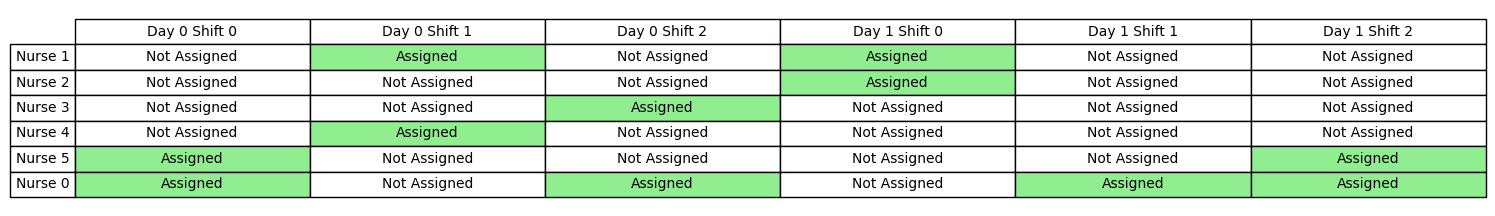

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) != (shifts[1,2,0])]
Query95: is this a solution?


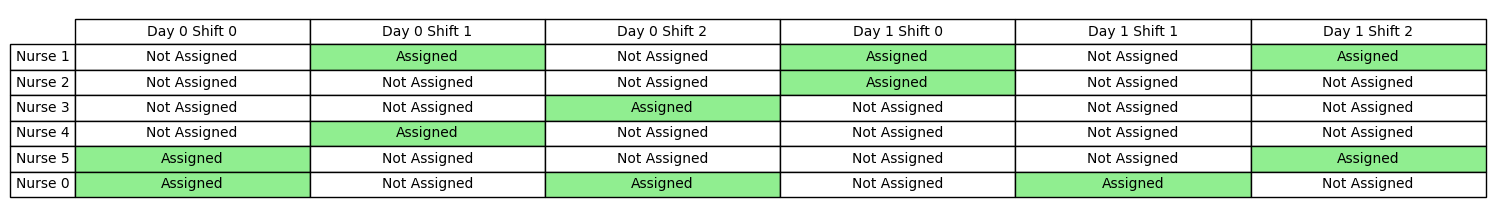

Answer:  No
Query96: is this a solution?


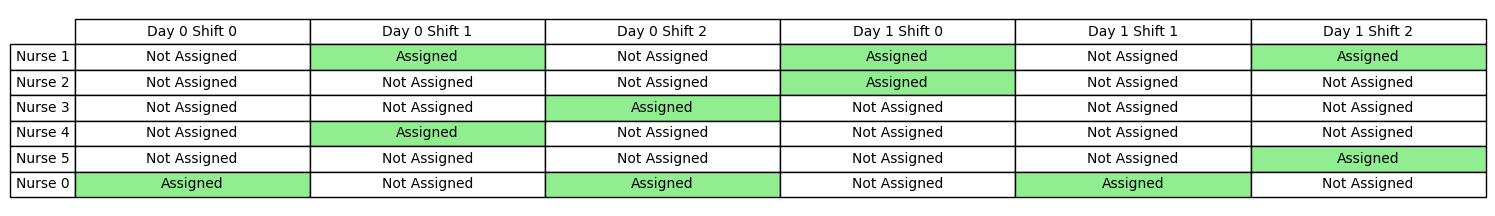

Answer:  No
Query97: is this a solution?


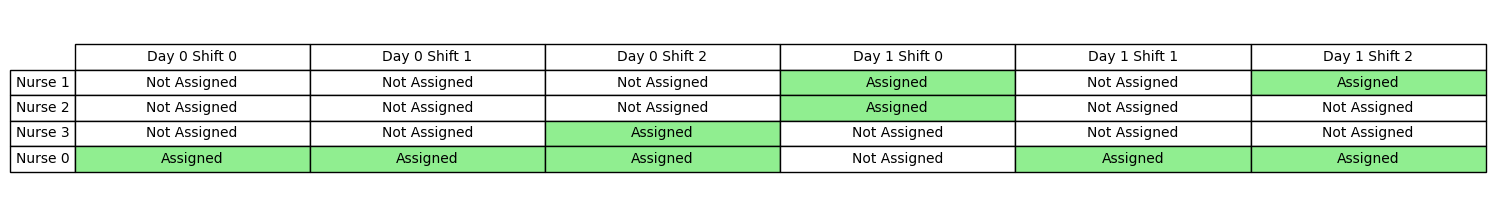

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[1,2,1])]
Size of CL:  14
Size of B:  193
Number of Queries:  98
Query98: is this a solution?


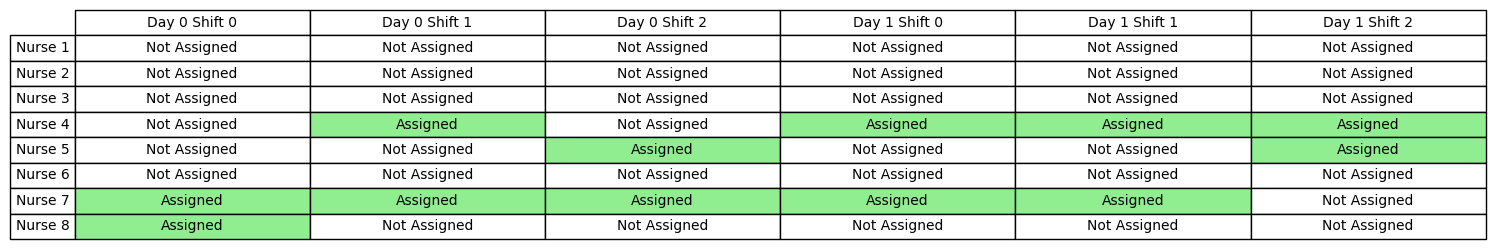

Answer:  No
Query99: is this a solution?


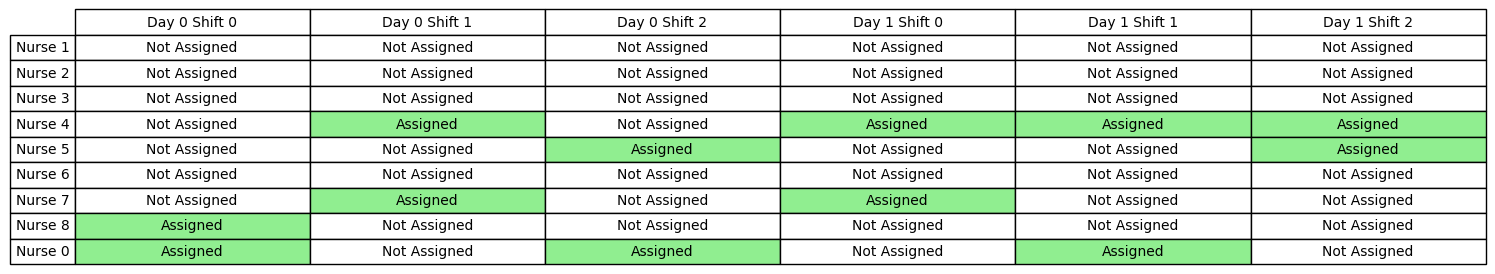

Answer:  No
Query100: is this a solution?


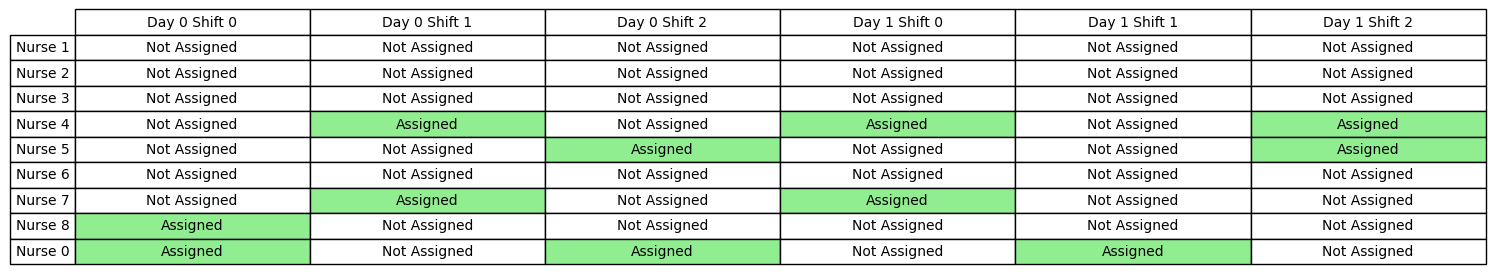

Answer:  No
Query101: is this a solution?


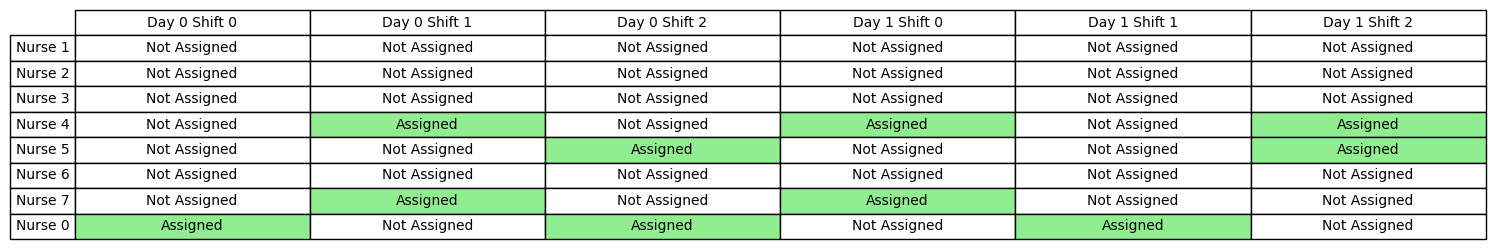

Answer:  No
Query102: is this a solution?


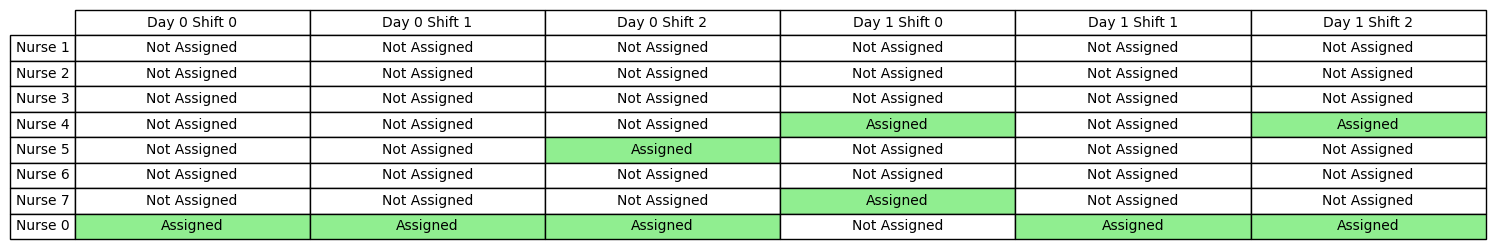

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[1,2,1])]
Size of CL:  15
Size of B:  192
Number of Queries:  103
Query103: is this a solution?


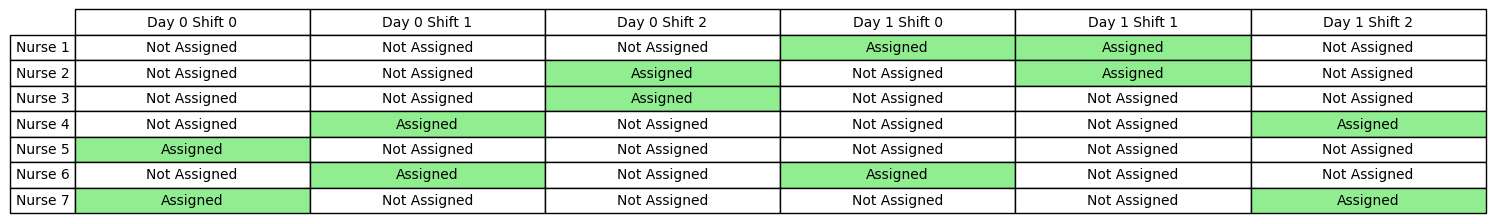

Answer:  No
Query104: is this a solution?


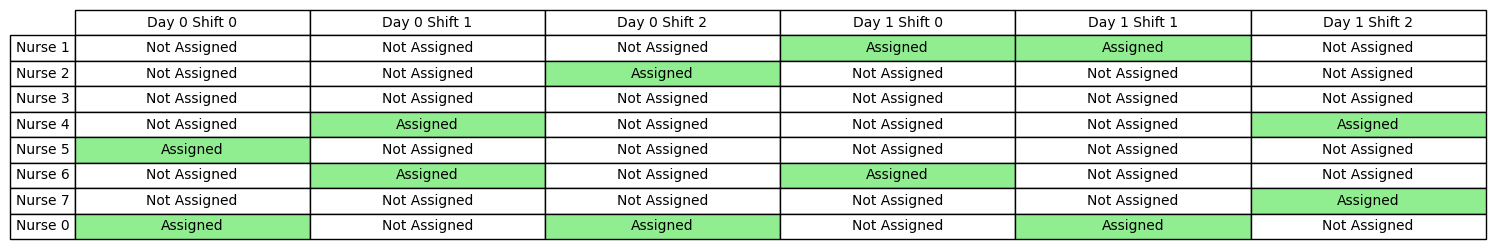

Answer:  No
Query105: is this a solution?


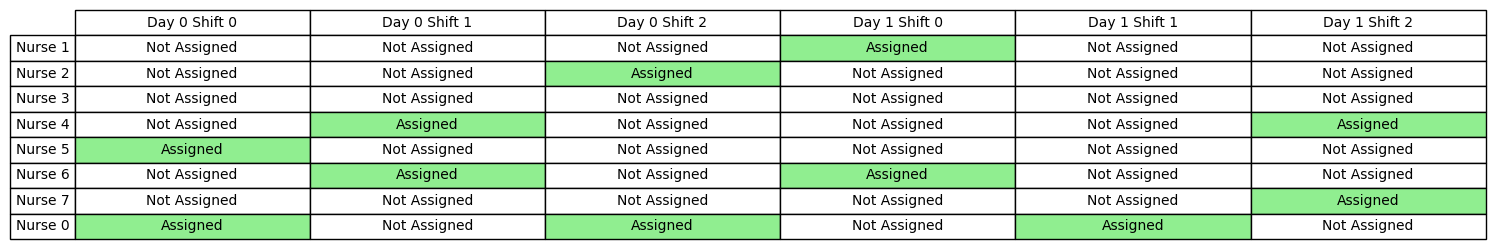

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) <= (shifts[1,2,1]), (shifts[1,2,0]) <= (shifts[1,2,1]), (shifts[0,1,1]) < (shifts[1,2,1]), (shifts[0,0,1]) <= (shifts[1,2,1]), (shifts[0,1,0]) != (shifts[1,2,1]), (shifts[0,0,1]) < (shifts[1,2,1])]
Query106: is this a solution?


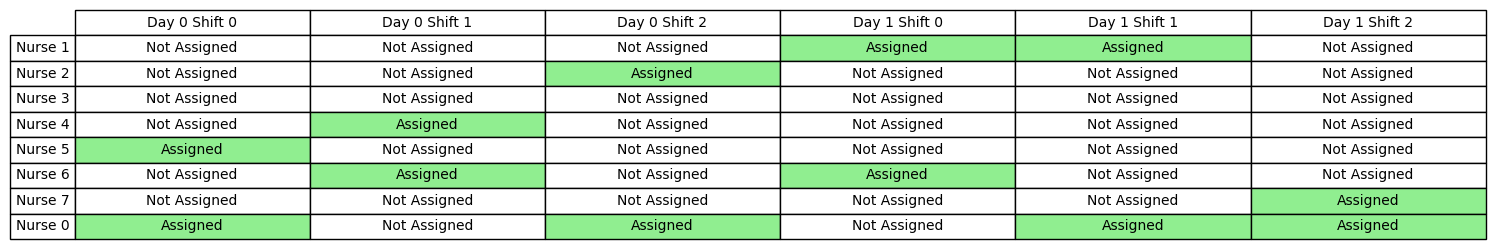

Answer:  No
Query107: is this a solution?


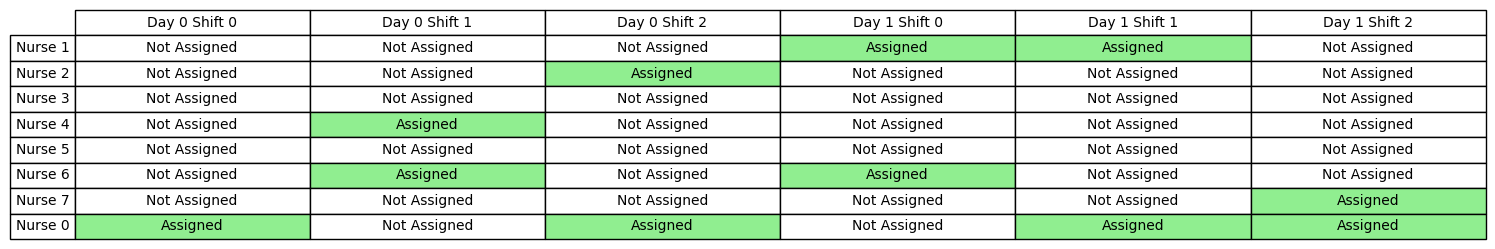

Answer:  No
Query108: is this a solution?


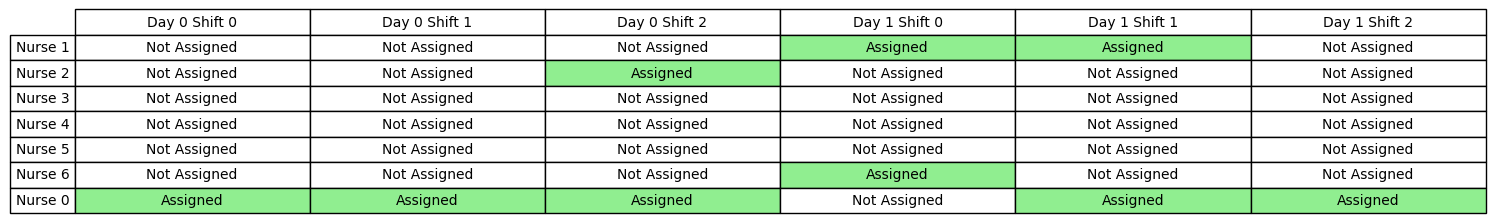

Answer:  No
Query109: is this a solution?


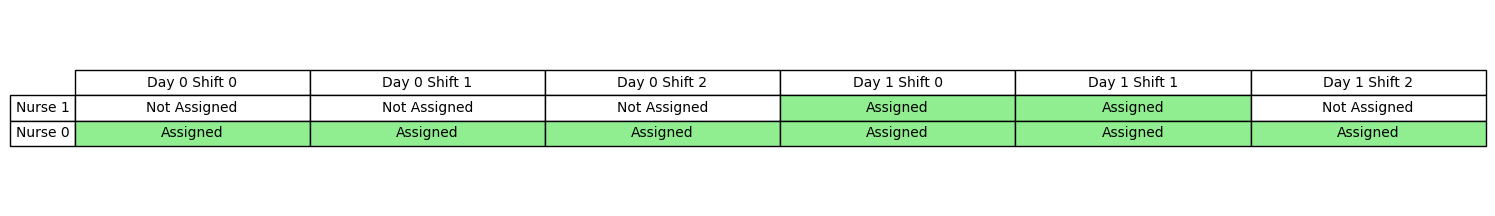

Answer:  No
Query110: is this a solution?


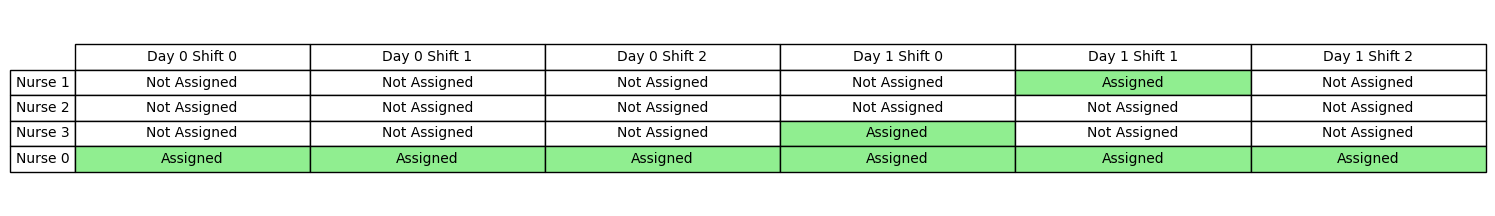

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) < (shifts[1,1,1])]
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[1,1,1])]
Size of CL:  16
Size of B:  184
Number of Queries:  111
Query111: is this a solution?


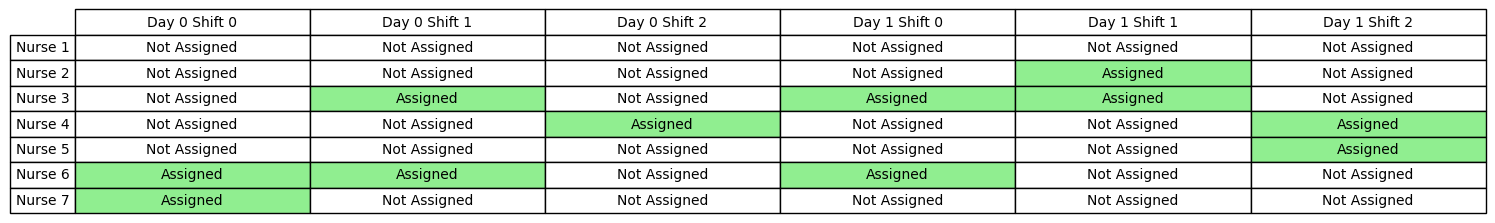

Answer:  No
Query112: is this a solution?


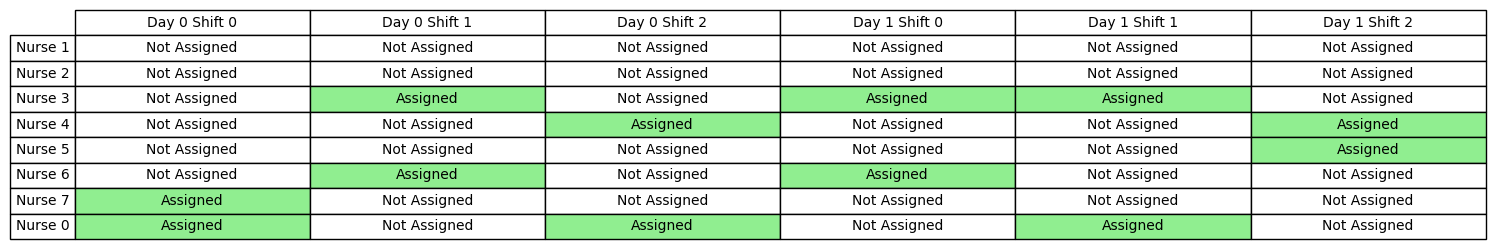

Answer:  No
Query113: is this a solution?


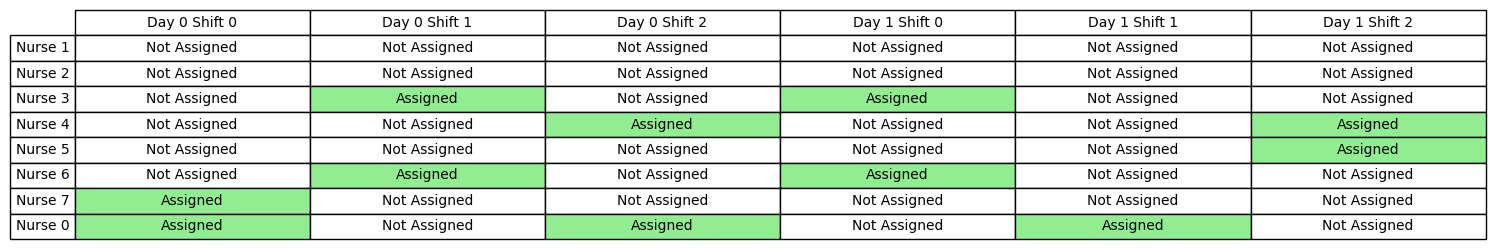

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) != (shifts[1,2,1])]
Query114: is this a solution?


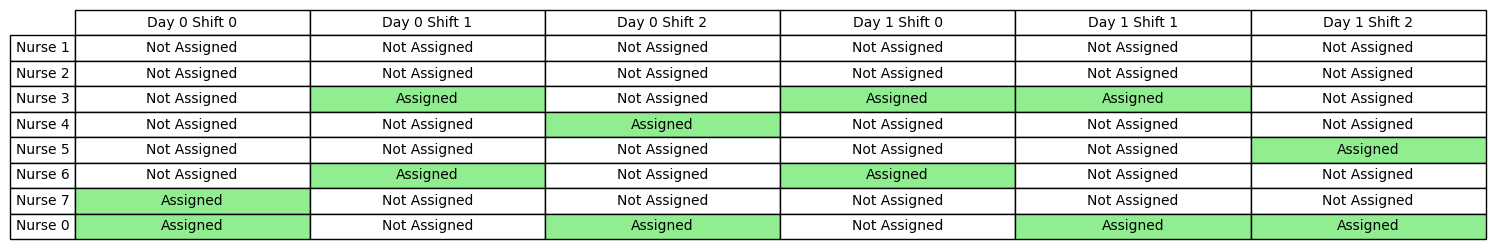

Answer:  No
Query115: is this a solution?


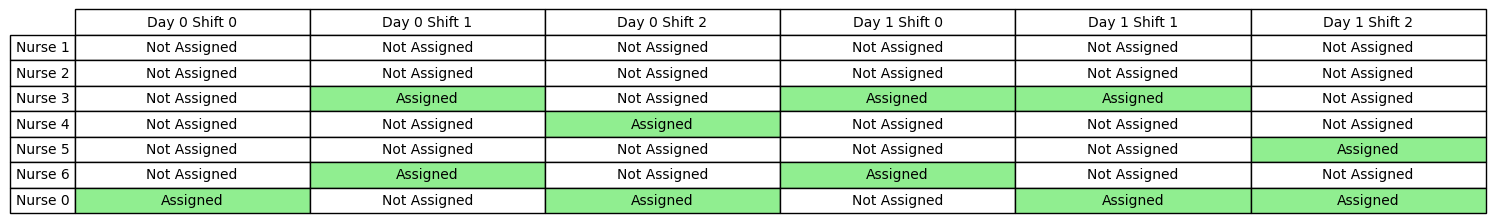

Answer:  No
Query116: is this a solution?


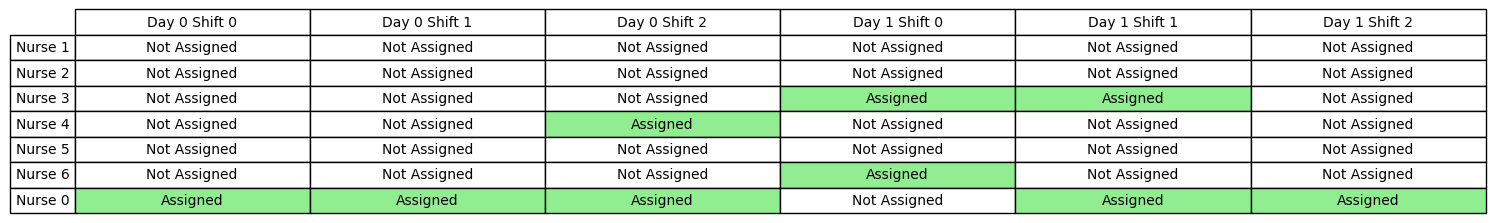

Answer:  No
Query117: is this a solution?


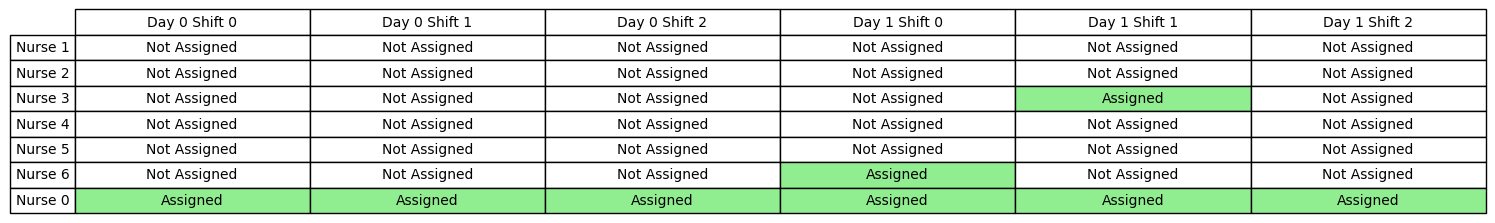

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) <= (shifts[1,1,1])]
Query118: is this a solution?


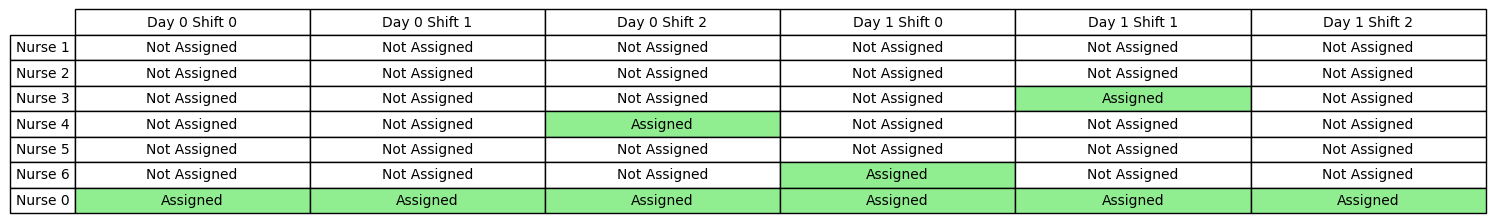

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,0]) < (shifts[1,1,1]), (shifts[0,2,0]) <= (shifts[1,1,1])]
Query119: is this a solution?


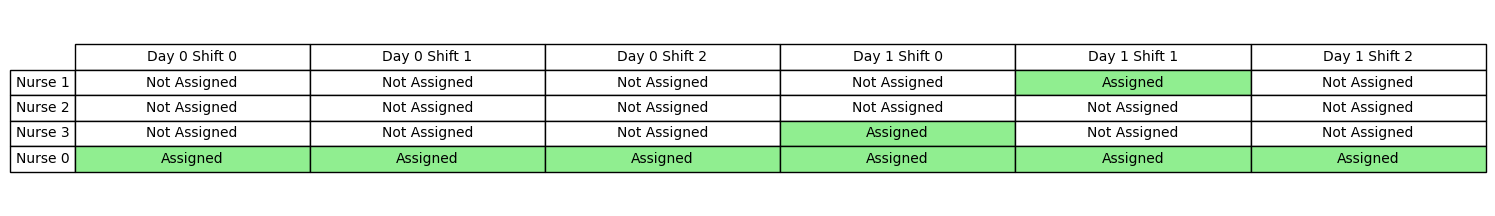

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,0]) < (shifts[1,1,1])]
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[1,1,1])]
Size of CL:  17
Size of B:  178
Number of Queries:  120
Query120: is this a solution?


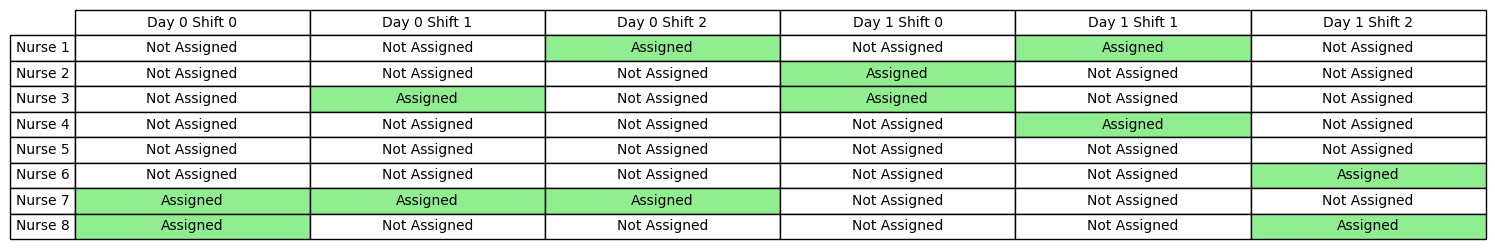

Answer:  No
Query121: is this a solution?


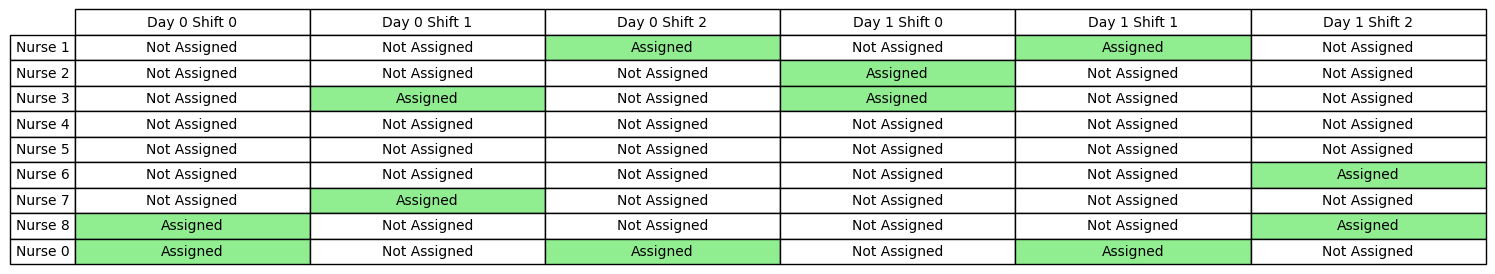

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) <= (shifts[1,1,1]), (shifts[0,1,1]) < (shifts[1,1,1]), (shifts[1,1,1]) > (shifts[1,2,1]), (shifts[1,1,1]) >= (shifts[1,2,0]), (shifts[0,1,0]) < (shifts[1,1,1]), (shifts[1,1,1]) >= (shifts[1,2,1]), (shifts[1,0,0]) <= (shifts[1,1,1]), (shifts[0,1,1]) <= (shifts[1,1,1]), (shifts[0,2,0]) != (shifts[1,1,1]), (shifts[1,1,1]) > (shifts[1,2,0]), (shifts[0,0,1]) != (shifts[1,2,1]), (shifts[0,0,1]) < (shifts[1,1,1]), (shifts[0,0,1]) <= (shifts[1,1,1])]
Query122: is this a solution?


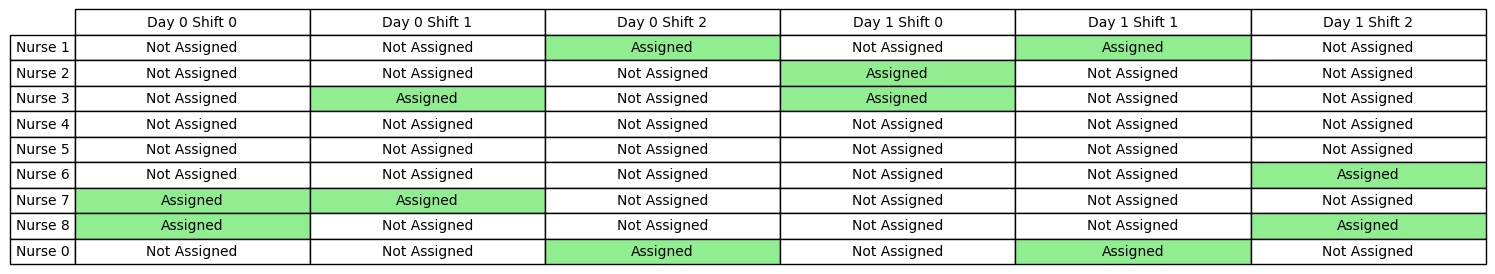

Answer:  No
Query123: is this a solution?


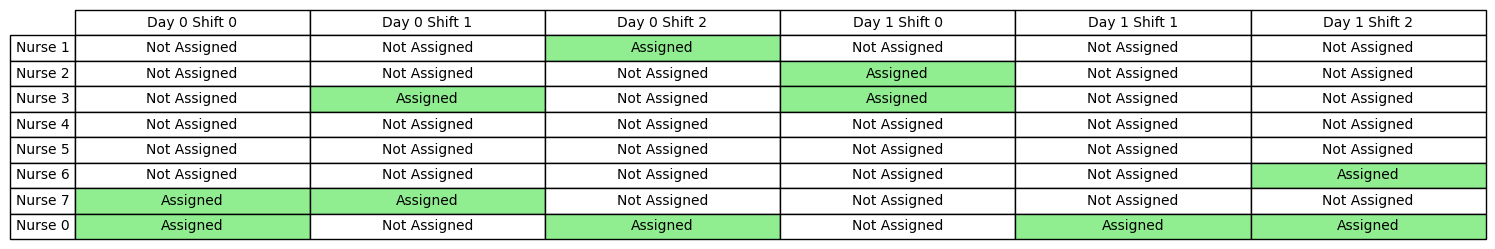

Answer:  No
Query124: is this a solution?


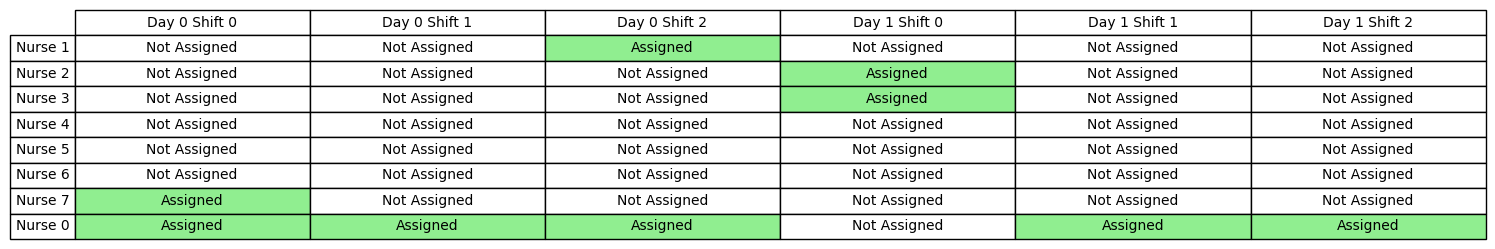

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) < (shifts[1,0,0]), (shifts[0,0,0]) <= (shifts[1,0,0]), (shifts[0,0,0]) <= (shifts[1,0,1]), (shifts[0,0,0]) < (shifts[0,2,0]), (shifts[0,0,0]) < (shifts[1,0,1]), (shifts[0,0,0]) <= (shifts[0,2,0])]
Query125: is this a solution?


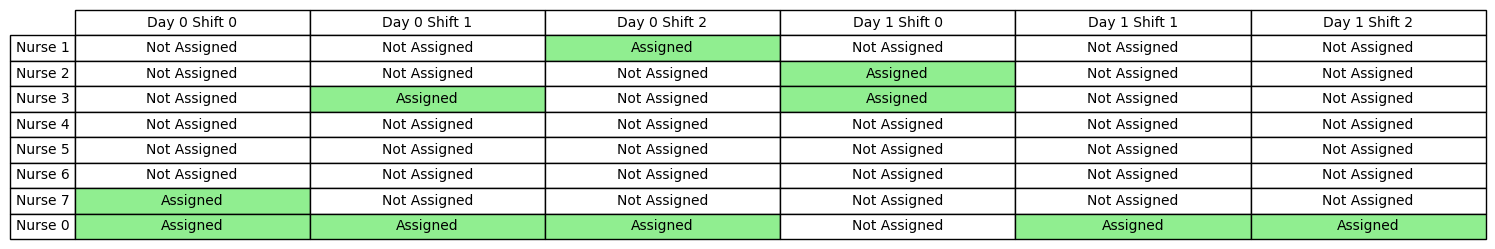

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) < (shifts[0,1,0]), (shifts[0,0,0]) <= (shifts[0,1,0])]
Query126: is this a solution?


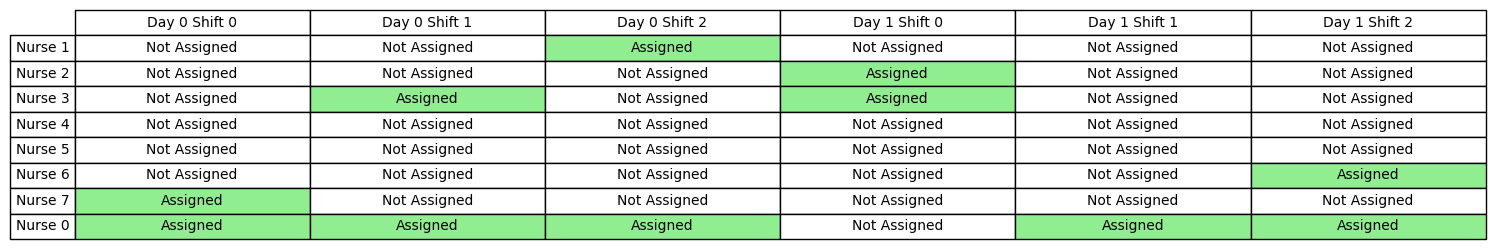

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) <= (shifts[1,2,0]), (shifts[0,0,0]) < (shifts[1,2,0])]
Query127: is this a solution?


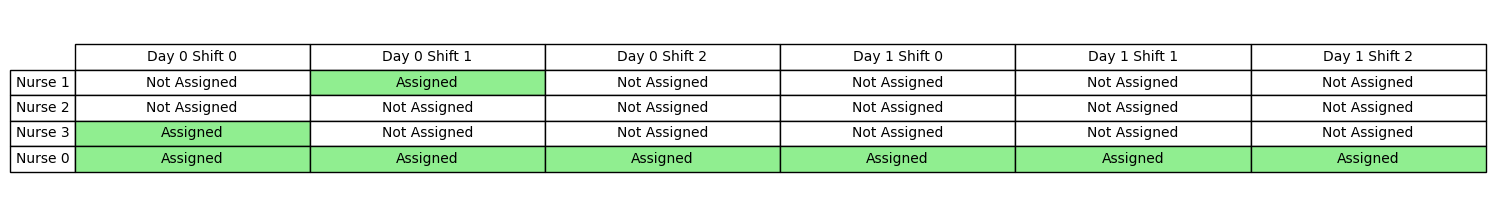

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) < (shifts[0,1,1])]
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,1,1])]
Size of CL:  18
Size of B:  153
Number of Queries:  128
Query128: is this a solution?


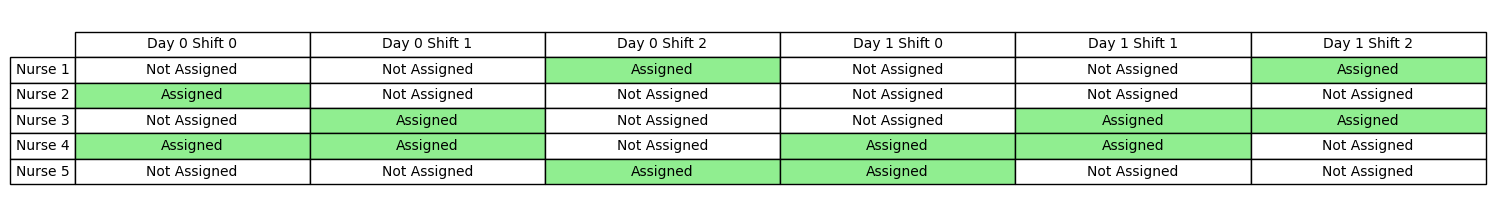

Answer:  No
Query129: is this a solution?


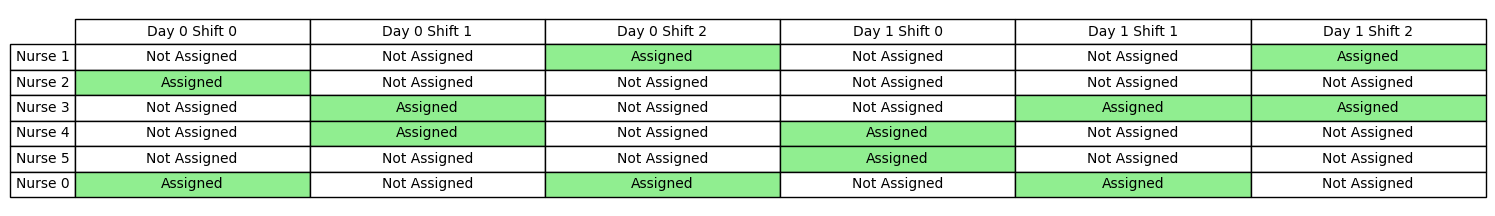

Answer:  No
Query130: is this a solution?


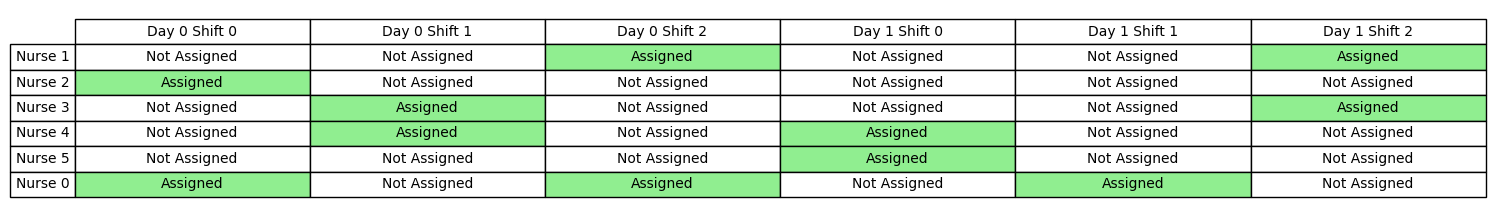

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) != (shifts[1,2,1])]
Query131: is this a solution?


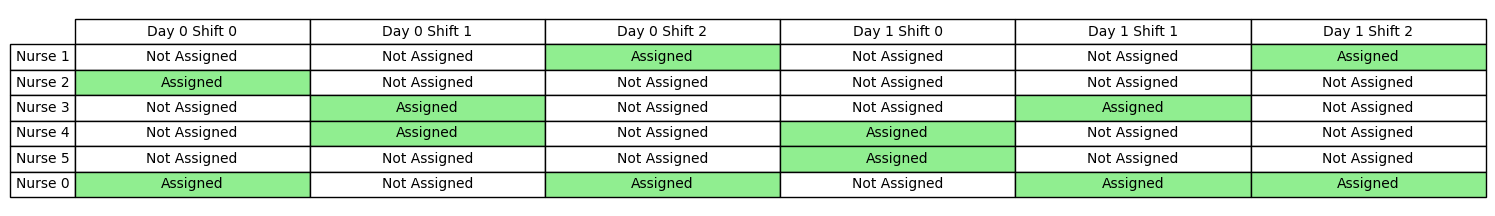

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) != (shifts[1,1,1])]
Query132: is this a solution?


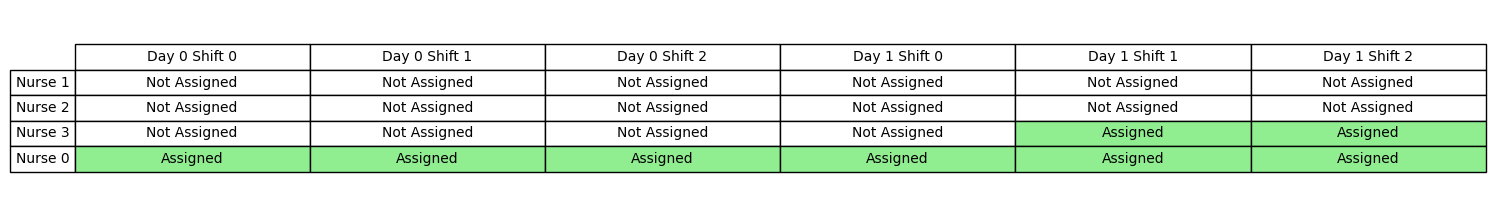

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,2,1])]
Size of CL:  19
Size of B:  150
Number of Queries:  133
Query133: is this a solution?


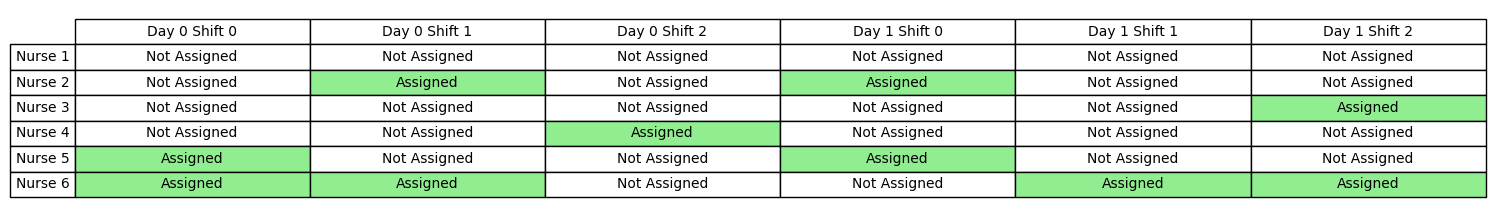

Answer:  No
Query134: is this a solution?


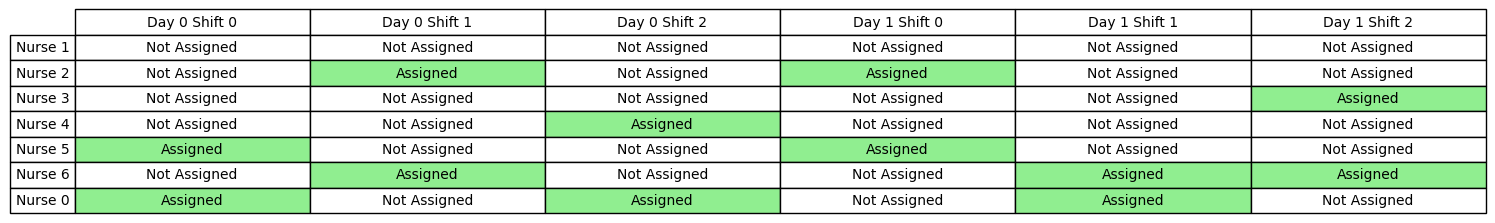

Answer:  No
Query135: is this a solution?


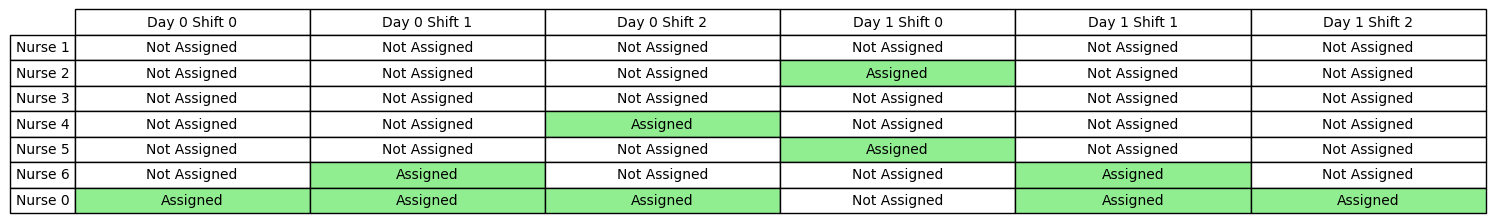

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) != (shifts[1,1,1])]
adding the following constraints to C_L: [(shifts[1,1,1]) != (shifts[1,2,0])]
Size of CL:  20
Size of B:  148
Number of Queries:  136
Query136: is this a solution?


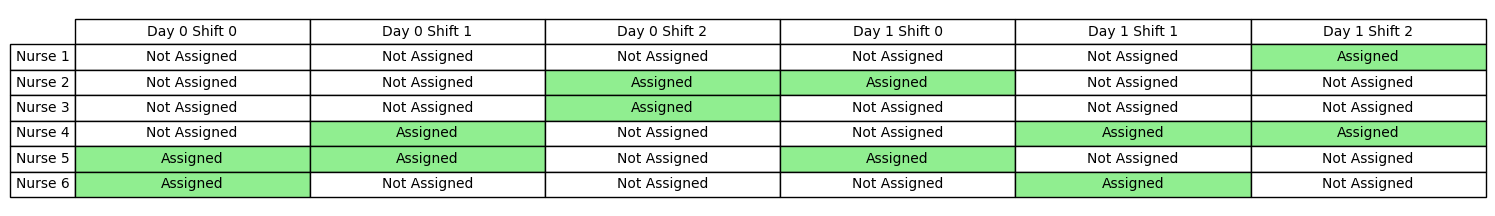

Answer:  No
Query137: is this a solution?


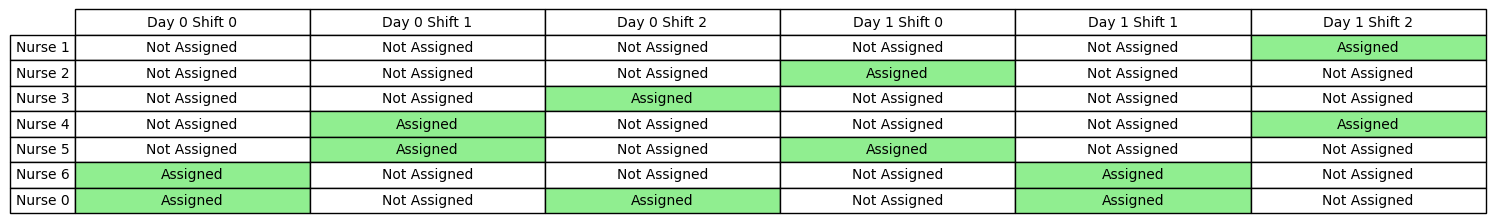

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) != (shifts[1,1,1])]
Query138: is this a solution?


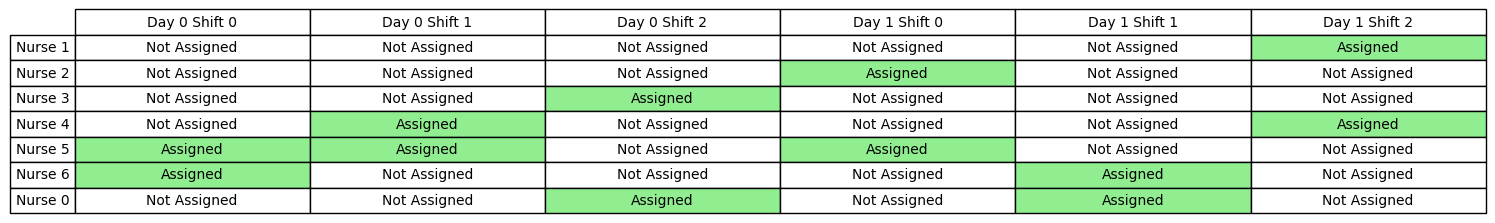

Answer:  No
Query139: is this a solution?


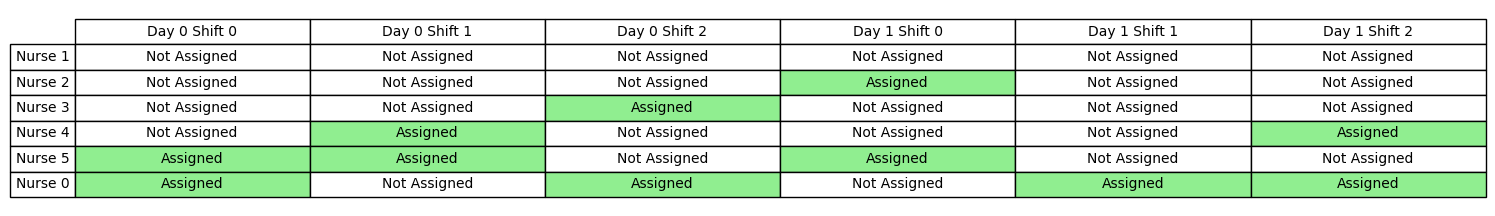

Answer:  No
Query140: is this a solution?


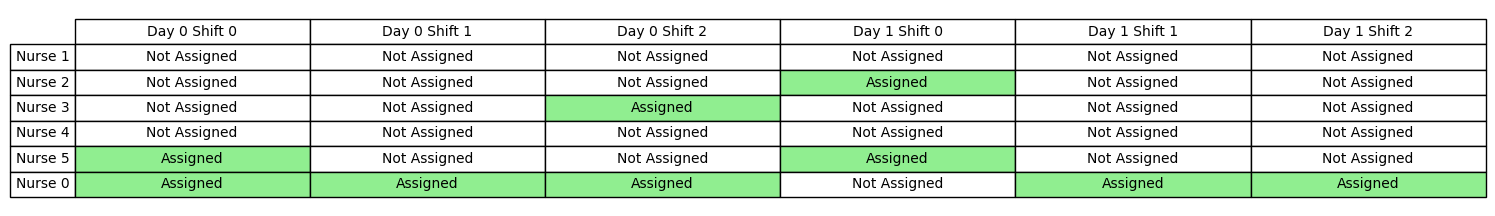

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) != (shifts[1,0,0])]
Query141: is this a solution?


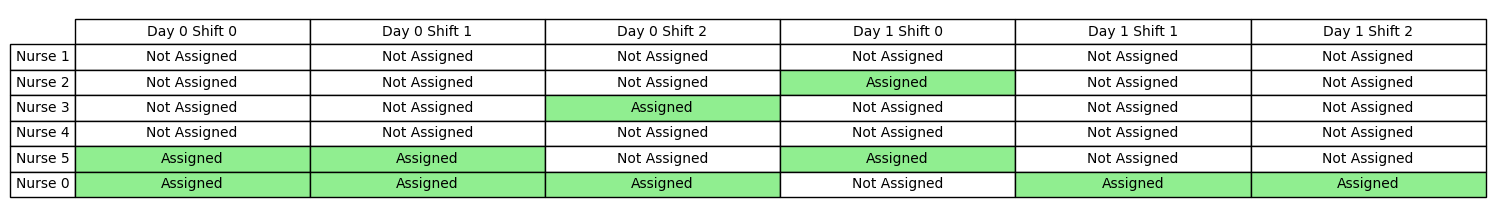

Answer:  No
Query142: is this a solution?


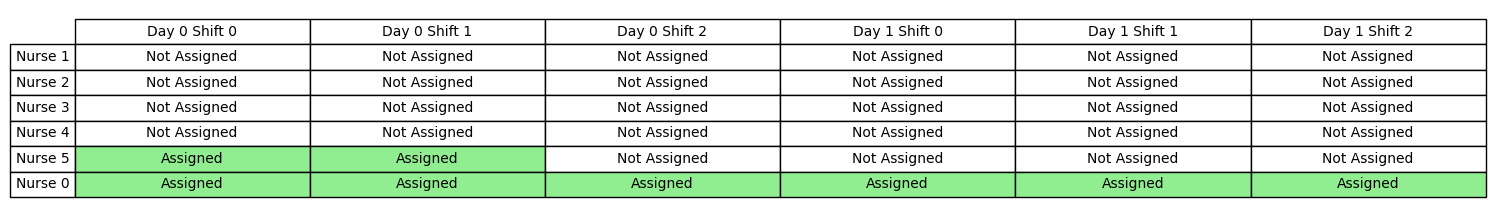

Answer:  No
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,1,0])]
Size of CL:  21
Size of B:  145
Number of Queries:  143
Query143: is this a solution?


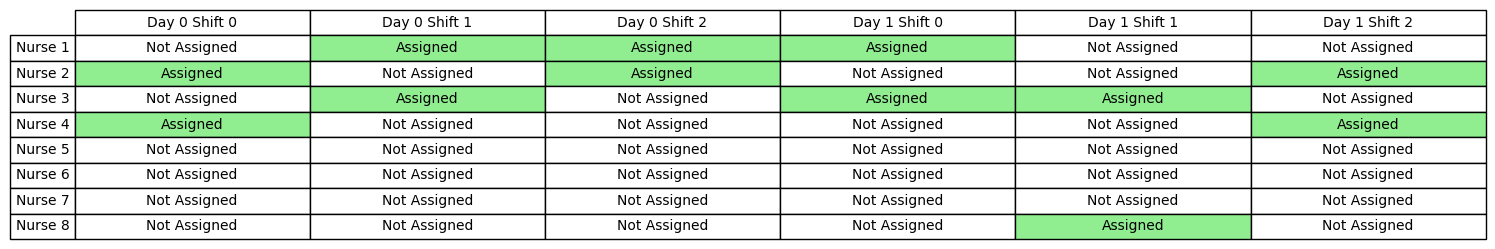

Answer:  No
Query144: is this a solution?


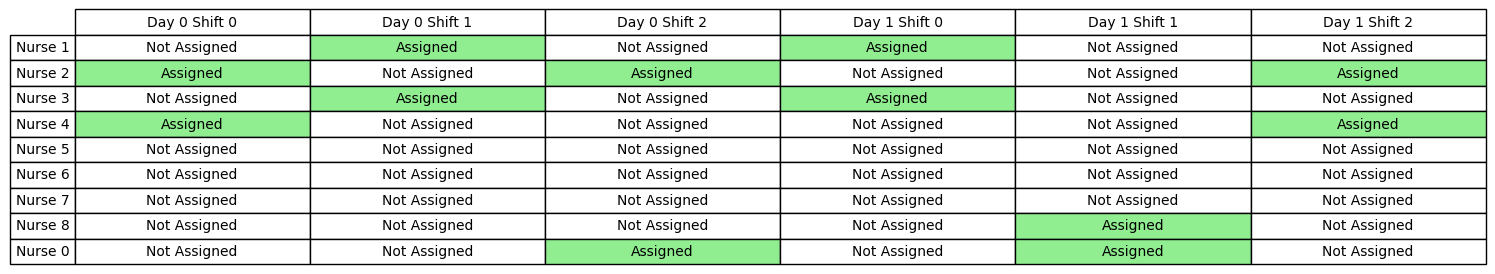

Answer:  No
Query145: is this a solution?


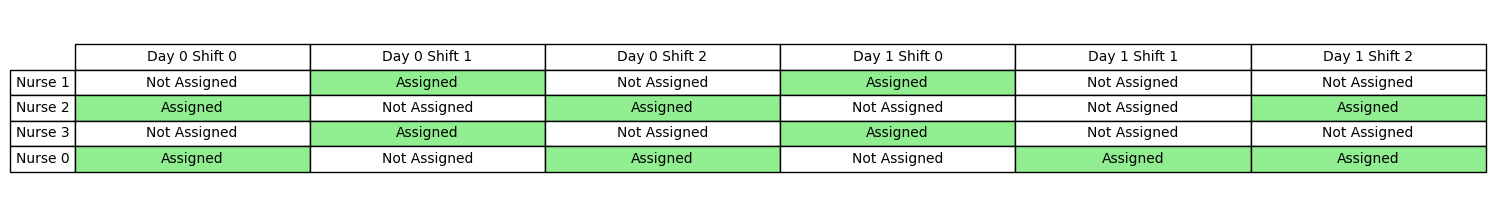

Answer:  No
Query146: is this a solution?


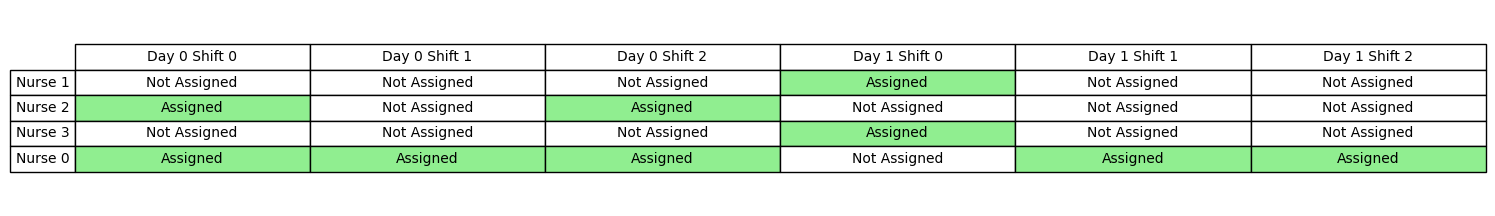

Answer:  No
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,2,0])]
Size of CL:  22
Size of B:  144
Number of Queries:  147
Query147: is this a solution?


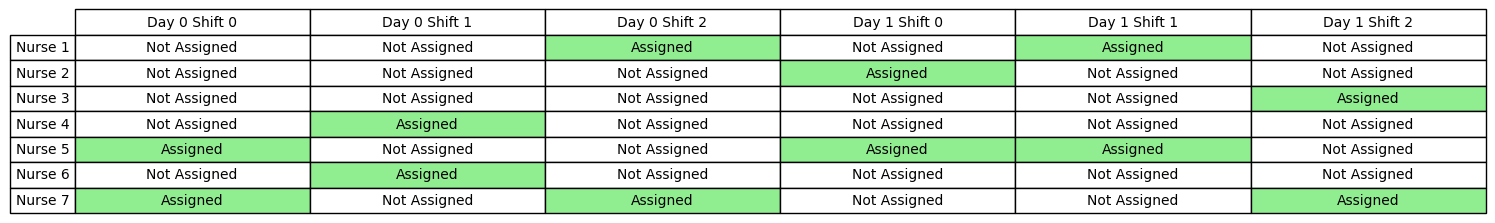

Answer:  No
Query148: is this a solution?


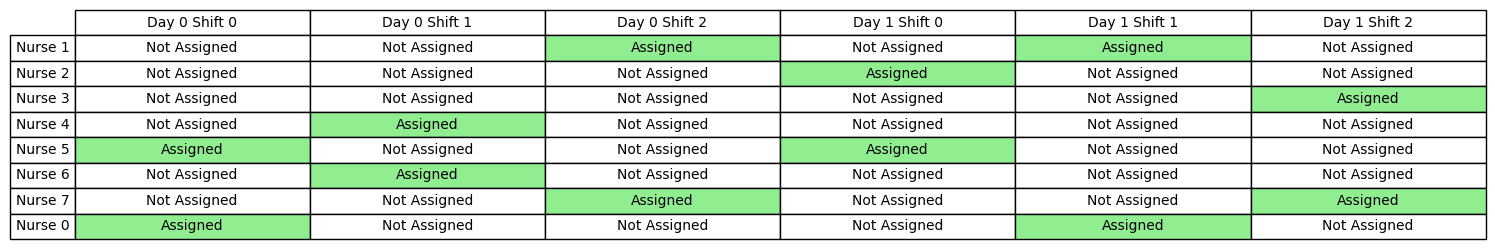

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) <= (shifts[1,0,0]), (shifts[0,1,0]) > (shifts[0,2,1]), (shifts[0,0,1]) == (shifts[0,2,1]), (shifts[0,2,1]) < (shifts[1,0,0]), (shifts[0,2,0]) >= (shifts[0,2,1]), (shifts[0,1,1]) == (shifts[0,2,1]), (shifts[0,1,1]) > (shifts[0,2,1]), (shifts[0,2,1]) < (shifts[1,2,1]), (shifts[0,2,1]) <= (shifts[1,1,1]), (shifts[0,2,1]) < (shifts[1,1,1]), (shifts[0,1,0]) == (shifts[0,2,1]), (shifts[0,2,1]) == (shifts[1,0,1]), (shifts[0,2,0]) == (shifts[0,2,1]), (shifts[0,2,1]) > (shifts[1,2,0]), (shifts[0,0,1]) > (shifts[0,2,1]), (shifts[0,2,1]) != (shifts[1,2,0]), (shifts[0,0,1]) >= (shifts[0,2,1]), (shifts[0,2,1]) <= (shifts[1,2,1]), (shifts[0,2,1]) == (shifts[1,2,1]), (shifts[0,2,1]) < (shifts[1,0,1]), (shifts[0,2,0]) > (shifts[0,2,1]), (shifts[0,1,1]) >= (shifts[0,2,1]), (shifts[0,2,1]) <= (shifts[1,0,1]), (shifts[0,2,1]) < (shifts[1,2,0]), (shifts[0,1,0]) >= (shifts[0,2,1]), (shifts[0,2,1]) == (shifts[1,1,1]), (shifts[0,2,1]

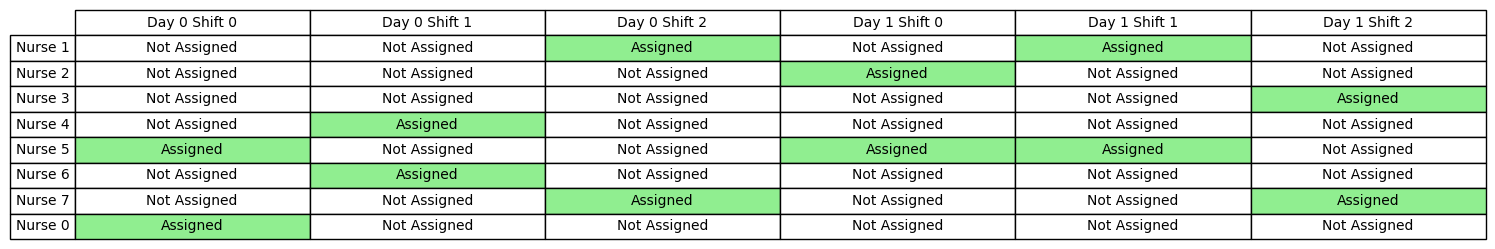

Answer:  No
Query150: is this a solution?


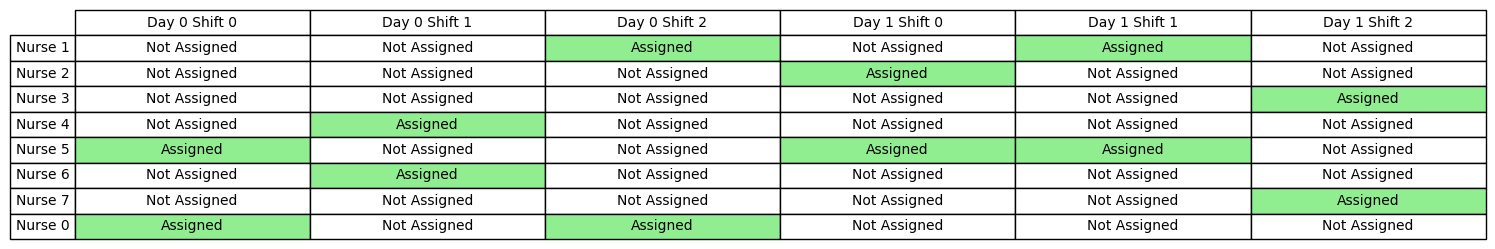

Answer:  No
Query151: is this a solution?


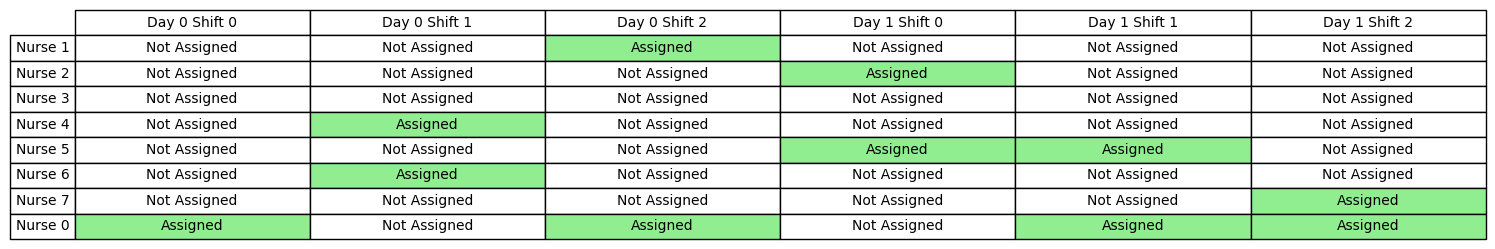

Answer:  No
Query152: is this a solution?


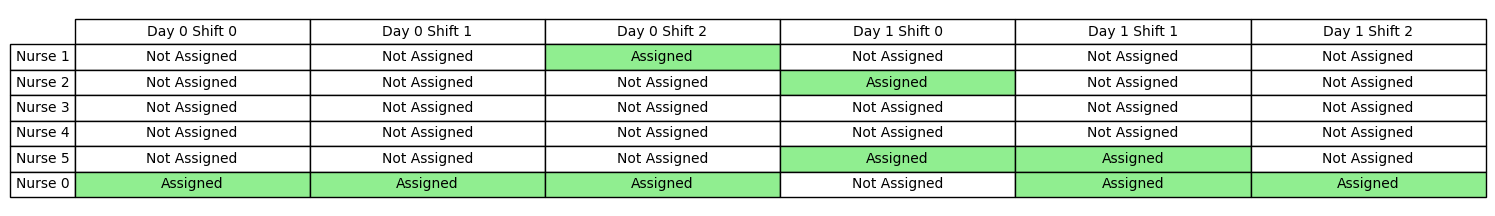

Answer:  No
Query153: is this a solution?


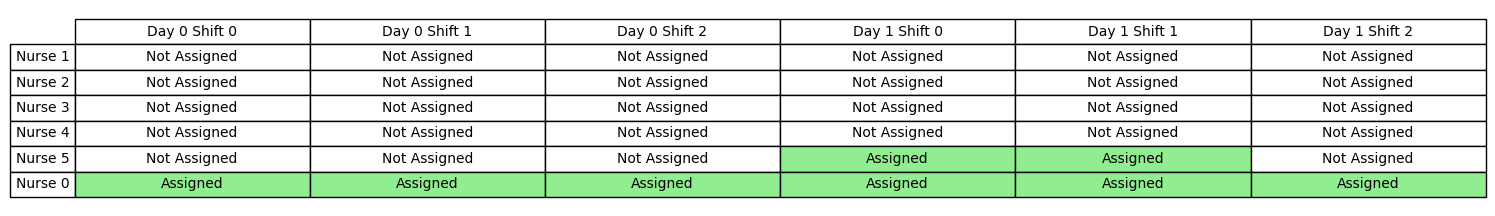

Answer:  No
Query154: is this a solution?


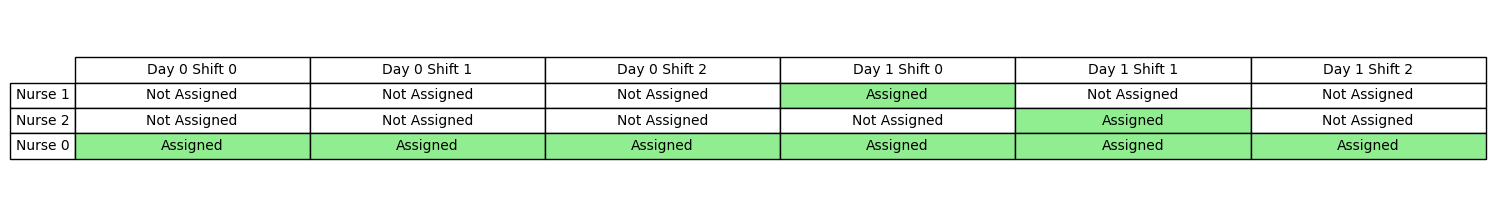

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) > (shifts[1,1,0])]
Query155: is this a solution?


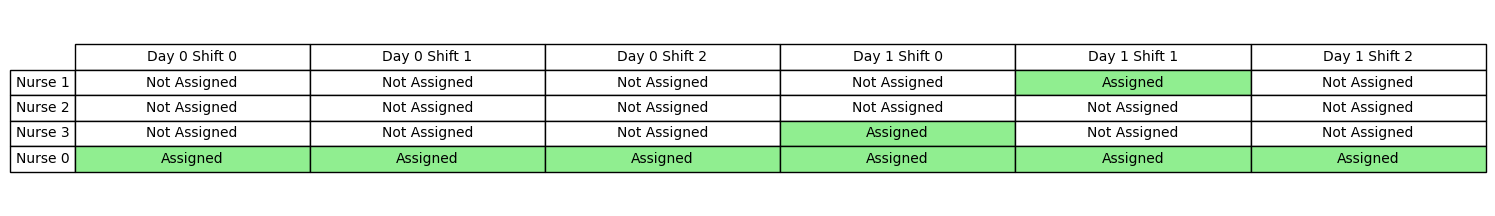

Answer:  Yes
removing the following constraints from bias: [(shifts[1,0,1]) < (shifts[1,1,0])]
adding the following constraints to C_L: [(shifts[1,0,1]) != (shifts[1,1,0])]
Size of CL:  23
Size of B:  114
Number of Queries:  156
Query156: is this a solution?


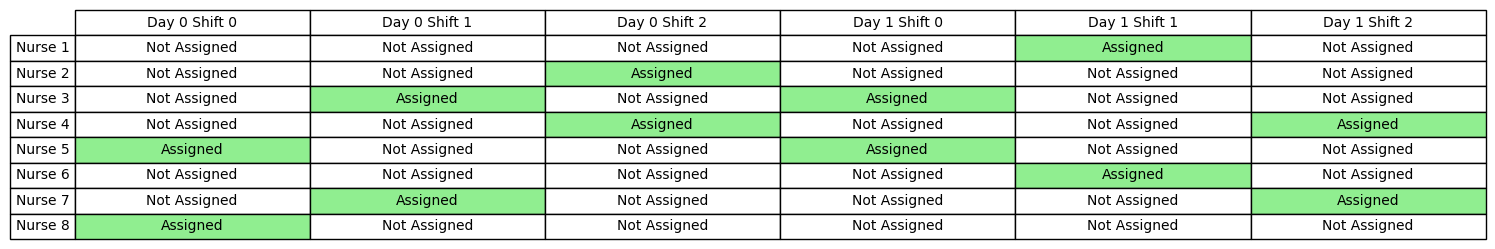

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) < (shifts[1,1,0]), (shifts[0,1,0]) < (shifts[0,2,1]), (shifts[0,2,0]) < (shifts[0,2,1]), (shifts[0,1,1]) == (shifts[1,1,0]), (shifts[0,1,1]) <= (shifts[0,2,1]), (shifts[0,0,1]) <= (shifts[0,2,1]), (shifts[0,2,1]) > (shifts[1,1,1]), (shifts[0,2,0]) <= (shifts[0,2,1]), (shifts[0,0,0]) > (shifts[1,2,1]), (shifts[0,0,0]) == (shifts[0,0,1]), (shifts[1,1,0]) >= (shifts[1,2,0]), (shifts[0,2,1]) <= (shifts[1,1,0]), (shifts[0,2,0]) < (shifts[1,1,0]), (shifts[1,1,0]) > (shifts[1,2,0]), (shifts[0,0,0]) <= (shifts[0,1,1]), (shifts[1,0,0]) < (shifts[1,1,0]), (shifts[0,0,0]) == (shifts[1,2,1]), (shifts[0,2,1]) > (shifts[1,2,1]), (shifts[0,0,0]) == (shifts[1,1,0]), (shifts[0,2,1]) == (shifts[1,2,0]), (shifts[0,0,1]) <= (shifts[1,1,0]), (shifts[0,0,0]) == (shifts[1,1,1]), (shifts[0,2,1]) >= (shifts[1,0,0]), (shifts[0,0,1]) < (shifts[0,2,1]), (shifts[0,0,1]) < (shifts[1,1,0]), (shifts[0,1,0]) <= (shifts[1,1,0]), (shifts[0,2,0])

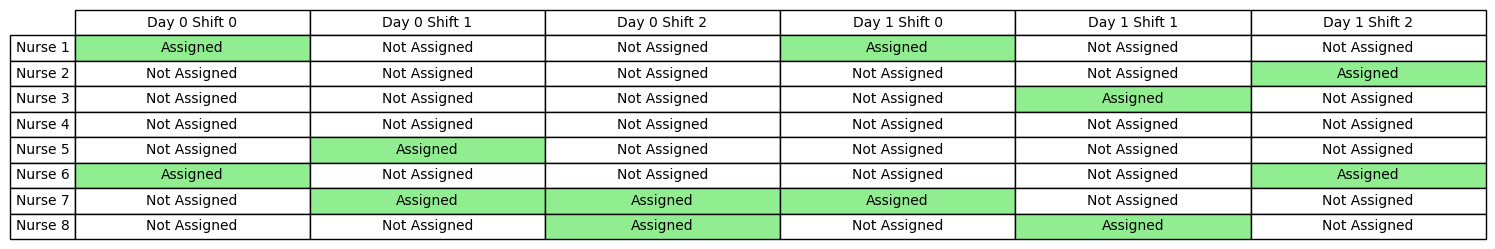

Answer:  No
Query158: is this a solution?


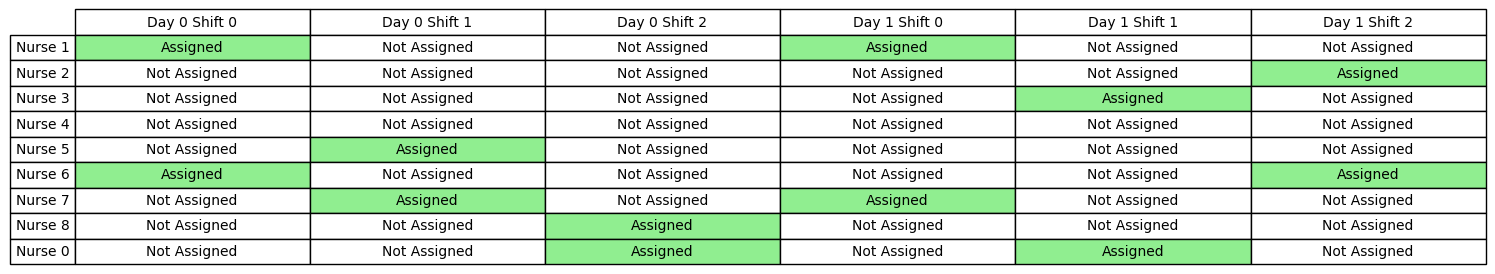

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) < (shifts[1,1,1]), (shifts[0,0,0]) != (shifts[1,2,0]), (shifts[0,0,0]) <= (shifts[1,1,1]), (shifts[0,0,0]) <= (shifts[0,0,1]), (shifts[0,0,0]) < (shifts[1,2,1]), (shifts[0,0,0]) <= (shifts[1,2,1])]
Query159: is this a solution?


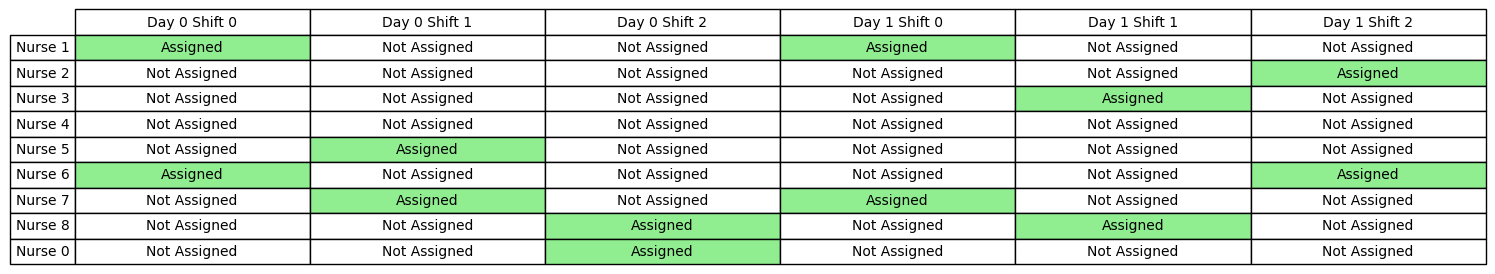

Answer:  Yes
removing the following constraints from bias: [(shifts[1,1,0]) < (shifts[1,1,1]), (shifts[1,1,0]) < (shifts[1,2,1]), (shifts[1,1,0]) <= (shifts[1,2,1]), (shifts[1,1,0]) <= (shifts[1,2,0]), (shifts[0,1,1]) > (shifts[1,1,0]), (shifts[0,2,0]) > (shifts[1,1,0]), (shifts[0,0,0]) > (shifts[1,1,0]), (shifts[1,0,0]) > (shifts[1,1,0]), (shifts[1,0,0]) >= (shifts[1,1,0]), (shifts[0,0,1]) > (shifts[1,1,0]), (shifts[0,1,1]) >= (shifts[1,1,0]), (shifts[1,1,0]) <= (shifts[1,1,1]), (shifts[1,0,1]) >= (shifts[1,1,0]), (shifts[1,1,0]) < (shifts[1,2,0]), (shifts[0,1,0]) >= (shifts[1,1,0]), (shifts[0,1,0]) > (shifts[1,1,0]), (shifts[0,0,0]) >= (shifts[1,1,0]), (shifts[0,0,1]) >= (shifts[1,1,0]), (shifts[0,2,0]) != (shifts[1,1,0])]
Query160: is this a solution?


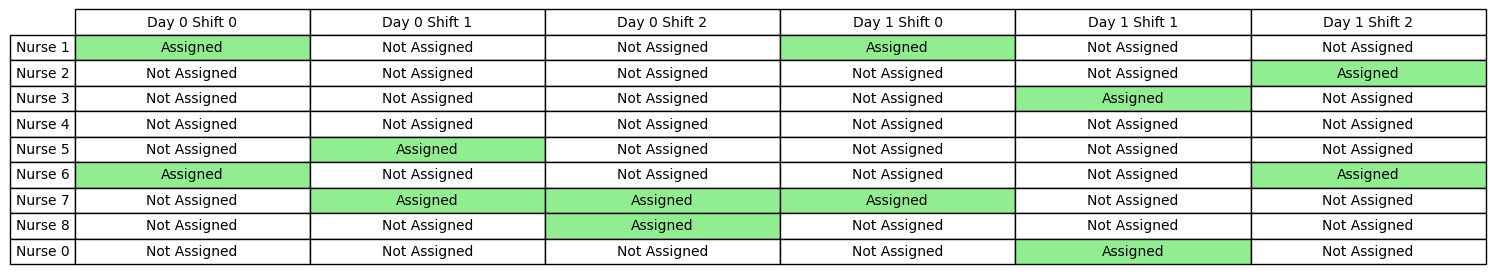

Answer:  No
Query161: is this a solution?


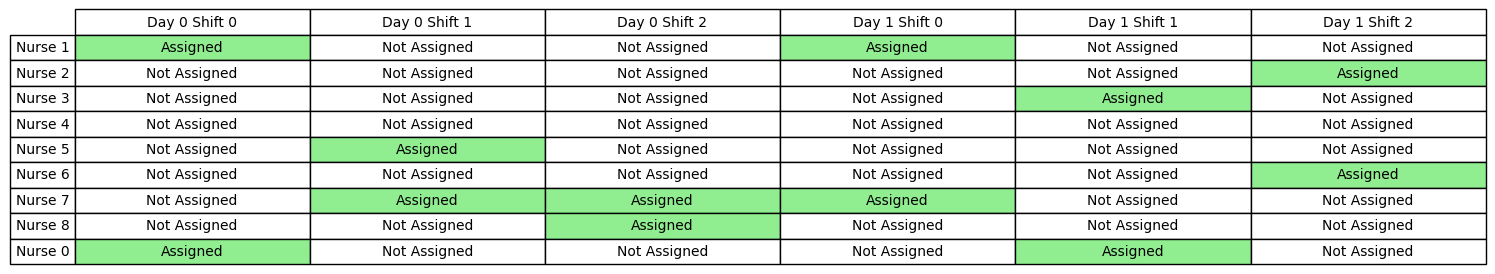

Answer:  No
Query162: is this a solution?


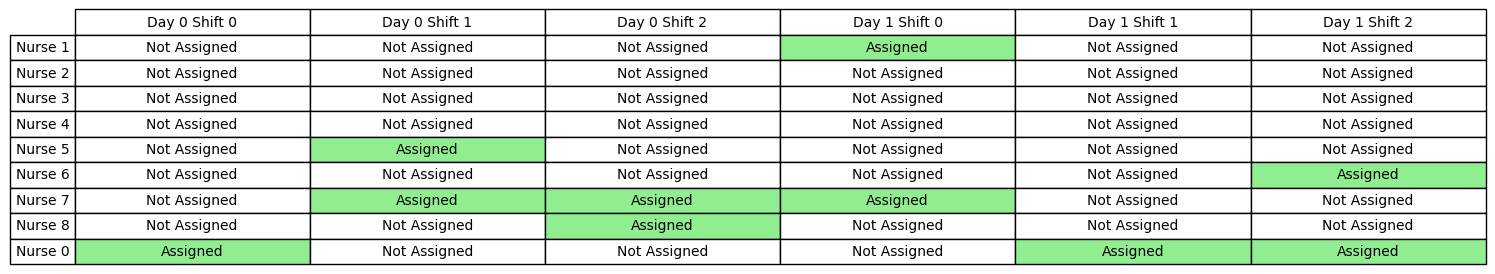

Answer:  No
Query163: is this a solution?


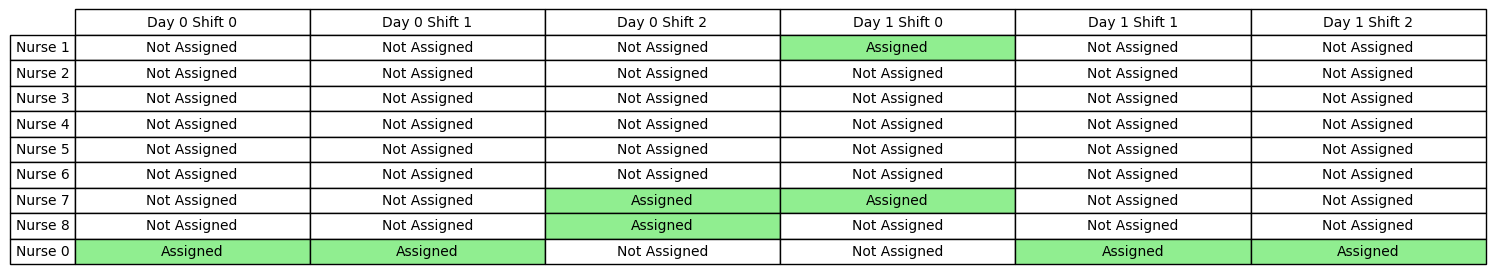

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,1]) != (shifts[1,0,1])]
Size of CL:  24
Size of B:  25
Number of Queries:  164
Query164: is this a solution?


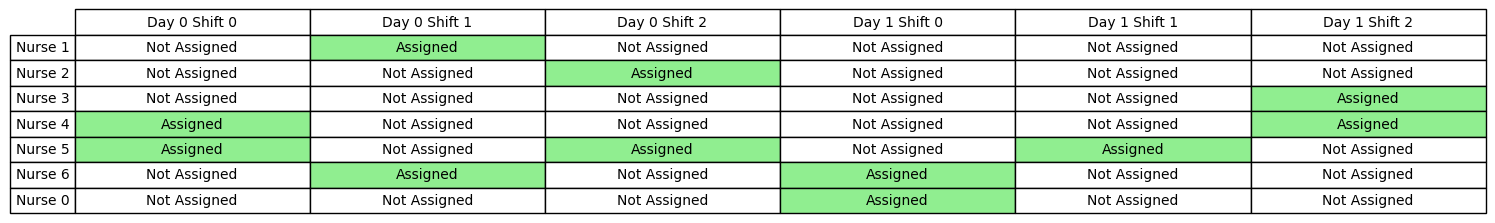

Answer:  No
Query165: is this a solution?


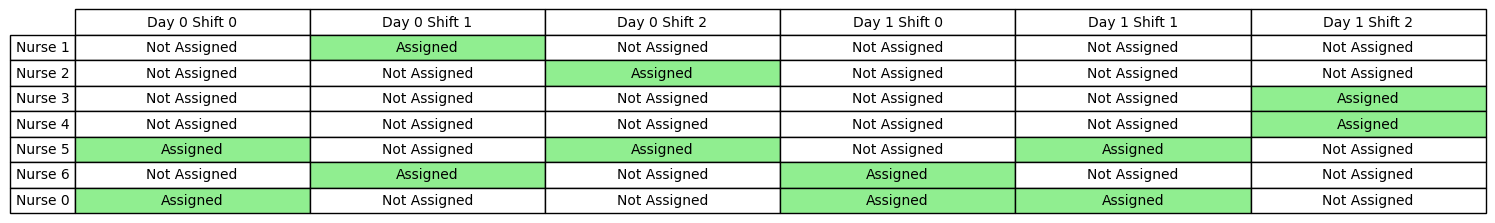

Answer:  No
Query166: is this a solution?


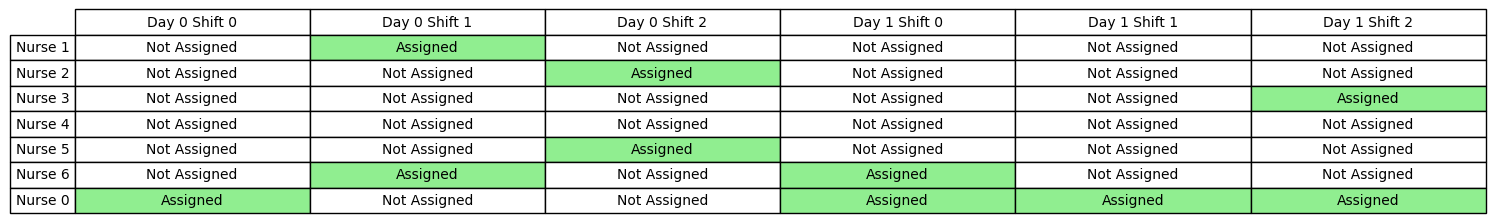

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) <= (shifts[1,2,0])]
Query167: is this a solution?


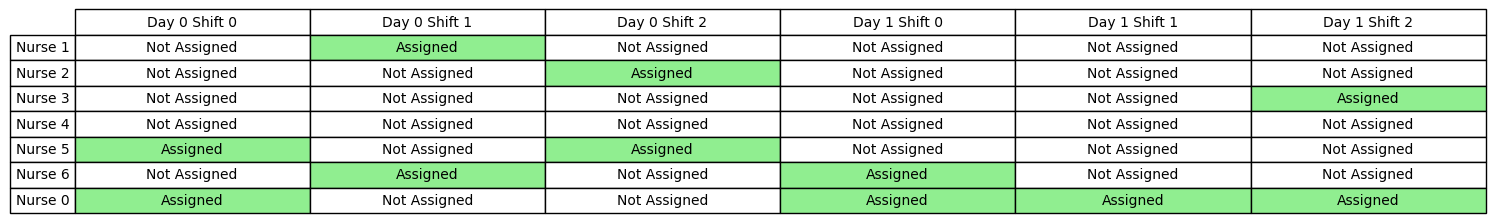

Answer:  No
Query168: is this a solution?


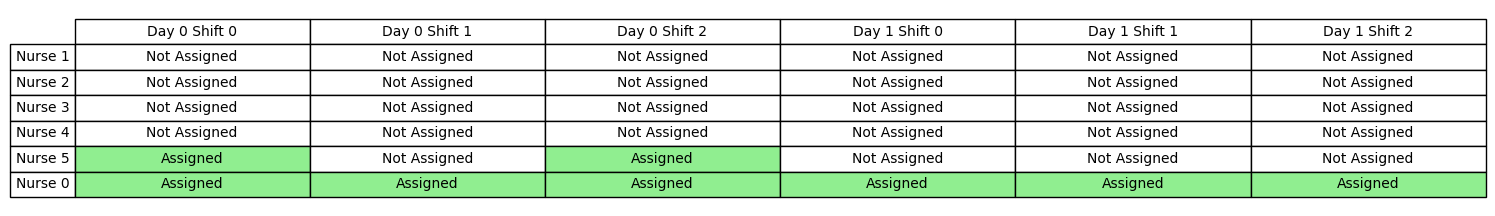

Answer:  No
adding the following constraints to C_L: [(shifts[0,0,1]) != (shifts[0,2,1])]
Size of CL:  25
Size of B:  23
Number of Queries:  169
Query169: is this a solution?


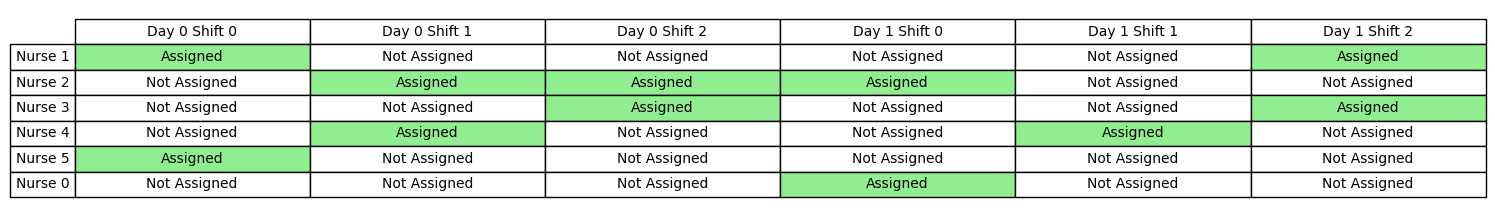

Answer:  No
Query170: is this a solution?


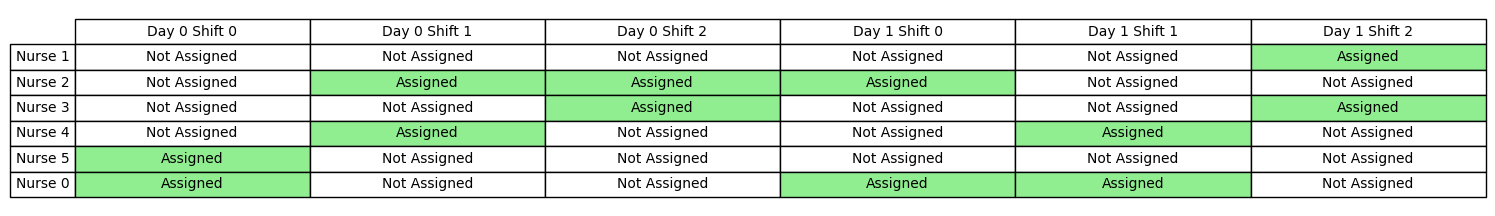

Answer:  No
Query171: is this a solution?


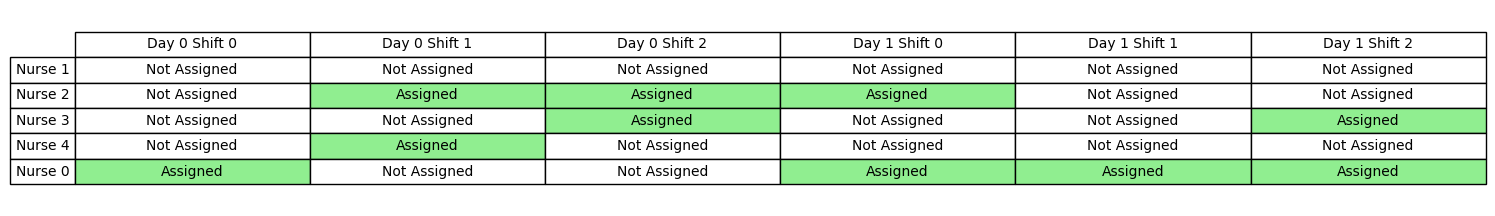

Answer:  No
Query172: is this a solution?


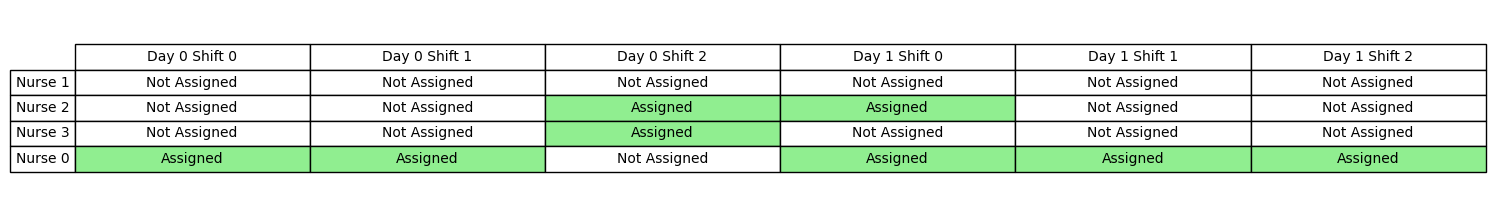

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,1]) != (shifts[1,0,0])]
Size of CL:  26
Size of B:  22
Number of Queries:  173
Query173: is this a solution?


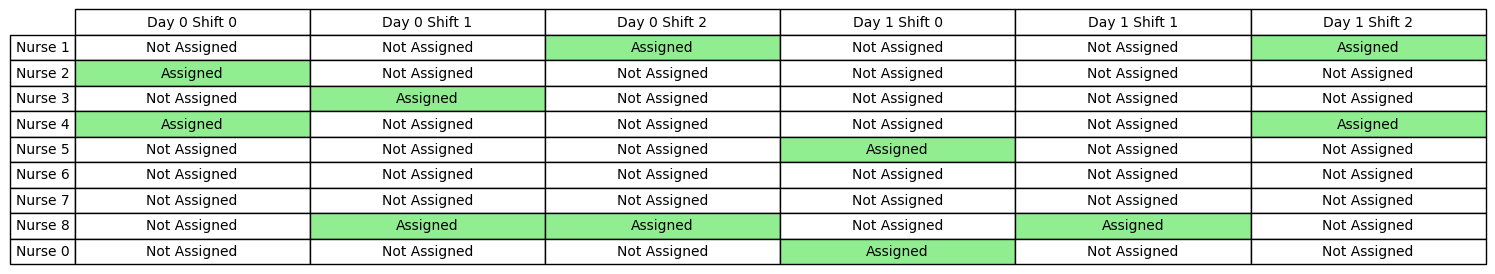

Answer:  No
Query174: is this a solution?


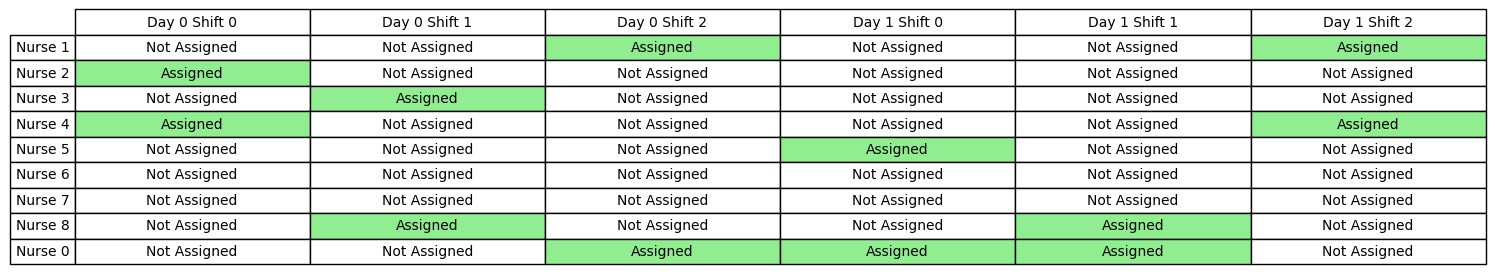

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) != (shifts[1,2,1])]
Query175: is this a solution?


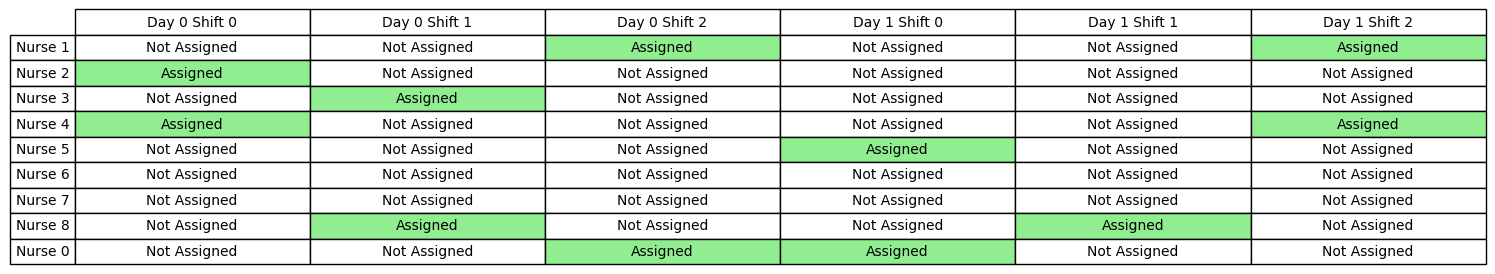

Answer:  No
Query176: is this a solution?


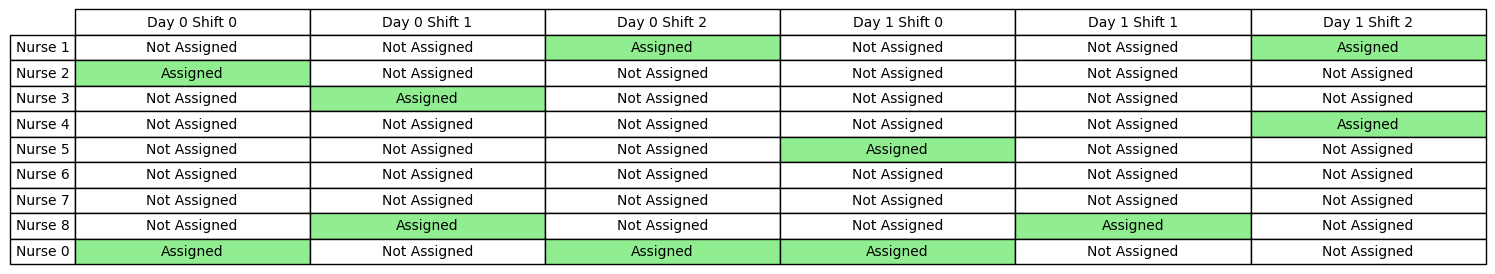

Answer:  No
Query177: is this a solution?


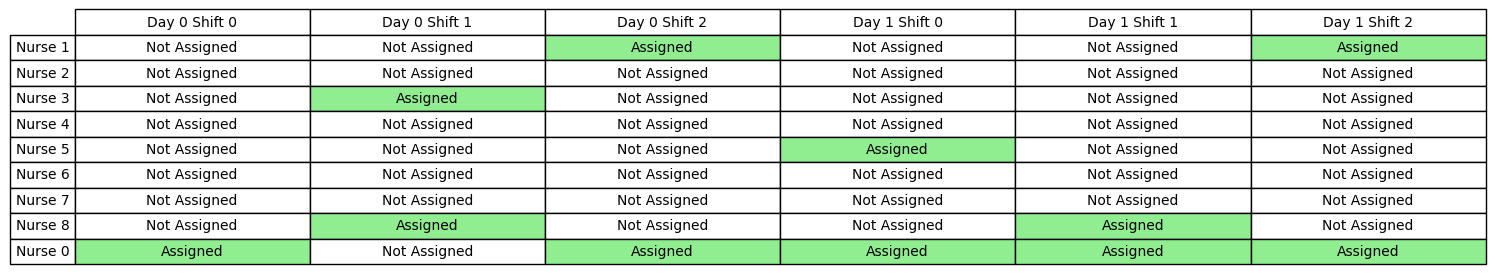

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,1]) != (shifts[1,1,0]), (shifts[0,2,0]) >= (shifts[1,1,0])]
Query178: is this a solution?


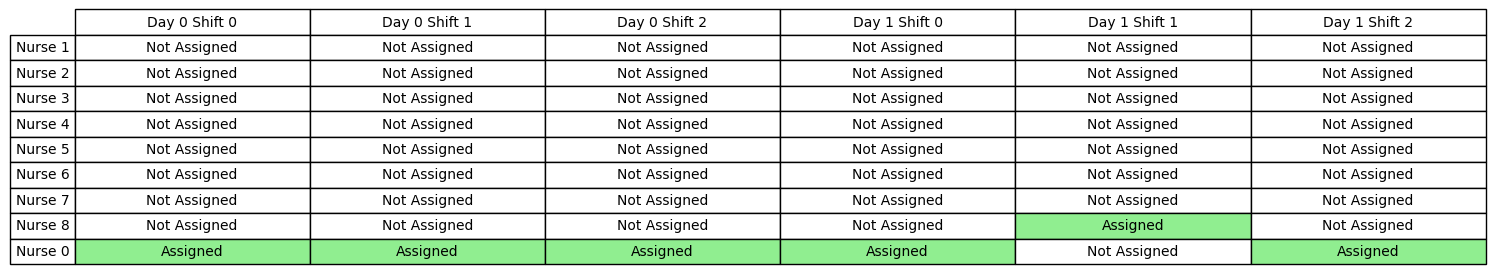

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,0]) != (shifts[1,1,1])]
Size of CL:  27
Size of B:  18
Number of Queries:  179
Query179: is this a solution?


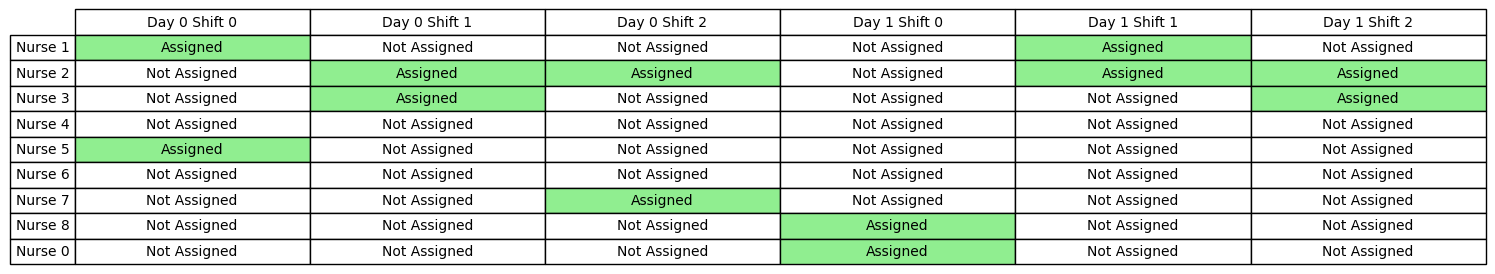

Answer:  No
Query180: is this a solution?


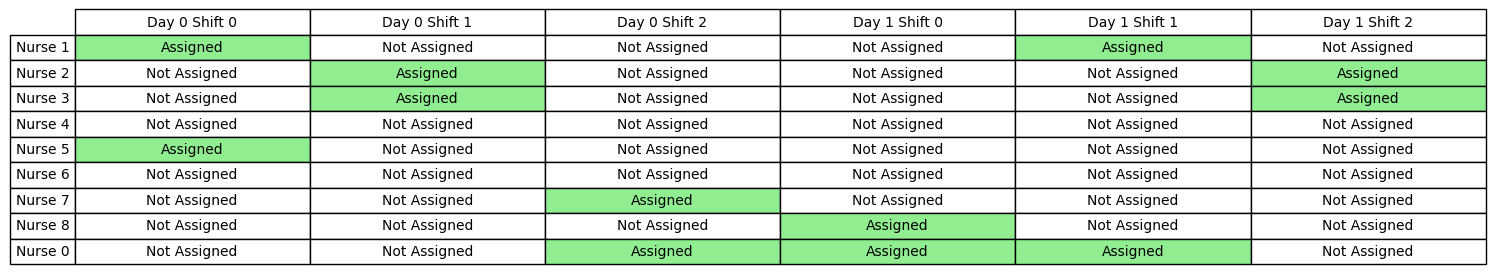

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) != (shifts[1,1,1])]
Query181: is this a solution?


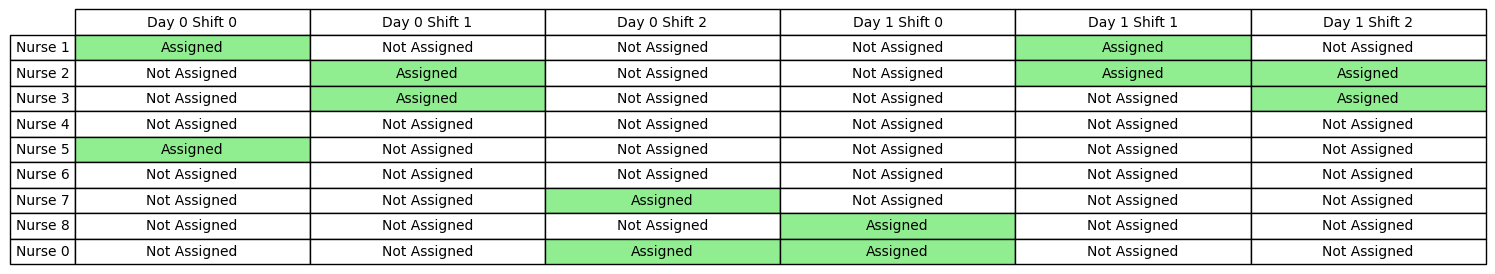

Answer:  No
Query182: is this a solution?


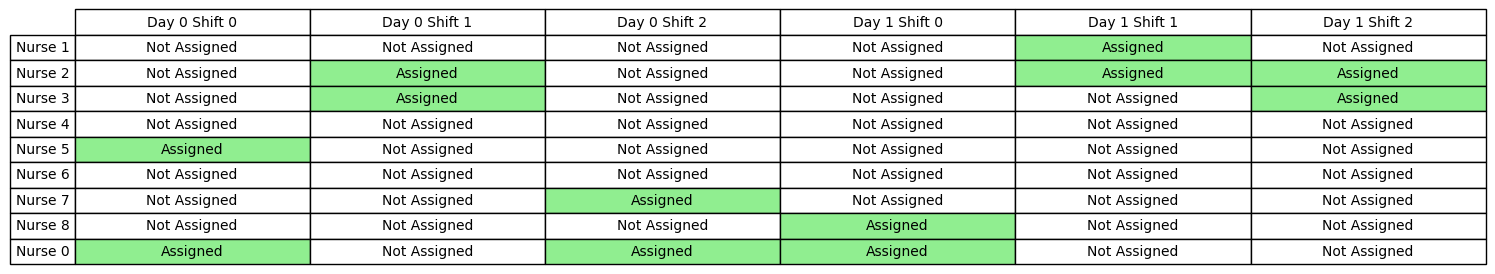

Answer:  No
Query183: is this a solution?


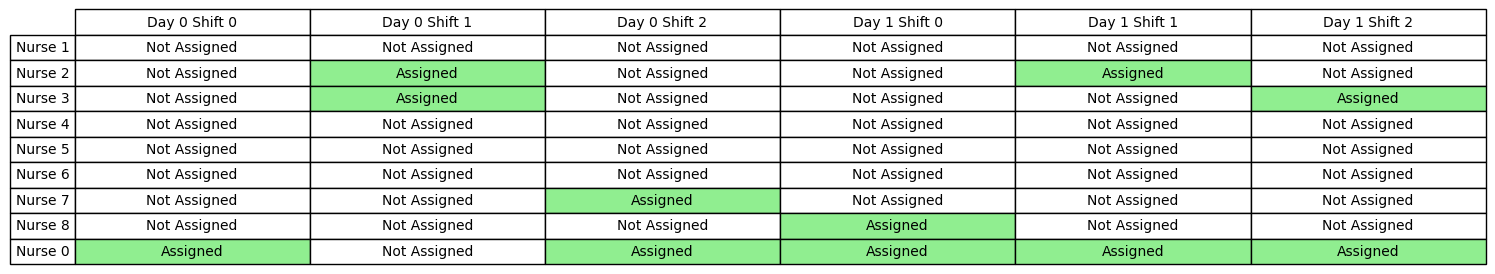

Answer:  Yes
removing the following constraints from bias: [(shifts[0,1,0]) != (shifts[1,1,0])]
Query184: is this a solution?


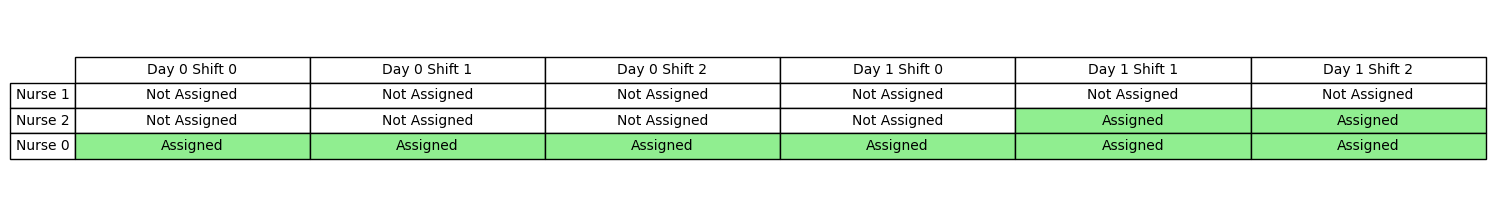

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,0]) != (shifts[1,2,1])]
Size of CL:  28
Size of B:  15
Number of Queries:  185
Query185: is this a solution?


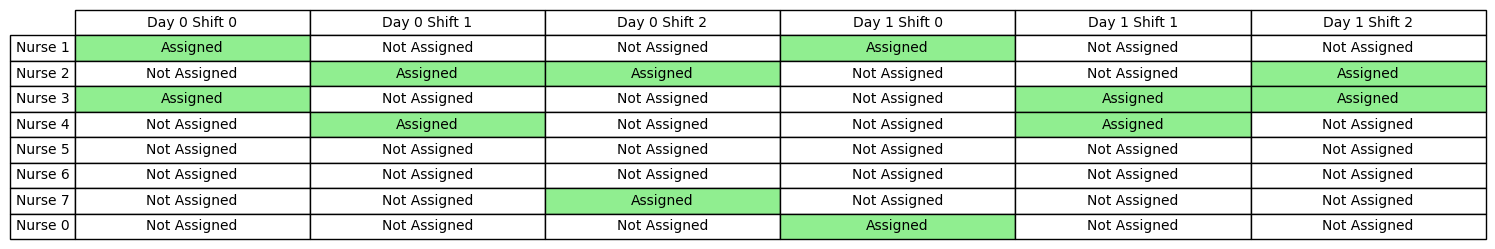

Answer:  No
Query186: is this a solution?


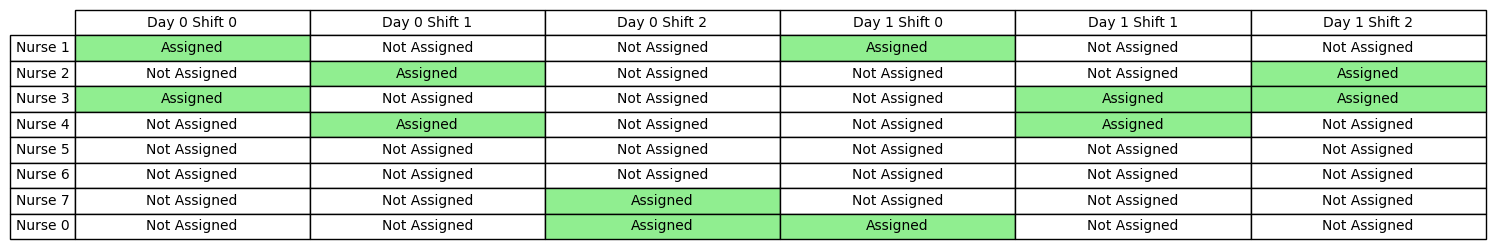

Answer:  No
Query187: is this a solution?


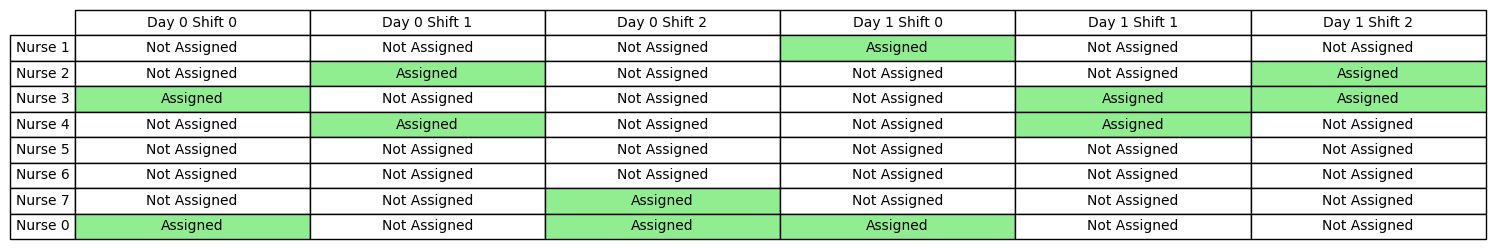

Answer:  No
Query188: is this a solution?


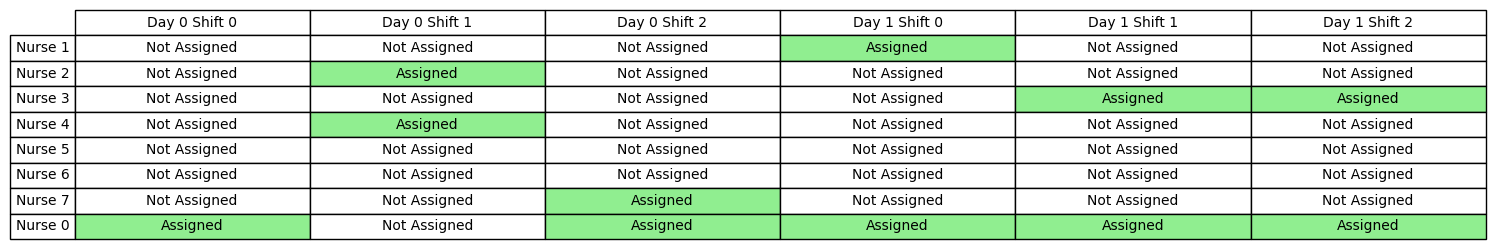

Answer:  No
adding the following constraints to C_L: [(shifts[1,1,0]) != (shifts[1,2,0])]
Size of CL:  29
Size of B:  14
Number of Queries:  189
Query189: is this a solution?


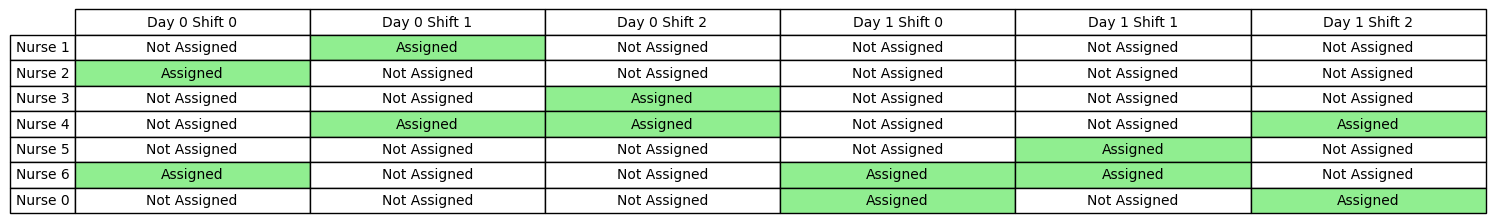

Answer:  No
Query190: is this a solution?


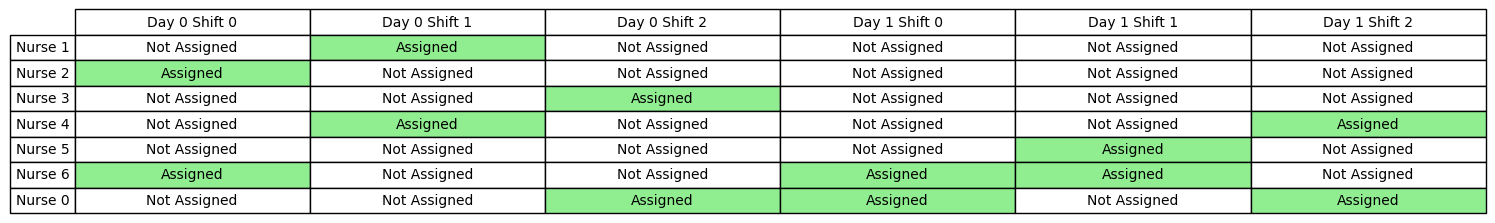

Answer:  No
Query191: is this a solution?


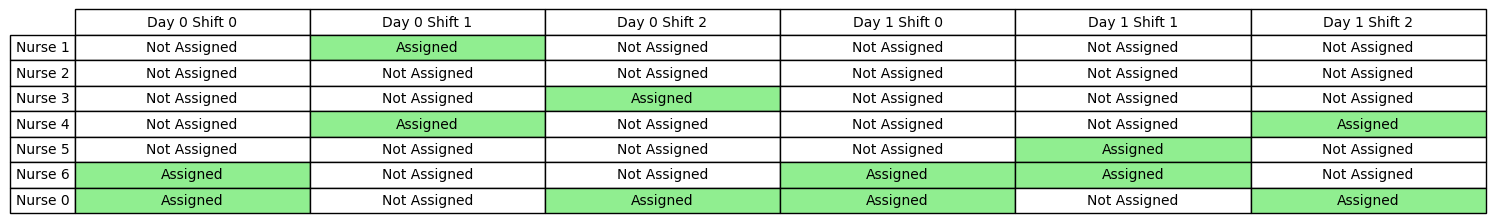

Answer:  No
Query192: is this a solution?


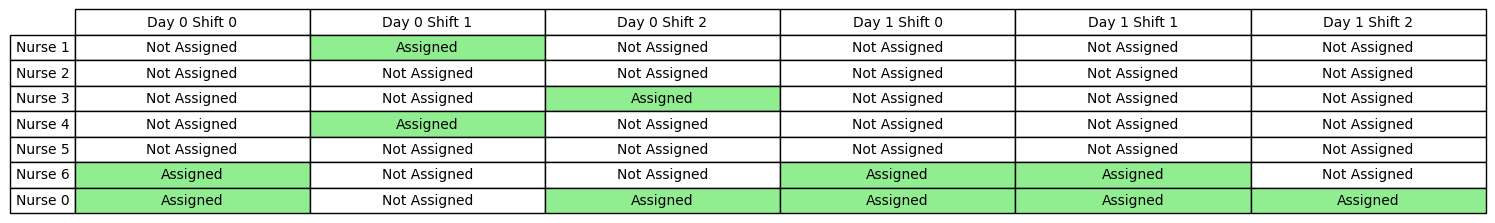

Answer:  No
Query193: is this a solution?


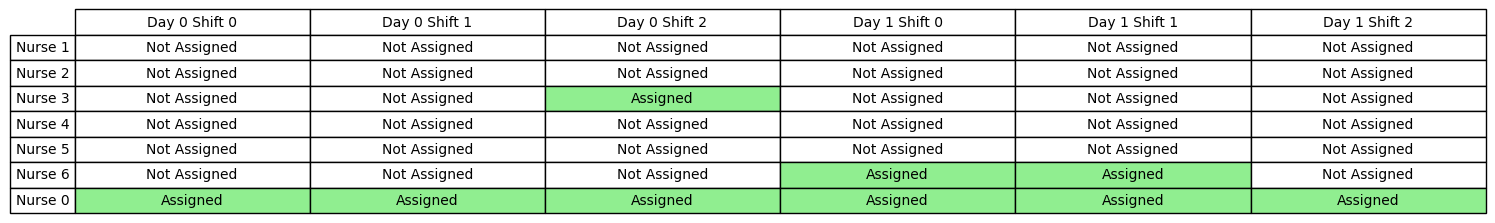

Answer:  No
adding the following constraints to C_L: [(shifts[1,0,0]) != (shifts[1,1,0])]
Size of CL:  30
Size of B:  13
Number of Queries:  194
Query194: is this a solution?


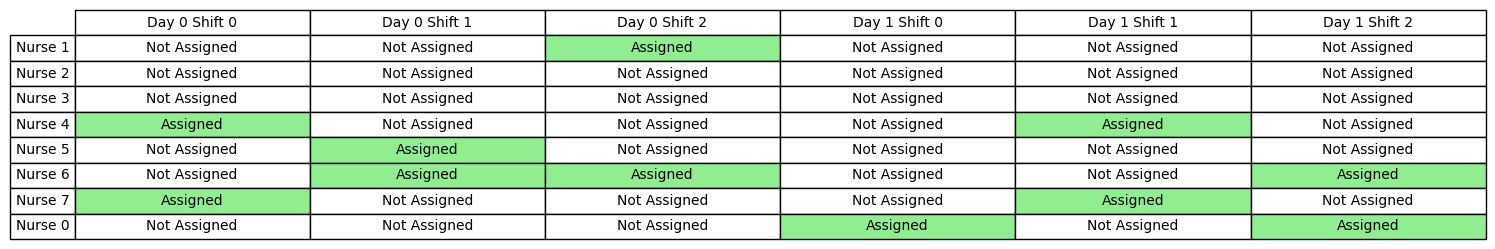

Answer:  No
Query195: is this a solution?


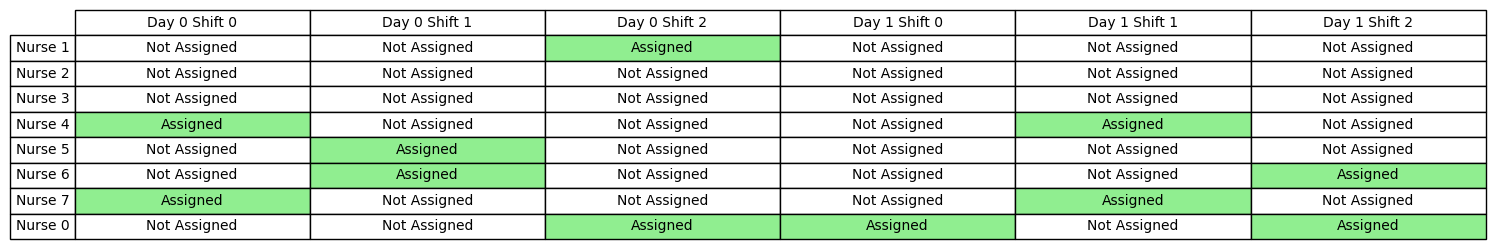

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,1]) != (shifts[1,1,0])]
Query196: is this a solution?


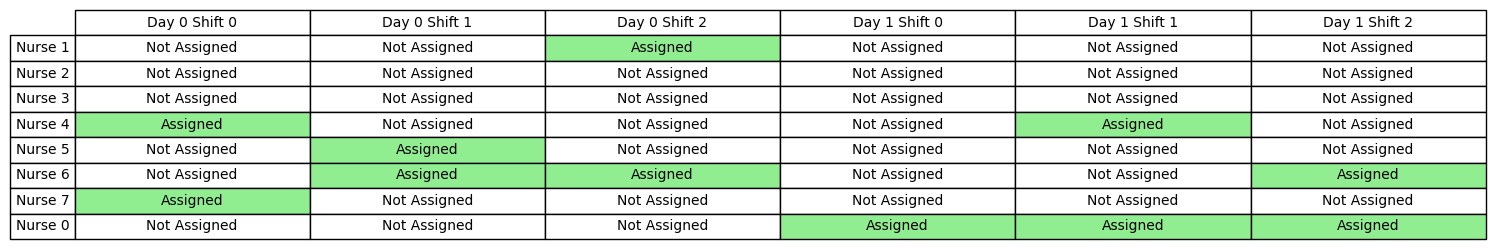

Answer:  No
Query197: is this a solution?


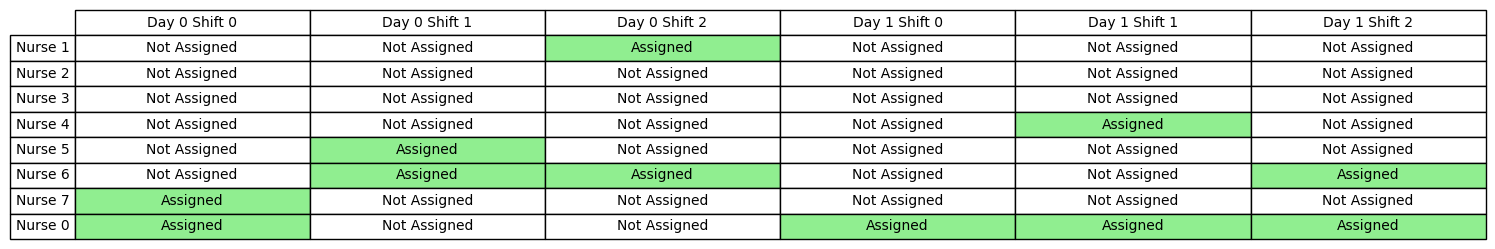

Answer:  No
Query198: is this a solution?


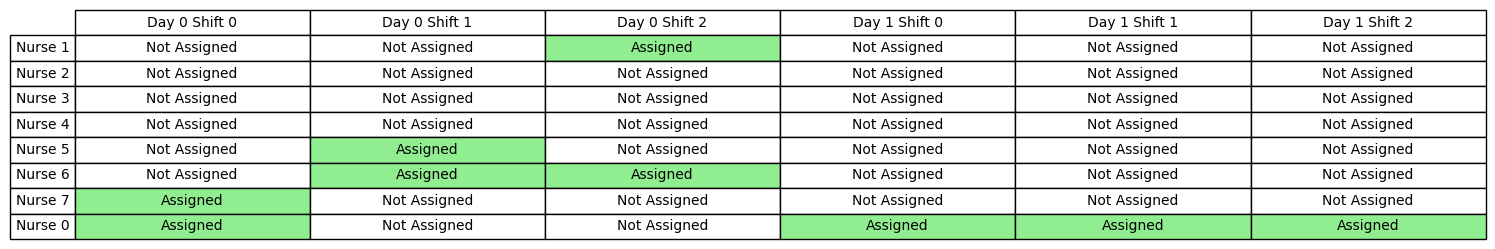

Answer:  No
adding the following constraints to C_L: [(shifts[0,1,0]) != (shifts[0,2,1])]
Size of CL:  31
Size of B:  11
Number of Queries:  199
Query199: is this a solution?


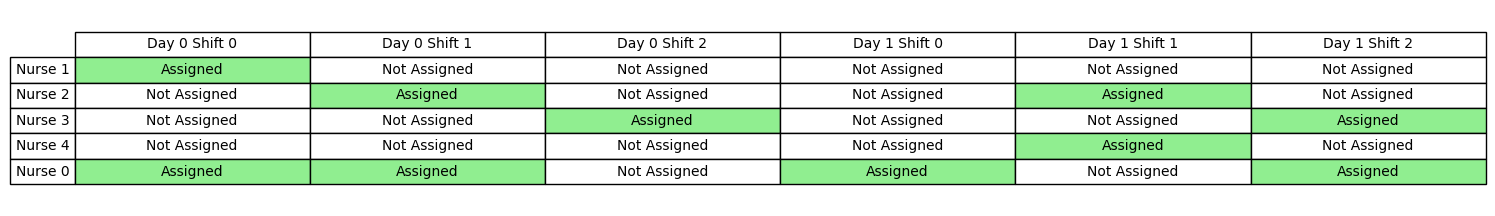

Answer:  No
Query200: is this a solution?


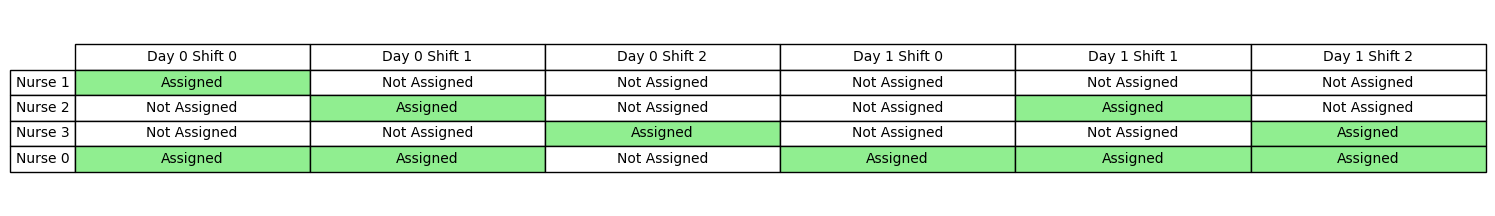

Answer:  No
Query201: is this a solution?


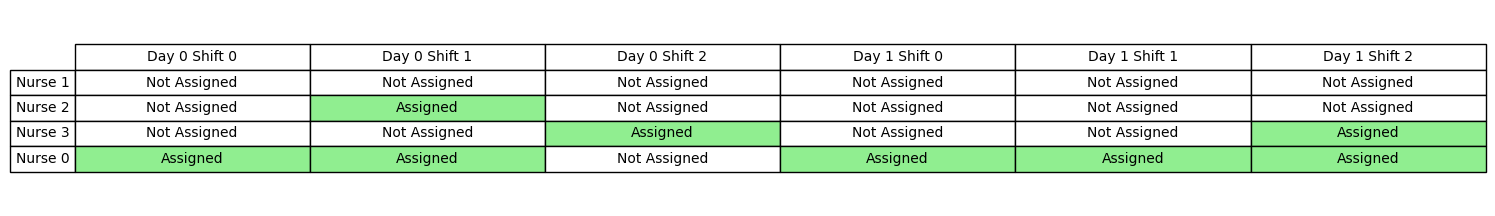

Answer:  No
Query202: is this a solution?


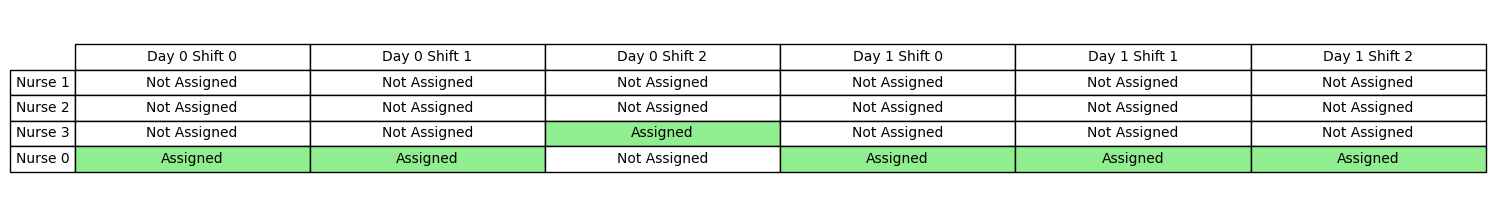

Answer:  No
adding the following constraints to C_L: [(shifts[0,2,0]) != (shifts[0,2,1])]
Size of CL:  32
Size of B:  10
Number of Queries:  203
Query203: is this a solution?


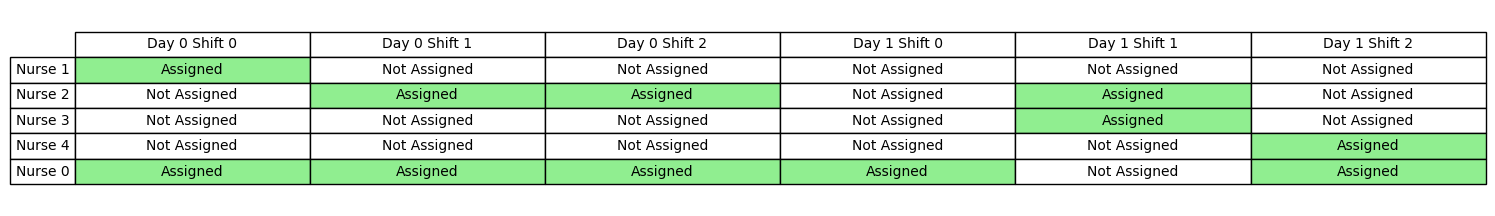

Answer:  No
Query204: is this a solution?


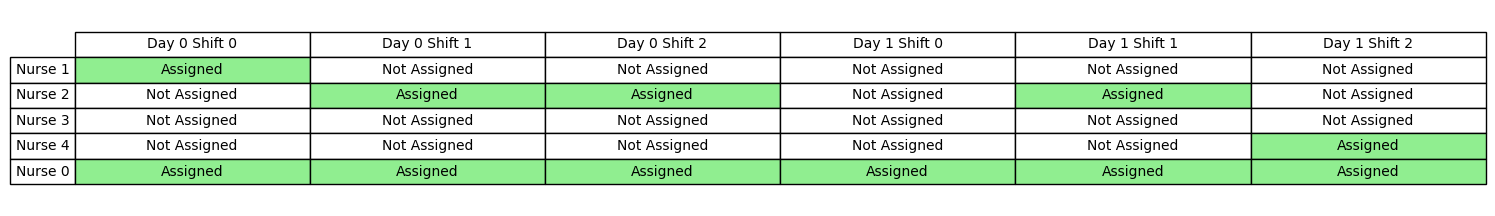

Answer:  No
Query205: is this a solution?


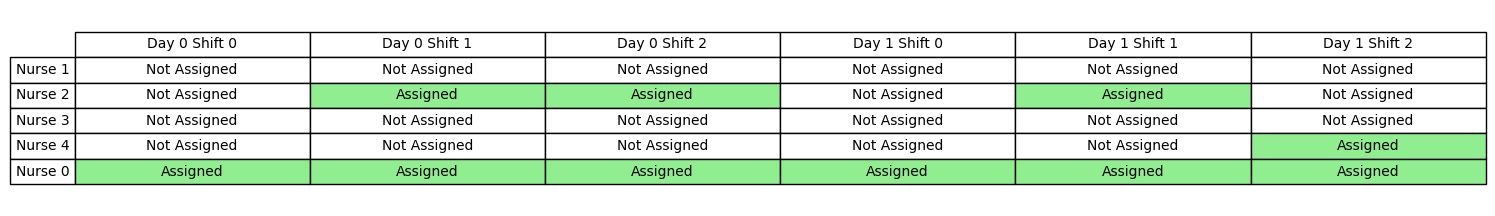

Answer:  No
Query206: is this a solution?


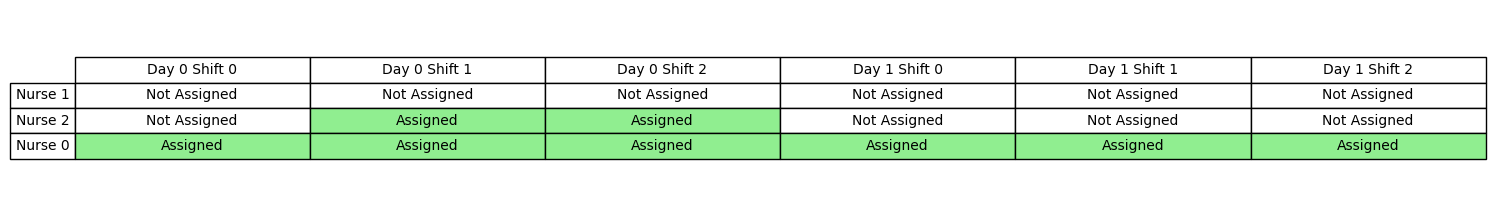

Answer:  No
adding the following constraints to C_L: [(shifts[0,1,1]) != (shifts[0,2,1])]
Size of CL:  33
Size of B:  9
Number of Queries:  207
Query207: is this a solution?


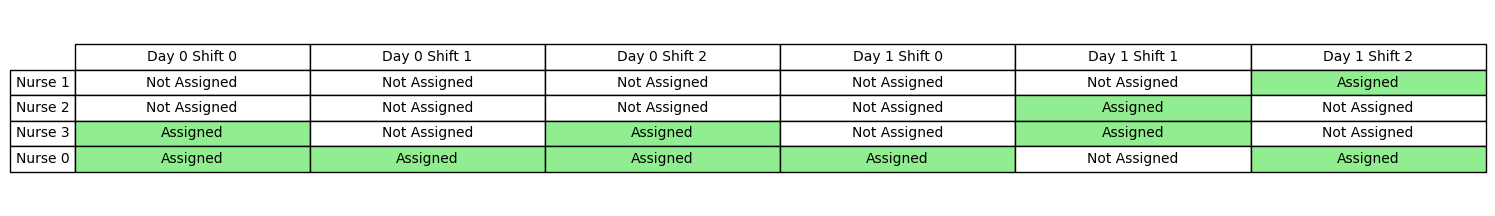

Answer:  No
Query208: is this a solution?


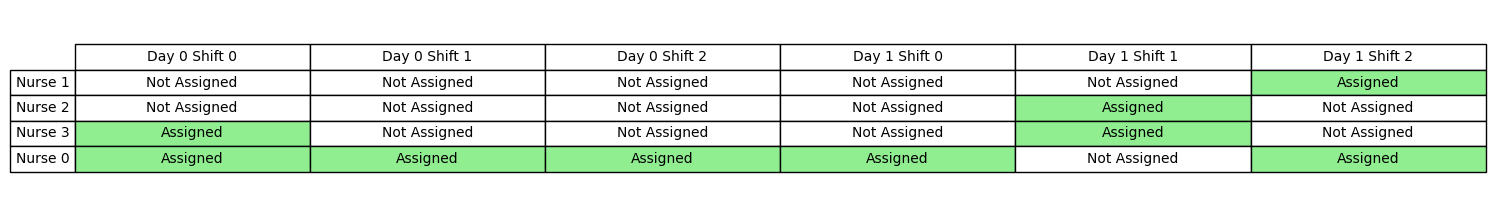

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) != (shifts[1,1,0])]
Query209: is this a solution?


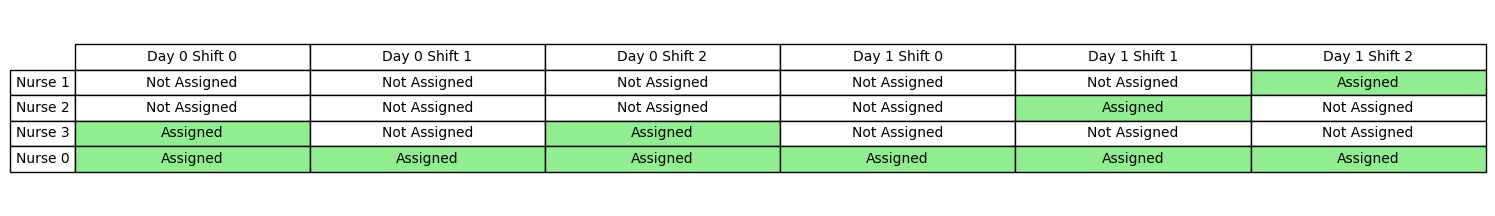

Answer:  No
Query210: is this a solution?


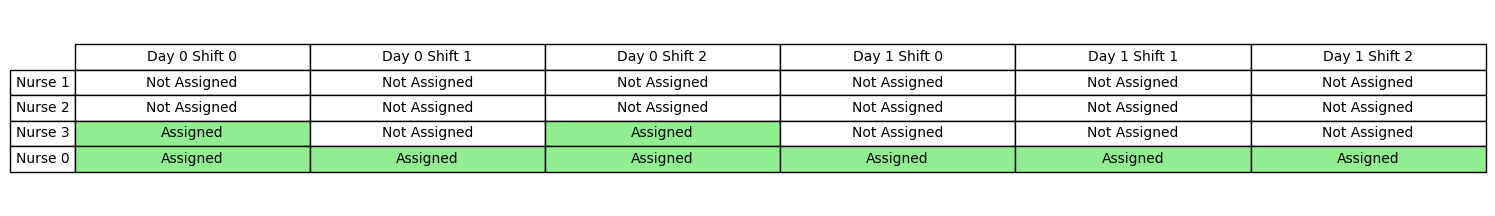

Answer:  No
Query211: is this a solution?


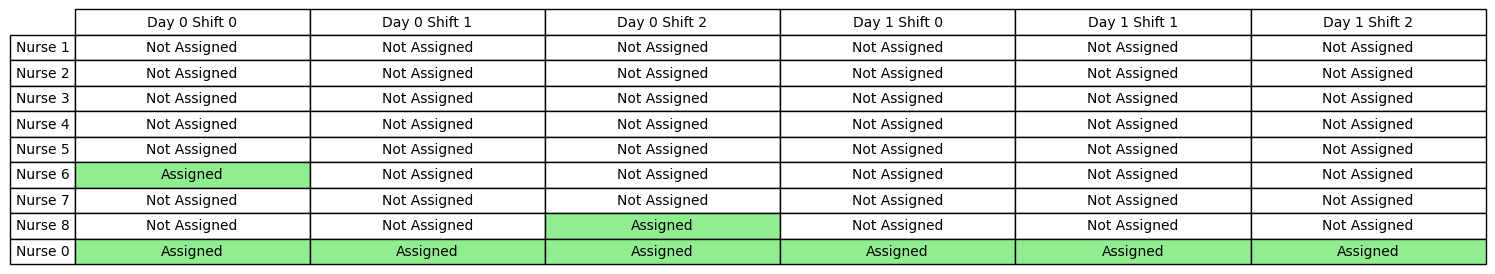

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) > (shifts[0,2,1])]
adding the following constraints to C_L: [(shifts[0,0,0]) != (shifts[0,2,1])]
Size of CL:  34
Size of B:  6
Number of Queries:  212
Query212: is this a solution?


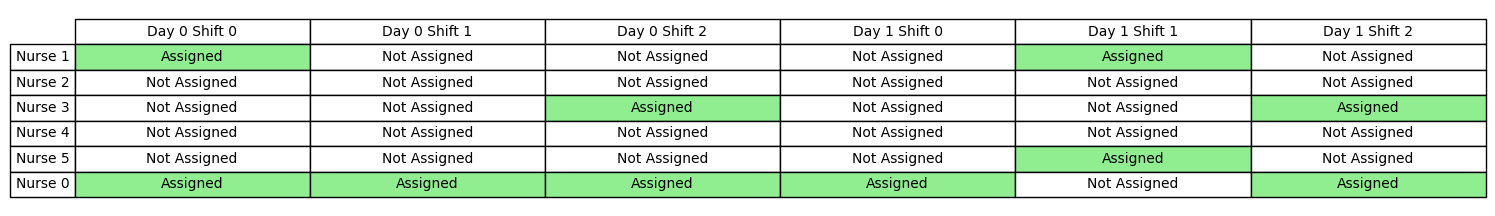

Answer:  Yes
removing the following constraints from bias: [(shifts[0,0,0]) >= (shifts[0,2,1]), (shifts[0,2,1]) >= (shifts[1,1,0]), (shifts[0,2,1]) > (shifts[1,1,0]), (shifts[0,2,1]) != (shifts[1,2,1])]
Size of CL:  34
Size of B:  2
Number of Queries:  213
Query213: is this a solution?


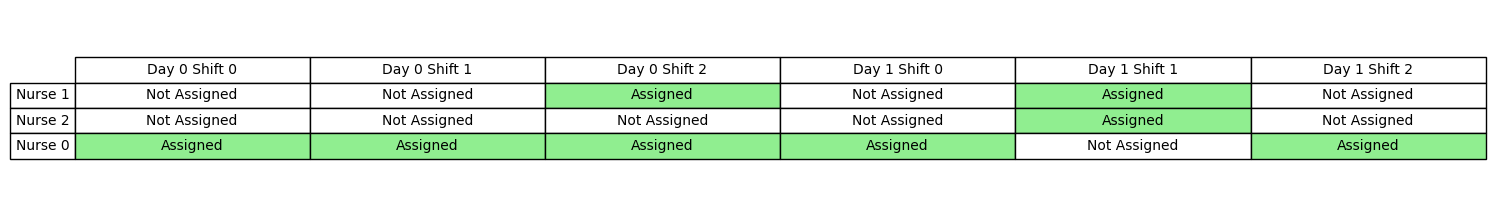

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) != (shifts[1,1,1])]
Size of CL:  34
Size of B:  1
Number of Queries:  214
Query214: is this a solution?


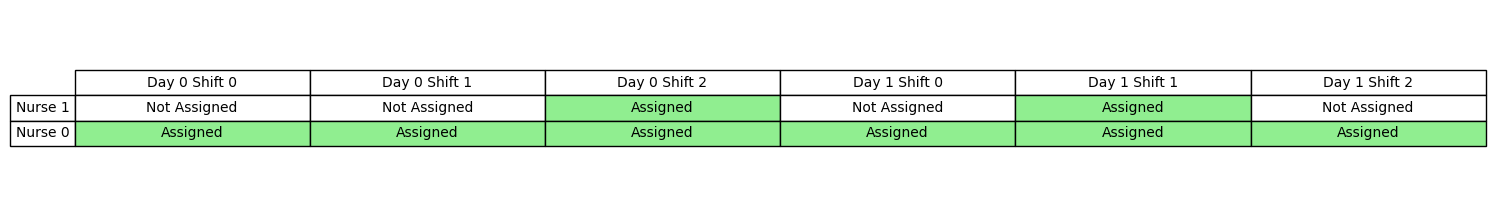

Answer:  Yes
removing the following constraints from bias: [(shifts[0,2,1]) != (shifts[1,1,0])]
Size of CL:  34
Size of B:  0
Number of Queries:  215

Learned 34 constraints in 215 queries.


In [16]:
learned_instance = qa.learn(instance, oracle, verbose=3)

### Multiple Acquisition

In [17]:
# some patience needed here

# Multiple Acquisition: includes MquAcq and MQuAcq2
mqa = MQuAcq()
learned_instance = mqa.learn(instance, oracle=oracle)

mqa2 = MQuAcq2()
learned_instance = mqa2.learn(instance, oracle=oracle)

### GrowAcq

In [18]:
# Creating an environment with the default settings
env = ActiveCAEnv()

# GrowAcq
ga = GrowAcq(env)
learned_instance = ga.learn(instance, oracle=oracle)

# we can compare the statistics:
out = pd.concat([a.env.metrics.short_statistics for a in [qa,mqa,mqa2,ga]])
out.index = ["qa","mqa","mqa2","ga"]
out

CL  tot_q  top_lvl_q  tfs_q  tfc_q  avg_q_size  avg_gen_time   avg_t  \
qa    34    215         38    156     21      6.3302        0.7909  0.6379   
mqa   34    155         64     23     68      2.7677        0.7534  0.0467   
mqa2  34    167         33    101     22      5.2216        0.6119  0.0570   
ga    34    193         72     86     34      4.5492        0.0883  0.0443   

       max_t     tot_t  conv  
qa    2.2550  137.1524     1  
mqa   1.3767    7.2456     1  
mqa2  1.4655    9.5113     1  
ga    0.3461    8.5576     1

## Prediction-based interactive CA system

- 2 types of environments for interactive CA systems in **PyConA**: 
    - the basic ActiveCAEnv, 
    - and the prediction based ProbaActiveCAEnv (default if none is used)
- ProbaActiveCAEnv uses the constraint-level dataset and predictions to guide the queries


ProbaActiveCAEnv has 2 additional configurable options:
- Feature representation (.feature_representation): The feature representation used for the constraints
- Classifier (.classifier): The (probabilistic) classifier used to predict probabilities for the candidate constraints

### Comparing probabilistic approach with basic environment 

In [19]:
from pycona import benchmarks

instance, oracle = benchmarks.construct_nurse_rostering(3, 2, 8, 2)

# env = ProbaActiveCAEnv() # <- we do not have to use it, as it is the default for GrowAcq
ga_predict = GrowAcq() # GrowAcq(env)
learned_instance = ga_predict.learn(instance, oracle)

In [20]:
# comparison with other algorithms
out = pd.concat([a.env.metrics.short_statistics for a in [qa,mqa,mqa2,ga, ga_predict]])
out.index = ["qa","mqa","mqa2","ga", "ga-predict"]
out

CL  tot_q  top_lvl_q  tfs_q  tfc_q  avg_q_size  avg_gen_time  \
qa          34    215         38    156     21      6.3302        0.7909   
mqa         34    155         64     23     68      2.7677        0.7534   
mqa2        34    167         33    101     22      5.2216        0.6119   
ga          34    193         72     86     34      4.5492        0.0883   
ga-predict  34     85         82      1      2      5.4000        0.0853   

             avg_t   max_t     tot_t  conv  
qa          0.6379  2.2550  137.1524     1  
mqa         0.0467  1.3767    7.2456     1  
mqa2        0.0570  1.4655    9.5113     1  
ga          0.0443  0.3461    8.5576     1  
ga-predict  0.0920  0.4926    7.8239     1

### Customize the behaviour of ProbaActiveCAEnv

##### Changing the classifier used

**PyConA** uses scikit-learn classifiers
- any classifier with a .fit() and .predict_proba() can be used. 
- default: Decision tree

In [21]:
from sklearn.naive_bayes import GaussianNB

# Use NB
env = ProbaActiveCAEnv(classifier=GaussianNB())

gaNB = GrowAcq(env)
learned_instance = gaNB.learn(instance, oracle=oracle)

pd.concat([ga_predict.env.metrics.short_statistics, 
           gaNB.env.metrics.short_statistics,
           ga.env.metrics.short_statistics], keys=["Decision Tree", "Naive Bayes", "Basic"])

CL  tot_q  top_lvl_q  tfs_q  tfc_q  avg_q_size  avg_gen_time  \
Decision Tree 0  34     85         82      1      2      5.4000        0.0853   
Naive Bayes   0  34    103         85     11      7      5.2816        0.0916   
Basic         0  34    193         72     86     34      4.5492        0.0883   

                  avg_t   max_t   tot_t  conv  
Decision Tree 0  0.0920  0.4926  7.8239     1  
Naive Bayes   0  0.0879  0.4544  9.0586     1  
Basic         0  0.0443  0.3461  8.5576     1

##### Changing the feature representation


- FeatureRepresentation class to featurize constraints
- Subclass FeatureRepresentation to define custom feature representations

In [22]:
from pycona.predictor import FeatureRepresentation
from pycona.utils import get_relation

class FeaturesSimpleRel(FeatureRepresentation):

        def featurize_constraint(self, c):
            relation = get_relation(c, self.instance.language)
            return [relation]


In [23]:
env1 = ProbaActiveCAEnv(feature_representation=FeaturesSimpleRel())
ga1 = GrowAcq(env1)
learned_instance1 = ga1.learn(instance, oracle=oracle)

pd.concat([ga_predict.env.metrics.short_statistics, 
           ga1.env.metrics.short_statistics], keys=["All Features", "Simple Features"])

CL  tot_q  top_lvl_q  tfs_q  tfc_q  avg_q_size  \
All Features    0  34     85         82      1      2      5.4000   
Simple Features 0  34     90         88      0      2      5.6667   

                   avg_gen_time   avg_t   max_t   tot_t  conv  
All Features    0        0.0853  0.0920  0.4926  7.8239     1  
Simple Features 0        0.0770  0.0818  0.3290  7.3664     1

### PyConA

The repository has implemented various approaches and methods from the literature:
- Algorithms: QuAcq [[1](https://www.lirmm.fr/~coletta/pub/ijcai13.pdf)-[2](https://www.sciencedirect.com/science/article/abs/pii/S0004370223000425)], MQuAcq [[3](https://link.springer.com/chapter/10.1007/978-3-319-98334-9_25)-[4](https://link.springer.com/article/10.1007/s10601-020-09311-4)], MQuAcq-2 \[[5](https://link.springer.com/chapter/10.1007/978-3-030-30048-7_41)], GrowAcq \[[6](https://drops.dagstuhl.de/entities/document/10.4230/LIPIcs.CP.2023.36)], P-QuAcq\[[7](https://www.ijcai.org/Proceedings/16/Papers/108.pdf)], G-QuAcq [[8](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7372165&tag=1)]
- Query Generation: TQ-Gen [[9](https://link.springer.com/chapter/10.1007/978-3-319-93031-2_1)], PQ-Gen [[6](https://drops.dagstuhl.de/entities/document/10.4230/LIPIcs.CP.2023.36)]
- FindScope: FindScope [[1](https://www.lirmm.fr/~coletta/pub/ijcai13.pdf)], Findscope-2 [[2](https://www.sciencedirect.com/science/article/abs/pii/S0004370223000425), [4](https://link.springer.com/article/10.1007/s10601-020-09311-4)]
- FindC: FindC [[1](https://www.lirmm.fr/~coletta/pub/ijcai13.pdf)], FindC-2 [[2](https://www.sciencedirect.com/science/article/abs/pii/S0004370223000425)]
- ML-based CA system and query generation objectives from [[10](https://ojs.aaai.org/index.php/AAAI/article/download/28655/29272)]


### References

[1] [Bessiere, C., at al. (2013, June). Constraint acquisition via partial queries. In _Twenty-Third International Joint Conference on Artificial Intelligence.](https://www.lirmm.fr/~coletta/pub/ijcai13.pdf)

[2] [Bessiere, C., et al. (2023). Learning constraints through partial queries. Artificial Intelligence, 319, 103896.](https://www.sciencedirect.com/science/article/abs/pii/S0004370223000425)

[3] [Tsouros, D. C., Stergiou, K., & Sarigiannidis, P. G. (2018). Efficient methods for constraint acquisition. In _Principles and Practice of Constraint Programming: 24th International Conference, CP 2018, Lille, France, August 27-31, 2018, Proceedings 24_ (pp. 373-388). Springer International Publishing.](https://link.springer.com/chapter/10.1007/978-3-319-98334-9_25)

[4] [Tsouros, D. C., & Stergiou, K. (2020). Efficient multiple constraint acquisition. _Constraints_, _25_(3), 180-225.](https://link.springer.com/article/10.1007/s10601-020-09311-4)

[5] [Tsouros, D. C., Stergiou, K., & Bessiere, C. (2019). Structure-driven multiple constraint acquisition. In _Principles and Practice of Constraint Programming: 25th International Conference, CP 2019, Stamford, CT, USA, September 30–October 4, 2019, Proceedings 25_ (pp. 709-725). Springer International Publishing.](https://link.springer.com/chapter/10.1007/978-3-030-30048-7_41)

[6] [Tsouros, D. C., Berden, S., & Guns, T. (2023). Guided Bottom-Up Interactive Constraint Acquisition}}. In _29th International Conference on Principles and Practice of Constraint Programming (CP 2023)_ (Vol. 280, p. 36).](https://drops.dagstuhl.de/entities/document/10.4230/LIPIcs.CP.2023.36)

[7] [Daoudi, A., Mechqrane, Y., Bessiere, C., Lazaar, N., & Bouyakhf, E. H. (2016, July). Constraint Acquisition with Recommendation Queries. In _IJCAI_ (pp. 720-726).](https://www.ijcai.org/Proceedings/16/Papers/108.pdf)

[8] [Daoudi, A., Lazaar, N., Mechqrane, Y., Bessiere, C., & Bouyakhf, E. H. (2015, November). Detecting types of variables for generalization in constraint acquisition. In _2015 IEEE 27th International Conference on Tools with Artificial Intelligence (ICTAI)_ (pp. 413-420). IEEE.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7372165&tag=1)

[9][Ait Addi, H., Bessiere, C., Ezzahir, R., & Lazaar, N. (2018). Time-bounded query generator for constraint acquisition. In _Integration of Constraint Programming, Artificial Intelligence, and Operations Research: 15th International Conference, CPAIOR 2018, Delft, The Netherlands, June 26–29, 2018, Proceedings 15_ (pp. 1-17). Springer International Publishing.](https://link.springer.com/chapter/10.1007/978-3-319-93031-2_1)

[10] [Tsouros, D., Berden, S., & Guns, T. (2024, March). Learning to learn in interactive constraint acquisition. In _Proceedings of the AAAI Conference on Artificial Intelligence_ (Vol. 38, No. 8, pp. 8154-8162)](https://ojs.aaai.org/index.php/AAAI/article/download/28655/29272)
